In [409]:
import optuna
import re
from collections import defaultdict
from typing import Iterable, Mapping, Any
import plotly.graph_objects as go
import plotly.express as px
import matplotlib.pyplot as plt
import warnings
import pandas as pd
import seaborn as sns
import math
from tqdm.notebook import tqdm
import os
import numpy as np
import mplfinance as mpf
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import RobustScaler
from scipy.sparse import issparse
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter
import shap
from typing import List, Tuple, Dict, Optional
import numpy as np
import optuna
from optuna.trial import FrozenTrial

%matplotlib inline
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
#plt.style.use('ggplot')
#plt.rcParams['figure.figsize'] = (18, 10)
#plt.rcParams['axes.facecolor'] = 'black'
sns.set_palette('Spectral')
optuna.logging.set_verbosity(optuna.logging.WARNING)

from typing import List, Tuple, Dict
from optuna.trial import FrozenTrial

def find_best_trial_by_weighted_three_score(
    trials: List[FrozenTrial],
    pnl_score = 0.45,
    diff_score = 0.45,
    weight_score = 0.10
) -> Tuple[float, int, float, float, int, Dict]:
    """
    Ищет лучший трейл по взвешенной сумме двух метрик:
        - pnl (trial.values[0]), вес 0.65, диапазон 0..600
        - diff (trial.values[1]), вес 0.35, диапазон 0..1

    Возвращает:
        - score: float — итоговый взвешенный скор
        - trial_number: int — номер трейла
        - pnl: float — значение pnl
        - diff: float — значение diff
        - params: dict — параметры трейла
    """
    WEIGHT_PNL = pnl_score
    WEIGHT_DIFF = diff_score
    WEIGHT_SCORE = weight_score
    MAX_PNL = np.max([i.values[0] for i in [trial for trial in trials if trial.values is not None]])*2.5  # для нормализации
    MAX_SCORE = np.max([i.values[2] for i in [trial for trial in study.trials if trial.values is not None]])  # для нормализации
    MAX_DIFF = 1   # для нормализации

    best_score = float('-inf')
    best_trial_number = -1
    best_pnl = None
    best_diff = None
    best_score_n = None
    best_params = None

    for trial in trials:
        # Проверяем что трейл валидный и содержит обе метрики
        if not trial.values or len(trial.values) < 3:
            continue

        pnl = trial.values[0]
        diff = trial.values[1]
        score_n = trial.values[2]

        # Нормализуем значения
        norm_pnl = pnl / MAX_PNL if MAX_PNL else 0
        norm_diff = diff / MAX_DIFF if MAX_DIFF else 0
        norm_score = score_n / MAX_SCORE if WEIGHT_SCORE else 0

        # Взвешенная сумма
        score = WEIGHT_PNL * norm_pnl + WEIGHT_DIFF * norm_diff + WEIGHT_SCORE * norm_score

        if score > best_score:
            best_score = score
            best_trial_number = trial.number
            best_pnl = pnl
            best_diff = diff
            best_score_n = score_n
            best_params = trial.params

    if best_trial_number == -1:
        raise ValueError("Нет подходящих трейлов с двумя метриками (pnl и diff).")

    return best_score, best_trial_number, best_pnl, best_diff, best_score_n, best_params

def find_best_trial_by_weighted_score(
    trials: List[FrozenTrial]
) -> Tuple[float, int, float, float, Dict]:
    """
    Ищет лучший трейл по взвешенной сумме двух метрик:
        - pnl (trial.values[0]), вес 0.65, диапазон 0..600
        - diff (trial.values[1]), вес 0.35, диапазон 0..1

    Возвращает:
        - score: float — итоговый взвешенный скор
        - trial_number: int — номер трейла
        - pnl: float — значение pnl
        - diff: float — значение diff
        - params: dict — параметры трейла
    """
    WEIGHT_PNL = 0.60
    WEIGHT_DIFF = 0.40
    MAX_PNL = np.max([i.values for i in [trial for trial in trials if trial.values is not None]])*2.5  # для нормализации
    MAX_DIFF = 1   # для нормализации

    best_score = float('-inf')
    best_trial_number = -1
    best_pnl = None
    best_diff = None
    best_params = None

    for trial in trials:
        # Проверяем что трейл валидный и содержит обе метрики
        if not trial.values or len(trial.values) < 2:
            continue

        pnl = trial.values[0]
        diff = trial.values[1]

        # Нормализуем значения
        norm_pnl = pnl / MAX_PNL if MAX_PNL else 0
        norm_diff = diff / MAX_DIFF if MAX_DIFF else 0

        # Взвешенная сумма
        score = WEIGHT_PNL * norm_pnl + WEIGHT_DIFF * norm_diff

        if score > best_score:
            best_score = score
            best_trial_number = trial.number
            best_pnl = pnl
            best_diff = diff
            best_params = trial.params

    if best_trial_number == -1:
        raise ValueError("Нет подходящих трейлов с двумя метриками (pnl и diff).")

    return best_score, best_trial_number, best_pnl, best_diff, best_params

def find_best_trial_by_weighted_score_extended(
    trials: List[FrozenTrial]
) -> Tuple[float, int, Dict, str, float, float, float, float]:
    """
    Ищет лучший трейл по взвешенной сумме метрик для двух стратегий:
        - Стратегия RSI: pnl_rsi и diff_rsi
        - Стратегия RSI+SMA/EMA: pnl_full и diff_full
    
    Возвращает:
        - best_score: float - наивысший взвешенный скор среди всех стратегий
        - best_trial_number: int - номер лучшего трейла
        - best_params: dict - параметры лучшего трейла
        - best_strategy: str - название лучшей стратегии ('RSI' или 'RSI_SMA_EMA')
        - best_pnl: float - лучшее значение PnL (из выбранной стратегии)
        - best_diff: float - лучшее значение diff (из выбранной стратегии)
        - pnl_rsi: float - значение PnL для стратегии RSI
        - diff_rsi: float - значение diff для стратегии RSI
        - pnl_full: float - значение PnL для стратегии RSI+SMA/EMA
        - diff_full: float - значение diff для стратегии RSI+SMA/EMA
    """
    # Веса для метрик
    WEIGHT_PNL = 0.80
    WEIGHT_DIFF = 0.20
    
    # Максимальные значения для нормализации (можно настроить)
    MAX_PNL = np.max([i.values for i in [trial for trial in study.trials if trial.values is not None]])  # предполагаемый максимум PnL
    MAX_DIFF = 1    # максимум для diff (уже нормализован)
    
    best_score = float('-inf')
    best_trial_number = -1
    best_params = None
    best_strategy = None
    best_pnl = None
    best_diff = None
    
    # Для хранения всех метрик (для отладки/анализа)
    full_results = []

    for trial in trials:
        # Проверяем что трейл валидный и содержит все 4 метрики
        if not trial.values or len(trial.values) < 4 and trial.values:
            continue
            
        pnl_rsi, pnl_full, diff_rsi, diff_full = trial.values
        
        # Нормализация значений (защита от деления на 0)
        norm_pnl_rsi = pnl_rsi / MAX_PNL if MAX_PNL != 0 else 0
        norm_pnl_full = pnl_full / MAX_PNL if MAX_PNL != 0 else 0
        norm_diff_rsi = diff_rsi / MAX_DIFF if MAX_DIFF != 0 else 0
        norm_diff_full = diff_full / MAX_DIFF if MAX_DIFF != 0 else 0
        
        # Вычисляем скоринг для обеих стратегий
        score_rsi = WEIGHT_PNL * norm_pnl_rsi + WEIGHT_DIFF * norm_diff_rsi
        score_full = WEIGHT_PNL * norm_pnl_full + WEIGHT_DIFF * norm_diff_full
        
        # Определяем какая стратегия лучше в этом трейле
        if score_rsi > score_full:
            current_score = score_rsi
            current_strategy = 'С трендовой линией'
            current_pnl = pnl_rsi
            current_diff = diff_rsi
        else:
            current_score = score_full
            current_strategy = 'Трендовая + недельные скользящие'
            current_pnl = pnl_full
            current_diff = diff_full
        
        # Сохраняем все метрики для анализа
        full_results.append({
            'trial_number': trial.number,
            'score_rsi': score_rsi,
            'score_full': score_full,
            'strategy': current_strategy,
            'score': current_score,
            'params': trial.params
        })
        
        # Обновляем лучший результат
        if current_score > best_score:
            best_score = current_score
            best_trial_number = trial.number
            best_params = trial.params
            best_strategy = current_strategy
            best_pnl = current_pnl
            best_diff = current_diff

    if best_trial_number == -1:
        raise ValueError("Нет подходящих трейлов с четырьмя метриками (pnl_rsi, pnl_full, diff_rsi, diff_full).")

    return (
        best_score,
        best_trial_number,
        best_params,
        best_strategy,
        best_pnl,
        best_diff,
        # Возвращаем также все метрики для лучшего трейла
        #next(t.values[0] for t in trials if t.number == best_trial_number),  # pnl_rsi
        #next(t.values[2] for t in trials if t.number == best_trial_number),  # diff_rsi
        #next(t.values[1] for t in trials if t.number == best_trial_number),  # pnl_full
        #next(t.values[3] for t in trials if t.number == best_trial_number)   # diff_full
    )

def find_best_trial_by_weighted_score_extended1(
    trials: List[FrozenTrial],
    pnl_score: float = 0.45,
    diff_score: float = 0.45,
    weight_score: float = 0.10
) -> Tuple[float, int, Dict, str, float, float, float, float, float, float]:
    """
    Ищет лучший трейл по взвешенной сумме метрик для двух стратегий:
        - Стратегия RSI: pnl_rsi, diff_rsi, score_rsi
        - Стратегия RSI+SMA/EMA: pnl_full, diff_full, score_full
    
    Параметры:
        - pnl_score: вес для метрики PnL (по умолчанию 0.45)
        - diff_score: вес для метрики diff (по умолчанию 0.45)
        - weight_score: вес для дополнительной метрики score (по умолчанию 0.10)
    
    Возвращает:
        - best_score: float - наивысший взвешенный скор среди всех стратегий
        - best_trial_number: int - номер лучшего трейла
        - best_params: dict - параметры лучшего трейла
        - best_strategy: str - название лучшей стратегии ('RSI' или 'RSI_SMA_EMA')
        - best_pnl: float - лучшее значение PnL (из выбранной стратегии)
        - best_diff: float - лучшее значение diff (из выбранной стратегии)
        - best_score_n: float - лучшее значение score (из выбранной стратегии)
        - pnl_rsi: float - значение PnL для стратегии RSI
        - diff_rsi: float - значение diff для стратегии RSI
        - pnl_full: float - значение PnL для стратегии RSI+SMA/EMA
        - diff_full: float - значение diff для стратегии RSI+SMA/EMA
        - score_rsi: float - значение score для стратегии RSI
        - score_full: float - значение score для стратегии RSI+SMA/EMA
    """
    # Проверка корректности весов
    total_weight = pnl_score + diff_score + weight_score
    if not np.isclose(total_weight, 1.0):
        raise ValueError(f"Сумма весов должна быть равна 1.0 (получено {total_weight})")
    
    # Максимальные значения для нормализации
    MAX_PNL = np.max([max(trial.values[0], trial.values[1]) for trial in trials if trial.values is not None]) * 2.5
    MAX_DIFF = 1.0    # максимум для diff (уже нормализован)
    MAX_SCORE = np.max([max(trial.values[2], trial.values[3]) for trial in trials if trial.values is not None]) if weight_score > 0 else 1.0
    
    best_score = float('-inf')
    best_trial_number = -1
    best_params = None
    best_strategy = None
    best_pnl = None
    best_diff = None
    best_score_n = None
    
    # Для хранения всех метрик (для отладки/анализа)
    full_results = []

    for trial in trials:
        # Проверяем что трейл валидный и содержит все 6 метрик
        if not trial.values or len(trial.values) < 6:
            continue
            
        pnl_rsi, pnl_full, score_rsi, score_full, diff_rsi, diff_full = trial.values
        
        # Нормализация значений (защита от деления на 0)
        norm_pnl_rsi = pnl_rsi / MAX_PNL if MAX_PNL != 0 else 0
        norm_pnl_full = pnl_full / MAX_PNL if MAX_PNL != 0 else 0
        norm_diff_rsi = diff_rsi / MAX_DIFF if MAX_DIFF != 0 else 0
        norm_diff_full = diff_full / MAX_DIFF if MAX_DIFF != 0 else 0
        norm_score_rsi = score_rsi / MAX_SCORE if MAX_SCORE != 0 and weight_score > 0 else 0
        norm_score_full = score_full / MAX_SCORE if MAX_SCORE != 0 and weight_score > 0 else 0
        
        # Вычисляем скоринг для обеих стратегий
        score_rsi_weighted = (pnl_score * norm_pnl_rsi + 
                             diff_score * norm_diff_rsi + 
                             weight_score * norm_score_rsi)
        
        score_full_weighted = (pnl_score * norm_pnl_full + 
                              diff_score * norm_diff_full + 
                              weight_score * norm_score_full)
        
        # Определяем какая стратегия лучше в этом трейле
        if score_rsi_weighted > score_full_weighted:
            current_score = score_rsi_weighted
            current_strategy = 'С трендовой линией'
            current_pnl = pnl_rsi
            current_diff = diff_rsi
            current_score_n = score_rsi
        else:
            current_score = score_full_weighted
            current_strategy = 'Трендовая + недельные скользящие'
            current_pnl = pnl_full
            current_diff = diff_full
            current_score_n = score_full
        
        # Сохраняем все метрики для анализа
        full_results.append({
            'trial_number': trial.number,
            'score_rsi': score_rsi_weighted,
            'score_full': score_full_weighted,
            'strategy': current_strategy,
            'score': current_score,
            'params': trial.params
        })
        
        # Обновляем лучший результат
        if current_score > best_score:
            best_score = current_score
            best_trial_number = trial.number
            best_params = trial.params
            best_strategy = current_strategy
            best_pnl = current_pnl
            best_diff = current_diff
            best_score_n = current_score_n

    if best_trial_number == -1:
        raise ValueError("Нет подходящих трейлов с шестью метриками (pnl_rsi, pnl_full, score_rsi, score_full, diff_rsi, diff_full).")

    # Получаем все метрики для лучшего трейла
    best_trial = next(t for t in trials if t.number == best_trial_number)
    pnl_rsi, pnl_full, score_rsi, score_full, diff_rsi, diff_full = best_trial.values

    return (
        best_score,
        best_trial_number,
        best_params,
        best_strategy,
        best_pnl,
        best_diff,
        best_score_n,
        pnl_rsi,
        diff_rsi,
        score_rsi,
        pnl_full,
        diff_full,
        score_full
    )

def plot_price_with_indicators_mplfinance(df, ticker, regime = 'P',save_path=None):
    """
    Отрисовывает график движения цены с индикаторами и сигналами покупки/продажи, используя mplfinance.

    Args:
        df (pd.DataFrame): DataFrame с данными о цене и индикаторах.
        ticker (str): Тикер акции для заголовка графика.
        save_path (str, optional): Путь для сохранения графика. Если None, то график покажется.
    """
    # Копируем DataFrame, чтобы не менять оригинал
    df = df.copy()

    # Преобразуем столбец time в datetime и делаем индексом
    df["time"] = pd.to_datetime(df["time"])
    df = df.set_index("time")

    # Создаем список дополнительных панелей для индикаторов (без объема)
    apds = []


    if "pmax" in df.columns:
        apds.append(mpf.make_addplot(df["pmax"], color="red", ylabel="PMAX", panel=0))
    if "ma" in df.columns:
        apds.append(mpf.make_addplot(df["ma"], color="blue", ylabel="VAR", panel=0))
    if "var" in df.columns:
        apds.append(mpf.make_addplot(df["var"], color="blue", ylabel="VAR", panel=0))
    if "ema" in df.columns:
        apds.append(mpf.make_addplot(df["ema"], color="purple", ylabel="EMA", panel=0))
    if "adaptive_ma" in df.columns:
        apds.append(mpf.make_addplot(df["adaptive_ma"], color="blue", ylabel="VAR", panel=0))
    if "adaptive_pmax" in df.columns:
        apds.append(mpf.make_addplot(df["adaptive_pmax"], color="purple", ylabel="EMA", panel=0))

    if "regime" in df.columns and regime == 'R':
        # Генерация цветовой карты по количеству уникальных режимов
        unique_regimes = sorted(df['regime'].unique())
        colors = plt.cm.get_cmap('tab10', len(unique_regimes))
        
        for i, reg in enumerate(unique_regimes):
            # Создаем линию на уровне 5% от минимума
            reg_line = (df["low"] * 1.05).where(df["regime"] == reg)
            apds.append(mpf.make_addplot(
                reg_line,
                type='line',
                color=colors(i),
                panel=0
            ))
    if "normalized_target" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["normalized_target"], color="blue", ylabel="Regime", panel=2))
    if "predicted_p" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["predicted_p"], color="black", ylabel="Regime", panel=2))
    if "multi_target_0" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["multi_target_0"], color="yellow", ylabel="Regime", panel=2))
    if "multi_target_5" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["multi_target_5"], color="green", ylabel="Regime", panel=2))
    if "multi_target_10" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["multi_target_10"], color="grey", ylabel="Regime", panel=2))
    if "multi_target_20" in df.columns and regime == 'P':
        # Генерация цветовой карты по количеству уникальных режимов
        apds.append(mpf.make_addplot(df["multi_target_20"], color="purple", ylabel="Regime", panel=2))

    # Подготовка сигналов для отрисовки
    buy_signals = df[df["buy_signal"]]
    sell_signals = df[df["sell_signal"]]

    # Создаем Series для сигналов, выровненные по индексу основного DataFrame
    buy_series = pd.Series(index=df.index, dtype='float64')
    buy_series[buy_signals.index] = buy_signals['open']

    sell_series = pd.Series(index=df.index, dtype='float64')
    sell_series[sell_signals.index] = sell_signals['open']

    # Добавляем сигналы покупки
    if not buy_signals.empty:
        apds.append(mpf.make_addplot(
            buy_series,
            type='scatter',
            markersize=50,
            marker='^',
            color='green',
            label='Buy Signal',
            panel=0
        ))

    # Добавляем сигналы продажи
    if not sell_signals.empty:
        apds.append(mpf.make_addplot(
            sell_series,
            type='scatter',
            markersize=50,
            marker='v',
            color='red',
            label='Sell Signal',
            panel=0
        ))

    # Подготовка vlines (единый словарь)
    vlines_dict = {}
    if not buy_signals.empty:
        vlines_dict['vlines'] = buy_signals.index.to_list()
        vlines_dict['linewidths'] = 0.5
        vlines_dict['colors'] = ['green'] * len(buy_signals)
        vlines_dict['alpha'] = 0.5

    if not sell_signals.empty:
        if 'vlines' in vlines_dict:
            vlines_dict['vlines'].extend(sell_signals.index.to_list())
            vlines_dict['colors'].extend(['red'] * len(sell_signals))
        else:
            vlines_dict['vlines'] = sell_signals.index.to_list()
            vlines_dict['linewidths'] = 0.5
            vlines_dict['colors'] = ['red'] * len(sell_signals)
            vlines_dict['alpha'] = 0.5

    # Отрисовка графика с mplfinance
    plot_kwargs = dict(
        type="candle",
        style="yahoo",
        title=f"График цены {ticker} с индикаторами",
        ylabel="Цена",
        addplot=apds,
        show_nontrading=False,
        figsize=(18, 10),
        warn_too_much_data=len(df) + 1,
    )

    if "volume" in df.columns:
        plot_kwargs["volume"] = True
        plot_kwargs["panel_ratios"] = (6, 3)
    if vlines_dict:
        plot_kwargs["vlines"] = vlines_dict

    if save_path:
        plot_kwargs["savefig"] = save_path

    mpf.plot(df, **plot_kwargs)
    
def plot_3d_metrics(trials, num_trial = [0,1,2],x_label='среднее значение f1', y_label='среднее значение AUC ROC', z_label='стандартное отклонение f1', deffs=None, directions=['максимизировать', 'максимизировать', 'минимизировать']):
    """
    Функция для построения 3D-графика на основе результатов Optuna.

    Параметры:
    -----------
    trials : list
        Список объектов `optuna.trial.FrozenTrial` из study.trials.
    x_label : str, optional
        Название для оси X (по умолчанию 'среднее значение f1').
    y_label : str, optional
        Название для оси Y (по умолчанию 'среднее значение AUC ROC').
    z_label : str, optional
        Название для оси Z (по умолчанию 'стандартное отклонение f1').
    deffs : list, optional
        Пороговые значения для фильтрации trials (по умолчанию None).
    directions : list, optional
        Направления оптимизации для каждой метрики (по умолчанию ['максимизировать', 'максимизировать', 'минимизировать']).
    """
    print(len(trials))

    # Сопоставление направлений с операторами сравнения
    direction_to_operator = {
        'максимизировать': lambda a, b: a > b,
        'минимизировать': lambda a, b: a < b
    }

    # Фильтрация trials
    if deffs is None:
        trials = [trial for trial in trials if trial.values is not None]
    else:
        trials = [
            trial for trial in trials
            if trial.values is not None
            and direction_to_operator[directions[0]](trial.values[0], deffs[0])
            and direction_to_operator[directions[1]](trial.values[1], deffs[1])
            and direction_to_operator[directions[2]](trial.values[2], deffs[2])
        ]

    print(len(trials))

    # Извлечение значений метрик
    x_vals = [trial.values[num_trial[0]] for trial in trials]
    y_vals = [trial.values[num_trial[1]] for trial in trials]
    z_vals = [trial.values[num_trial[2]] for trial in trials]

    # Форматирование параметров для hover text
    def format_params(params):
        return '<br>'.join([f"{key}: {value}" for key, value in params.items()])

    # Создание текста для hover
    hover_texts = [
        f"Number: {trial.number}<br>"
        f"{x_label}: {trial.values[num_trial[0]]:.4f}<br>"
        f"{y_label}: {trial.values[num_trial[1]]:.4f}<br>"
        f"{z_label}: {trial.values[num_trial[2]]:.4f}<br>"
        f"Params:<br>{format_params(trial.params)}"
        for trial in trials
    ]

    # Создание 3D-графика
    fig = go.Figure(data=[go.Scatter3d(
        x=x_vals, y=y_vals, z=z_vals,
        mode='markers',
        marker=dict(
            size=4,
            color=x_vals,  # Цветовая шкала может быть привязана к одной из метрик
            colorscale='Viridis',
            opacity=0.8
        ),
        text=hover_texts,  # Добавляем hover text
        hoverinfo='text'   # Указываем, что при наведении нужно показывать текст
    )])

    # Добавление меток к осям
    fig.update_layout(
        scene=dict(
            xaxis_title=x_label,
            yaxis_title=y_label,
            zaxis_title=z_label
        ),
        title="3 метрики через Optuna"
    )

    # Отображение графика
    fig.show()

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.
    
    Args:
        optuna_params (dict): Словарь с параметрами из Optuna
        
    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}
    
    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}
        
        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)
        
        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')
        
        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }
        
        base_params[regime] = regime_params
    
    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]
    
    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]
    
    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }

def pair_and_clean_signals(df: pd.DataFrame) -> pd.DataFrame:
    """
    Оставляет только первый buy после flat и первый sell после buy.
    Гарантирует, что каждая покупка имеет свою продажу.
    """
    df = df.copy()
    # пусть V5 уже записал нам в df['buy_signal'], df['sell_signal'] — raw-сигналы
    buy_raw  = df['buy_signal'].values
    sell_raw = df['sell_signal'].values

    # обнуляем
    df['buy_signal']  = False
    df['sell_signal'] = False

    in_pos = False
    for i in range(len(df)):
        if not in_pos and buy_raw[i]:
            # открываем новую сделку
            df.iat[i, df.columns.get_loc('buy_signal')] = True
            in_pos = True
        elif in_pos and sell_raw[i]:
            # закрываем
            df.iat[i, df.columns.get_loc('sell_signal')] = True
            in_pos = False
        # все остальные raw-сигналы игнорируем

    # если позиция осталась открытой — принудительный выход на последнем баре
    if in_pos and len(df)>0:
        df.iat[len(df)-1, df.columns.get_loc('sell_signal')] = True

    return df

import joblib

from collections import deque
import numpy as np

class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma


class TinkoffHistoricalDataCollector:
    def __init__(self):
        self.sma_state = {}

    def generateVar(self, high_array, low_array, moving_average_length=10):
        valpha = 2 / (moving_average_length + 1)
        hl2 = (high_array + low_array) / 2

        before_val = hl2[0] if len(hl2) > 0 else 0

        vud1 = []
        vdd1 = []
        for current_hl2 in hl2:
            if current_hl2 > before_val:
                vud1.append(current_hl2 - before_val)
                vdd1.append(0)
            elif current_hl2 < before_val:
                vdd1.append(before_val - current_hl2)
                vud1.append(0)
            else:
                vud1.append(0)
                vdd1.append(0)
            before_val = current_hl2

        def calculate_window_sums(arr, window_size=9):
          return [sum(arr[max(0, i - window_size + 1):i+1]) for i in range(len(arr))]

        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        vUD_ar = np.array(vUD)
        vDD_ar = np.array(vDD)

        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD_ar - vDD_ar, vUD_ar + vDD_ar + epsilon)

        vCMO = np.nan_to_num(vCMO, nan=0.0)

        var = []
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(vCMO):
                cmo = abs(vCMO[i])
                var_current = (valpha * cmo * hl2[i]) + (1 - valpha * cmo) * var_before
            else:
                var_current = var_before
            var.append(var_current)
            var_before = var_current

        return np.array(var)

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateAtr(self, high_array, low_array, close_array, period=14):

        # Рассчитываем True Range (TR)
        tr1 = high_array - low_array
        tr2 = np.abs(high_array - np.roll(close_array, 1))
        tr3 = np.abs(low_array - np.roll(close_array, 1))

        tr = np.maximum(tr1, np.maximum(tr2, tr3))

        # Рассчитываем ATR
        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def generateSma(self, high_array, low_array, window=10):
        """
        Генерация Simple Moving Average (SMA).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param window: Период SMA.
        :return: Массив значений SMA.
        """
        hl2 = (high_array + low_array) * 0.5

        if window <= 1:
            return hl2

        # Создаем массив для результатов с NaN
        sma = np.full_like(hl2, np.nan)

        # Рассчитываем кумулятивную сумму
        cumsum = np.cumsum(hl2)

        # Создаем сдвинутый кумулятивный массив
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]

        # Вычисляем SMA для валидных периодов
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period, atr_multiplier):
        """
        Генерация PMax (Profit Maximizer).

        :param var_array: Массив значений скользящего среднего.
        :param close_array: Массив значений close.
        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param atr_period: Период для расчета ATR.
        :param atr_multiplier: Множитель ATR.
        :return: Массив значений PMax.
        """
        try:
            atr = self.generateAtr(high_array, low_array, close_array, period=atr_period)
        except Exception as exp:
            print('exception in atr:', str(exp), flush=True)
            return []

        previous_final_upperband = 0
        previous_final_lowerband = 0
        final_upperband = 0
        final_lowerband = 0
        previous_var = 0
        previous_pmax = 0
        pmax = []
        pmaxc = 0

        for i in range(0, len(close_array)):
            if np.isnan(close_array[i]):
                pass
            else:
                atrc = atr[i]
                varc = var_array[i]

                if math.isnan(atrc):
                    atrc = 0

                basic_upperband = varc + atr_multiplier * atrc
                basic_lowerband = varc - atr_multiplier * atrc

                if basic_upperband < previous_final_upperband or previous_var > previous_final_upperband:
                    final_upperband = basic_upperband
                else:
                    final_upperband = previous_final_upperband

                if basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband:
                    final_lowerband = basic_lowerband
                else:
                    final_lowerband = previous_final_lowerband

                if previous_pmax == previous_final_upperband and varc <= final_upperband:
                    pmaxc = final_upperband
                else:
                    if previous_pmax == previous_final_upperband and varc >= final_upperband:
                        pmaxc = final_lowerband
                    else:
                        if previous_pmax == previous_final_lowerband and varc >= final_lowerband:
                            pmaxc = final_lowerband
                        elif previous_pmax == previous_final_lowerband and varc <= final_lowerband:
                            pmaxc = final_upperband

                pmax.append(pmaxc)

                previous_var = varc

                previous_final_upperband = final_upperband

                previous_final_lowerband = final_lowerband

                previous_pmax = pmaxc

        return pmax

    def generate_signals(self, df, moving_average_length=10, atr_period=10, atr_multiplier=3, average_type='SMA',
                        ama_params=None):
        """
        Генерация сигналов на основе SMA или AMA.

        :param df: DataFrame с данными.
        :param moving_average_length: Период скользящего среднего.
        :param atr_period: Период ATR.
        :param atr_multiplier: Множитель ATR.
        :param average_type: Тип скользящего среднего ('SMA' или 'AMA').
        :param ama_params: Параметры для AMA (если используется).
        :return: DataFrame с добавленными сигналами.
        """
        high_array = df["high"].values
        low_array = df["low"].values
        close_array = df["close"].values
        df = df.copy()

        if average_type == 'SMA':
            ma_arr = self.generateSma(high_array, low_array, moving_average_length)
        elif average_type == 'VAR':
            ma_arr = self.generateVar(high_array, low_array, moving_average_length)
        elif average_type == 'AMA':
            if ama_params is None:
                raise ValueError("Для AMA необходимо указать параметры ama_params.")
            ma_arr = self.generateAma(high_array, low_array, close_array, **ama_params)
        else:
            raise ValueError("Неподдерживаемый тип скользящего среднего.")

        pmax = self.generatePMax(ma_arr, close_array, high_array, low_array, atr_period, atr_multiplier)
        df["pmax"] = pmax
        df["ma"] = ma_arr
        df["buy_signal"] = (df["ma"] > df["pmax"]) & (df["ma"].shift(1) < df["pmax"].shift(1))
        df["sell_signal"] = (df["ma"] < df["pmax"]) & (df["ma"].shift(1) > df["pmax"].shift(1))

        return df

def calculate_target(df, threshold=3.0):
    # Проверка необходимых колонок
    required_columns = ['event_price', 'event_sell_price']
    missing_cols = [col for col in required_columns if col not in df.columns]

    if missing_cols:
        raise ValueError(f"Отсутствуют необходимые колонки: {missing_cols}")

    # Копируем DataFrame чтобы не менять оригинал
    result_df = df.copy()

    # Рассчитываем процентное изменение
    result_df['price_change_pct'] = (
        (result_df['event_sell_price'] / result_df['event_price'] - 1) * 100
    )

    # Создаем целевой признак
    result_df['target'] = (result_df['price_change_pct'] >= threshold).astype(int)

    # Обработка случаев с отсутствующими данными
    result_df['target'] = result_df['target'].where(
        result_df[['event_price', 'event_sell_price']].notnull().all(axis=1),
        other=0
    )

    # Обработка случаев с нулевой ценой покупки (если такие есть)
    result_df['target'] = result_df['target'].where(
        result_df['event_price'] != 0,
        other=0
    )

    # Удаляем временную колонку
    result_df.drop('price_change_pct', axis=1, inplace=True)

    return result_df

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}
        
    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]
        
        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]

def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']
    
        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
    
        return pd.Series(atr).fillna(0)
    
    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))
        
        return pd.Series(rsi).fillna(0)
    
    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma
    
        return pd.Series(bb_width).fillna(0)
    
    def detect_market_regime(df: pd.DataFrame, window: int = 30, n_clusters: int = 3) -> pd.Series:
        """
        Классифицирует рыночную фазу на основе кластеризации признаков: волатильность, автокорреляция, наклон тренда.
        Возвращает метку режима рынка для каждого окна.
        """
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        import numpy as np
    
        features = []
    
        for i in range(len(df) - window + 1):
            window_df = df.iloc[i:i+window]
            close = window_df['close'].values
    
            # Волатильность (стандартное отклонение)
            volatility = np.std(np.diff(close))
    
            # Наклон тренда (регрессия по времени)
            x = np.arange(window)
            y = close
            slope = np.polyfit(x, y, deg=1)[0]
    
            # Автокорреляция лаг-1
            autocorr = np.corrcoef(close[:-1], close[1:])[0, 1]
    
            features.append([volatility, slope, autocorr])
    
        features = np.array(features)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)
    
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(features_scaled)
    
        # Расширим метки до длины df
        regime_series = pd.Series(np.nan, index=df.index)
        regime_series.iloc[window - 1:] = labels
    
        return regime_series.fillna(0).ffill().astype(int)
    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3], 
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

def find_best_trial_by_weighted_score_extended1(
    trials: List[FrozenTrial],
    pnl_weight: float = 0.45,
    diff_weight: float = 0.45,
    score_weight: float = 0.10
) -> Tuple[float, int, Dict, str, float, float, float, float, float, float]:
    """
    Ищет лучший трейл по взвешенной сумме метрик для двух стратегий.
    
    Порядок метрик в trial.values:
    0: pnl_rsi
    1: pnl_full
    2: diff_rsi
    3: diff_full
    4: score_rsi
    5: score_full
    
    Параметры:
        - pnl_weight: вес для метрики PnL (по умолчанию 0.45)
        - diff_weight: вес для метрики diff (по умолчанию 0.45)
        - score_weight: вес для метрики score (по умолчанию 0.10)
    
    Возвращает:
        - best_score: наивысший взвешенный скор
        - best_trial_number: номер лучшего трейла
        - best_params: параметры лучшего трейла
        - best_strategy: лучшая стратегия ('RSI' или 'RSI_SMA_EMA')
        - best_pnl: лучшее PnL
        - best_diff: лучшее diff
        - best_score_n: лучшее score
        - pnl_rsi: PnL RSI для лучшего трейла
        - diff_rsi: diff RSI для лучшего трейла
        - score_rsi: score RSI для лучшего трейла
        - pnl_full: PnL полной стратегии для лучшего трейла
        - diff_full: diff полной стратегии для лучшего трейла
        - score_full: score полной стратегии для лучшего трейла
    """
    # Проверка корректности весов
    total_weight = pnl_weight + diff_weight + score_weight
    if not np.isclose(total_weight, 1.0):
        raise ValueError(f"Сумма весов должна быть равна 1.0 (получено {total_weight})")
    
    # Находим максимальные значения для нормализации
    all_pnls = []
    all_diffs = []
    all_scores = []
    
    for trial in trials:
        if trial.values and len(trial.values) >= 6:
            all_pnls.extend([trial.values[0], trial.values[1]])  # pnl_rsi, pnl_full
            all_diffs.extend([trial.values[2], trial.values[3]]) # diff_rsi, diff_full
            all_scores.extend([trial.values[4], trial.values[5]]) # score_rsi, score_full
    
    if not all_pnls:
        raise ValueError("Нет подходящих трейлов с шестью метриками.")
    
    MAX_PNL = max(all_pnls) * 1.5  # Добавляем запас 50%
    MAX_DIFF = max(all_diffs) * 1.2 if max(all_diffs) > 0 else 1.0
    MAX_SCORE = max(all_scores) * 1.2 if max(all_scores) > 0 else 1.0
    
    best_score = float('-inf')
    best_trial_number = -1
    best_params = None
    best_strategy = None
    best_pnl = None
    best_diff = None
    best_score_n = None

    for trial in trials:
        if not trial.values or len(trial.values) < 6:
            continue
            
        pnl_rsi, pnl_full, diff_rsi, diff_full, score_rsi, score_full = trial.values
        
        # Нормализация (с защитой от деления на 0)
        norm_pnl_rsi = pnl_rsi / MAX_PNL if MAX_PNL > 0 else 0
        norm_pnl_full = pnl_full / MAX_PNL if MAX_PNL > 0 else 0
        norm_diff_rsi = diff_rsi / MAX_DIFF if MAX_DIFF > 0 else 0
        norm_diff_full = diff_full / MAX_DIFF if MAX_DIFF > 0 else 0
        norm_score_rsi = score_rsi / MAX_SCORE if MAX_SCORE > 0 and score_weight > 0 else 0
        norm_score_full = score_full / MAX_SCORE if MAX_SCORE > 0 and score_weight > 0 else 0
        
        # Вычисляем взвешенные scores для обеих стратегий
        score_rsi_weighted = (pnl_weight * norm_pnl_rsi + 
                             diff_weight * norm_diff_rsi + 
                             score_weight * norm_score_rsi)
        
        score_full_weighted = (pnl_weight * norm_pnl_full + 
                              diff_weight * norm_diff_full + 
                              score_weight * norm_score_full)
        
        # Выбираем лучшую стратегию в этом трейле
        if score_rsi_weighted > score_full_weighted:
            current_score = score_rsi_weighted
            current_strategy = 'RSI'
            current_pnl = pnl_rsi
            current_diff = diff_rsi
            current_score_n = score_rsi
        else:
            current_score = score_full_weighted
            current_strategy = 'RSI_SMA_EMA'
            current_pnl = pnl_full
            current_diff = diff_full
            current_score_n = score_full
        
        # Обновляем глобальный лучший результат
        if current_score > best_score:
            best_score = current_score
            best_trial_number = trial.number
            best_params = trial.params
            best_strategy = current_strategy
            best_pnl = current_pnl
            best_diff = current_diff
            best_score_n = current_score_n

    # Получаем все метрики для лучшего трейла
    best_trial = next(t for t in trials if t.number == best_trial_number)
    pnl_rsi, pnl_full, diff_rsi, diff_full, score_rsi, score_full = best_trial.values

    return (
        best_score,
        best_trial_number,
        best_params,
        best_strategy,
        best_pnl,
        best_diff,
        best_score_n,
        pnl_rsi,
        diff_rsi,
        score_rsi,
        pnl_full,
        diff_full,
        score_full
    )

import numpy as np
import pandas as pd
from typing import Dict

def fast_generate_var(high: np.ndarray,
                      low:  np.ndarray,
                      L:    int = 10,
                      W:    int = 9) -> np.ndarray:
    """
    Vectorized generation of your VAR (CMO‐smoothed) series.
    """
    α0 = 2.0 / (L + 1.0)
    hl2 = (high + low) * 0.5

    # 1) first diffs
    diff = np.empty_like(hl2)
    diff[0] = 0.0
    diff[1:] = hl2[1:] - hl2[:-1]

    # 2) up/down
    up = np.where(diff > 0, diff, 0.0)
    dn = np.where(diff < 0, -diff, 0.0)

    # 3) W‐period sums via convolution
    kernel = np.ones(W, dtype=np.float64)
    sum_up = np.convolve(up, kernel, mode="full")[: len(up)]
    sum_dn = np.convolve(dn, kernel, mode="full")[: len(dn)]

    # 4) CMO
    denom = sum_up + sum_dn + 1e-10
    cmo   = np.abs((sum_up - sum_dn) / denom)

    # 5) final EMA‐like smoothing
    var = np.empty_like(hl2)
    var[0] = 0.0
    for i in range(1, len(hl2)):
        α      = α0 * cmo[i]
        var[i] = α * hl2[i] + (1 - α) * var[i - 1]

    return var


class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma


class TinkoffHistoricalDataCollector:
    def __init__(self):
        self.sma_state = {}

    def generateVar(self, high_array, low_array, moving_average_length=10):
        valpha = 2 / (moving_average_length + 1)
        hl2 = (high_array + low_array) / 2

        before_val = hl2[0] if len(hl2) > 0 else 0

        vud1 = []
        vdd1 = []
        for current_hl2 in hl2:
            if current_hl2 > before_val:
                vud1.append(current_hl2 - before_val)
                vdd1.append(0)
            elif current_hl2 < before_val:
                vdd1.append(before_val - current_hl2)
                vud1.append(0)
            else:
                vud1.append(0)
                vdd1.append(0)
            before_val = current_hl2

        def calculate_window_sums(arr, window_size=9):
          return [sum(arr[max(0, i - window_size + 1):i+1]) for i in range(len(arr))]

        vUD = calculate_window_sums(vud1, 9)
        vDD = calculate_window_sums(vdd1, 9)

        vUD_ar = np.array(vUD)
        vDD_ar = np.array(vDD)

        epsilon = 1e-10
        with np.errstate(divide='ignore', invalid='ignore'):
            vCMO = np.divide(vUD_ar - vDD_ar, vUD_ar + vDD_ar + epsilon)

        vCMO = np.nan_to_num(vCMO, nan=0.0)

        var = []
        var_before = 0.0
        for i in range(len(hl2)):
            if i < len(vCMO):
                cmo = abs(vCMO[i])
                var_current = (valpha * cmo * hl2[i]) + (1 - valpha * cmo) * var_before
            else:
                var_current = var_before
            var.append(var_current)
            var_before = var_current

        return np.array(var)

    def generateAma(self, high_array, low_array, close_array, atr_period=14, min_period=5, max_period=50):
        """
        Генерация адаптивного скользящего среднего на основе волатильности.

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param atr_period: Период для расчета ATR.
        :param min_period: Минимальный период скользящего среднего.
        :param max_period: Максимальный период скользящего среднего.
        :return: Массив значений адаптивного скользящего среднего.
        """
        # Рассчитываем ATR
        atr = self._calculate_atr(high_array, low_array, close_array, atr_period)

        # Нормализуем ATR для использования в качестве коэффициента
        normalized_atr = (atr - np.min(atr)) / (np.max(atr) - np.min(atr) + 1e-10)

        # Рассчитываем динамический период
        dynamic_period = min_period + (max_period - min_period) * normalized_atr

        # Рассчитываем адаптивное скользящее среднее (гибрид SMA и EMA)
        adaptive_ma = np.zeros_like(close_array)
        for i in range(len(close_array)):
            if i < int(dynamic_period[i]):
                adaptive_ma[i] = np.mean(close_array[:i+1])  # SMA для начальных значений
            else:
                period = int(dynamic_period[i])
                alpha = 2 / (period + 1)
                adaptive_ma[i] = alpha * close_array[i] + (1 - alpha) * adaptive_ma[i-1]  # EMA

        return adaptive_ma

    def _calculate_atr(self, high_array, low_array, close_array, period=14):
        """
        Рассчитывает Average True Range (ATR).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param close_array: Массив значений close.
        :param period: Период для расчета ATR.
        :return: Массив значений ATR.
        """
        tr = np.zeros_like(high_array)
        tr[0] = high_array[0] - low_array[0]

        for i in range(1, len(high_array)):
            hl = high_array[i] - low_array[i]
            hc = abs(high_array[i] - close_array[i-1])
            lc = abs(low_array[i] - close_array[i-1])
            tr[i] = max(hl, hc, lc)

        atr = np.zeros_like(tr)
        atr[period-1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i-1] * (period-1) + tr[i]) / period

        return atr

    def generateAtr(self, high_array, low_array, close_array, period=14):

        # Рассчитываем True Range (TR)
        tr1 = high_array - low_array
        tr2 = np.abs(high_array - np.roll(close_array, 1))
        tr3 = np.abs(low_array - np.roll(close_array, 1))

        tr = np.maximum(tr1, np.maximum(tr2, tr3))

        # Рассчитываем ATR
        atr = np.zeros_like(tr)
        atr[period - 1] = np.mean(tr[:period])

        for i in range(period, len(tr)):
            atr[i] = (atr[i - 1] * (period - 1) + tr[i]) / period

        return atr

    def generateSma(self, high_array, low_array, window=10):
        """
        Генерация Simple Moving Average (SMA).

        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param window: Период SMA.
        :return: Массив значений SMA.
        """
        hl2 = (high_array + low_array) * 0.5

        if window <= 1:
            return hl2

        # Создаем массив для результатов с NaN
        sma = np.full_like(hl2, np.nan)

        # Рассчитываем кумулятивную сумму
        cumsum = np.cumsum(hl2)

        # Создаем сдвинутый кумулятивный массив
        shifted_cumsum = np.zeros_like(cumsum)
        shifted_cumsum[window:] = cumsum[:-window]

        # Вычисляем SMA для валидных периодов
        valid = slice(window - 1, None)
        sma[valid] = (cumsum[valid] - shifted_cumsum[valid]) / window

        return sma

    def generatePMax(self, var_array, close_array, high_array, low_array, atr_period, atr_multiplier):
        """
        Генерация PMax (Profit Maximizer).

        :param var_array: Массив значений скользящего среднего.
        :param close_array: Массив значений close.
        :param high_array: Массив значений high.
        :param low_array: Массив значений low.
        :param atr_period: Период для расчета ATR.
        :param atr_multiplier: Множитель ATR.
        :return: Массив значений PMax.
        """
        try:
            atr = self.generateAtr(high_array, low_array, close_array, period=atr_period)
        except Exception as exp:
            print('exception in atr:', str(exp), flush=True)
            return []

        previous_final_upperband = 0
        previous_final_lowerband = 0
        final_upperband = 0
        final_lowerband = 0
        previous_var = 0
        previous_pmax = 0
        pmax = []
        pmaxc = 0

        for i in range(0, len(close_array)):
            if np.isnan(close_array[i]):
                pass
            else:
                atrc = atr[i]
                varc = var_array[i]

                if math.isnan(atrc):
                    atrc = 0

                basic_upperband = varc + atr_multiplier * atrc
                basic_lowerband = varc - atr_multiplier * atrc

                if basic_upperband < previous_final_upperband or previous_var > previous_final_upperband:
                    final_upperband = basic_upperband
                else:
                    final_upperband = previous_final_upperband

                if basic_lowerband > previous_final_lowerband or previous_var < previous_final_lowerband:
                    final_lowerband = basic_lowerband
                else:
                    final_lowerband = previous_final_lowerband

                if previous_pmax == previous_final_upperband and varc <= final_upperband:
                    pmaxc = final_upperband
                else:
                    if previous_pmax == previous_final_upperband and varc >= final_upperband:
                        pmaxc = final_lowerband
                    else:
                        if previous_pmax == previous_final_lowerband and varc >= final_lowerband:
                            pmaxc = final_lowerband
                        elif previous_pmax == previous_final_lowerband and varc <= final_lowerband:
                            pmaxc = final_upperband

                pmax.append(pmaxc)

                previous_var = varc

                previous_final_upperband = final_upperband

                previous_final_lowerband = final_lowerband

                previous_pmax = pmaxc

        return pmax

    def generate_signals(self, df, moving_average_length=10, atr_period=10, atr_multiplier=3, average_type='SMA',
                        ama_params=None):
        """
        Генерация сигналов на основе SMA или AMA.

        :param df: DataFrame с данными.
        :param moving_average_length: Период скользящего среднего.
        :param atr_period: Период ATR.
        :param atr_multiplier: Множитель ATR.
        :param average_type: Тип скользящего среднего ('SMA' или 'AMA').
        :param ama_params: Параметры для AMA (если используется).
        :return: DataFrame с добавленными сигналами.
        """
        high_array = df["high"].values
        low_array = df["low"].values
        close_array = df["close"].values
        df = df.copy()

        if average_type == 'SMA':
            ma_arr = self.generateSma(high_array, low_array, moving_average_length)
        elif average_type == 'VAR':
            ma_arr = self.generateVar(high_array, low_array, moving_average_length)
        elif average_type == 'AMA':
            if ama_params is None:
                raise ValueError("Для AMA необходимо указать параметры ama_params.")
            ma_arr = self.generateAma(high_array, low_array, close_array, **ama_params)
        else:
            raise ValueError("Неподдерживаемый тип скользящего среднего.")

        pmax = self.generatePMax(ma_arr, close_array, high_array, low_array, atr_period, atr_multiplier)
        df["pmax"] = pmax
        df["ma"] = ma_arr
        df["buy_signal"] = (df["ma"] > df["pmax"]) & (df["ma"].shift(1) < df["pmax"].shift(1))
        df["sell_signal"] = (df["ma"] < df["pmax"]) & (df["ma"].shift(1) > df["pmax"].shift(1))

        return df

def prepare_regime_params(optuna_params):
    """
    Преобразует параметры из формата Optuna в два словаря: базовые параметры режимов и параметры расчета.

    Args:
        optuna_params (dict): Словарь с параметрами из Optuna

    Returns:
        dict: Словарь с двумя ключами: 'base_params' (параметры режимов) и 'calc_params' (остальные параметры)
    """
    # Инициализируем словари для базовых параметров и параметров расчета
    start_params = {}
    base_params = {}
    calc_params = {}

    # Сначала обрабатываем параметры режимов (0-4)

    start_params['moving_average_length'] = optuna_params.get('moving_average_length', 14)
    start_params['atr_period'] = optuna_params.get('atr_period', 10)
    for regime in range(5):
        regime_key = f'regime_{regime}_'
        regime_params = {}

        # Основные параметры режима
        regime_params['average_type'] = optuna_params.get(f'{regime_key}average_type', 'SMA')
        regime_params['moving_average_length'] = optuna_params.get(f'{regime_key}ma_length', 50)
        regime_params['atr_period'] = optuna_params.get(f'{regime_key}atr_period', 14)
        regime_params['atr_multiplier'] = optuna_params.get(f'{regime_key}atr_multiplier', 3.0)

        # Параметры AMA, если они есть
        ama_atr_period = optuna_params.get(f'{regime_key}ama_atr_period')
        ama_min_period = optuna_params.get(f'{regime_key}ama_min_period')
        ama_max_period = optuna_params.get(f'{regime_key}ama_max_period')

        if regime_params['average_type'] == 'AMA' and all(p is not None for p in [ama_atr_period, ama_min_period, ama_max_period]):
            regime_params['ama_params'] = {
                'atr_period': int(ama_atr_period),
                'min_period': int(ama_min_period),
                'max_period': int(ama_max_period)
            }

        base_params[regime] = regime_params

    # Теперь собираем все остальные параметры в calc_params
    other_params = [
        'rsi_length', 'use_smoothing', 'smoothing_length', 'smoothing_type',
        'alma_sigma', 'rsi_overbought', 'rsi_oversold', 'use_knn',
        'knn_neighbors', 'knn_lookback', 'knn_weight', 'feature_count',
        'use_filter', 'filter_method', 'filter_strength', 'sma_length',
        'ema_length', 'rsi_helbuth'
    ]

    for param in other_params:
        if param in optuna_params:
            calc_params[param] = optuna_params[param]

    return {
        'start_params': start_params,
        'base_params': base_params,
        'calc_params': calc_params
    }


class AdaptiveTradingSystem:
    def __init__(self, regime_params: Dict[int, dict]):
        self.regime_params = regime_params

    # ──────────────────────────────────────────────────────────────
    def generate_adaptive_signals(
        self,
        df: pd.DataFrame,
        regime_series: pd.Series
    ) -> pd.DataFrame:

        df      = df.reset_index(drop=True)
        regimes = regime_series.reset_index(drop=True).astype(int).values
        n       = len(df)
        high    = df['high'].values
        low     = df['low'].values
        close   = df['close'].values

        # 0) создаём «коллектор» – единая точка доступа ко всем MA/ATR
        collector = TinkoffHistoricalDataCollector()

        # ────────────────────────────── 1. PRECOMPUTE  ────────────
        ma_cache:  Dict[int, np.ndarray] = {}
        atr_cache: Dict[int, np.ndarray] = {}

        for regime, p in self.regime_params.items():
            atype = p['average_type']
            L     = p['moving_average_length']
            P     = p['atr_period']

            # ---- MA ------------------------------------------------
            if atype == 'SMA':
                # готовая реализация из collector
                ma = collector.generateSma(high, low, window=L)

            elif atype == 'VAR':
                ma = collector.generateVar(high, low, moving_average_length=L)

            elif atype == 'EMA':
                ma = collector.generateEma(high, low, moving_average_length=L)

            elif atype == 'AMA':
                ama_pars = p.get('ama_params',                   # защита от None
                                 {'atr_period': 14,
                                  'min_period': 5,
                                  'max_period': 50})

                ma = collector.generateAma(
                    high, low, close,
                    atr_period=ama_pars['atr_period'],
                    min_period=ama_pars['min_period'],
                    max_period=ama_pars['max_period']
                )
            else:
                raise ValueError(f"Unknown MA type {atype!r}")

            ma_cache[regime] = ma

            # ---- ATR ----------------------------------------------
            atr_cache[regime] = collector.generateAtr(
                high, low, close, period=P
            )

        # ────────────────────────────── 2. МЭРДЖ ПО РЕЖИМАМ ───────
        var_all = np.empty(n, dtype=np.float64)
        atr_all = np.empty(n, dtype=np.float64)
        mul_all = np.empty(n, dtype=np.float64)

        for regime, p in self.regime_params.items():
            mask          = (regimes == regime)
            var_all[mask] = ma_cache[regime][mask]
            atr_all[mask] = atr_cache[regime][mask]
            mul_all[mask] = p['atr_multiplier']

        # Заполняем возможные NaN в начале серии MA одной первой валидной точкой
        if np.isnan(var_all[0]):
            first_valid = var_all[~np.isnan(var_all)][0]
            var_all[np.isnan(var_all)] = first_valid

        # ────────────────────────────── 3. PMax STATE MACHINE ─────
        pmax_all = np.empty(n, dtype=np.float64)

        prev_var = var_all[0]
        prev_atr = atr_all[0]
        prev_mul = mul_all[0]

        prev_fu = prev_var + prev_mul * prev_atr
        prev_fl = prev_var - prev_mul * prev_atr
        prev_p  = prev_fl                                # стартовое состояние
        pmax_all[0] = prev_p

        for i in range(1, n):
            v   = var_all[i]
            a   = atr_all[i]
            m   = mul_all[i]

            bu  = v + m * a
            bl  = v - m * a

            fu = bu if (bu < prev_fu or prev_var > prev_fu) else prev_fu
            fl = bl if (bl > prev_fl or prev_var < prev_fl) else prev_fl

            if prev_p == prev_fu:
                p = fu if v <= fu else fl
            else:  # prev_p == prev_fl
                p = fl if v >= fl else fu

            pmax_all[i] = p

            prev_var, prev_fu, prev_fl, prev_p = v, fu, fl, p

        # ────────────────────────────── 4. СИГНАЛЫ ────────────────
        v_prev = np.concatenate(([var_all[0]], var_all[:-1]))
        p_prev = np.concatenate(([pmax_all[0]], pmax_all[:-1]))

        buy  = (v_prev < p_prev) & (var_all > pmax_all)
        sell = (v_prev > p_prev) & (var_all < pmax_all)

        # ────────────────────────────── 5. ВЫХОДНОЙ DataFrame ──────
        out = df.copy()
        out['ma']   = var_all
        out['pmax'] = pmax_all
        out['buy_signal']    = buy
        out['sell_signal']   = sell
        out['regime']        = regimes

        return out
def extract_features(df: pd.DataFrame, window: int = 126):
    """
    Вычисляет устойчивые признаки для кластеризации рыночных режимов.
    """

    def calculate_macd(df, macd_fast_periods=[12], macd_slow_periods=[26], macd_signal_periods=[9]):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        close = df['close']

        # Создаем множества для уникальных периодов
        unique_fast = set(macd_fast_periods)
        unique_slow = set(macd_slow_periods)


        # Предварительно вычисляем все необходимые EMA и скользящие средние
        ema_cache = {}
        rolling_cache = {}

        # Кешируем быстрые EMA
        for fp in unique_fast:
            ema_cache[f'ema_{fp}'] = close.ewm(span=fp, adjust=False).mean()

        # Кешируем медленные EMA и скользящие средние
        for sp in unique_slow:
            ema_cache[f'ema_{sp}'] = close.ewm(span=sp, adjust=False).mean()
            rolling_cache[f'rolling_{sp}'] = close.rolling(window=sp).mean()

        # Основной цикл вычислений
        for fp in macd_fast_periods:
            ema_fast = ema_cache[f'ema_{fp}']
            for sp in macd_slow_periods:
                ema_slow = ema_cache[f'ema_{sp}']
                rolling_mean = rolling_cache[f'rolling_{sp}']

                # Вычисляем MACD и нормализацию
                macd = ema_fast - ema_slow
                macd_norm = macd / rolling_mean

                # Сохраняем MACD только один раз для комбинации fp/sp

                # Обрабатываем сигнальные периоды
                for sig in macd_signal_periods:
                    # Вычисляем сигнальную линию
                    signal = macd.ewm(span=sig, adjust=False).mean()
                    signal_norm = signal / rolling_mean

        return pd.DataFrame([macd_norm, signal_norm, macd_norm - signal_norm]).T.fillna(0)

    def calculate_atr(df, atr_window=14):
        """
        Расчет ATR и его сдвигов.
        """
        high = df['high']
        low = df['low']
        close = df['close']

        tr1 = high - low
        tr2 = np.abs(high - close.shift(1))
        tr3 = np.abs(low - close.shift(1))
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()

        return pd.Series(atr).fillna(0)

    def calculate_rsi(df, rsi_period=14):
        """
        Расчет RSI и его сдвиги.
        """
        close = df['close']
        delta = close.diff()
        gain = delta.where(delta > 0, 0)
        loss = -delta.where(delta < 0, 0)
        avg_gain = gain.rolling(rsi_period).mean()
        avg_loss = loss.rolling(rsi_period).mean()
        rs = avg_gain / (avg_loss + 1e-10)
        rsi = 100 - (100 / (1 + rs))

        return pd.Series(rsi).fillna(0)

    def calculate_bollinger_bands(df, bollinger_window=20):
        """
        Расчет Bollinger Bands (ширины полос) и сдвигов.
        """
        close = df['close']
        ma = close.rolling(bollinger_window).mean()
        std = close.rolling(bollinger_window).std()
        bb_width = (2 * std) / ma

        return pd.Series(bb_width).fillna(0)

    def detect_market_regime(df: pd.DataFrame, window: int = 30, n_clusters: int = 3) -> pd.Series:
        """
        Классифицирует рыночную фазу на основе кластеризации признаков: волатильность, автокорреляция, наклон тренда.
        Возвращает метку режима рынка для каждого окна.
        """
        from sklearn.cluster import KMeans
        from sklearn.preprocessing import StandardScaler
        import pandas as pd
        import numpy as np

        features = []

        for i in range(len(df) - window + 1):
            window_df = df.iloc[i:i+window]
            close = window_df['close'].values

            # Волатильность (стандартное отклонение)
            volatility = np.std(np.diff(close))

            # Наклон тренда (регрессия по времени)
            x = np.arange(window)
            y = close
            slope = np.polyfit(x, y, deg=1)[0]

            # Автокорреляция лаг-1
            autocorr = np.corrcoef(close[:-1], close[1:])[0, 1]

            features.append([volatility, slope, autocorr])

        features = np.array(features)
        scaler = StandardScaler()
        features_scaled = scaler.fit_transform(features)

        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init='auto')
        labels = kmeans.fit_predict(features_scaled)

        # Расширим метки до длины df
        regime_series = pd.Series(np.nan, index=df.index)
        regime_series.iloc[window - 1:] = labels

        return regime_series.fillna(0).ffill().astype(int)
    macd_trend = calculate_macd(df, macd_slow_periods=[window], macd_fast_periods=[window//3],
                                 macd_signal_periods=[window//6])
    atr = calculate_atr(df, atr_window=window)
    rel_volatility = atr / df["close"]
    rsi_ind = calculate_rsi(df, rsi_period=window//2)
    volume_ratio = df['volume'].rolling(window).apply(
        lambda x: x[-1]/x.mean(), raw=True
    ).fillna(1).values

    features = np.column_stack([
        macd_trend,
        rel_volatility,
        rsi_ind,
        volume_ratio
    ])

    return features

class FastRollingMode:
    def __init__(self, window_size):
        self.window = deque(maxlen=window_size)
        self.counts = {}

    def update(self, new_val):
        if len(self.window) == self.window.maxlen:
            old_val = self.window.popleft()
            self.counts[old_val] -= 1
            if self.counts[old_val] == 0:
                del self.counts[old_val]

        self.window.append(new_val)
        self.counts[new_val] = self.counts.get(new_val, 0) + 1
        return max(self.counts.items(), key=lambda x: x[1])[0]


def find_best_trial_equal_importance(
    trials: List[FrozenTrial],
    directions: List[str],
    weights: Optional[List[float]] = None,
) -> Tuple[float, int, Dict, List[float], List[float]]:
    """
    Best trial selection for multi-objective Optuna study.
    See docstring above for full description.
    """

    if not trials:
        raise ValueError("Список trials пуст.")

    # 1. Оставляем только completed-трейлы с валидными (finite) значениями
    def _is_finite(vals):
        return all(math.isfinite(v) for v in vals)

    trials = [
        t for t in trials
        if (t.values is not None) and _is_finite(t.values)
    ]

    if not trials:
        raise ValueError("Нет трейлов с конечными values (без nan/inf).")

    n_obj = len(directions)
    if any(len(t.values) != n_obj for t in trials):
        raise ValueError("Не у всех trials одинаковое число objectives.")

    # 2. Веса
    if weights is None:
        weights = [1.0 / n_obj] * n_obj
    else:
        total = sum(weights)
        if not np.isclose(total, 1.0):
            weights = [w / total for w in weights]

    # 3. min / max по каждому objective
    all_vals = np.array([t.values for t in trials], dtype=float)
    mins = np.min(all_vals, axis=0)
    maxs = np.max(all_vals, axis=0)

    # 4. span и защита от деления на 0
    spans = np.where(maxs - mins == 0.0, 1.0, maxs - mins)

    best_score = -np.inf
    best_trial = None
    best_norm_values = []

    for t in trials:
        norms = []
        for i, (v, d) in enumerate(zip(t.values, directions)):
            if d == "minimize":
                norm = (maxs[i] - v) / spans[i]
            elif d == "maximize":
                norm = (v - mins[i]) / spans[i]
            else:
                raise ValueError(f"Непонятное направление {d!r} (i={i})")
            norms.append(norm)

        aggregated = float(np.dot(weights, norms))

        if aggregated > best_score:
            best_score = aggregated
            best_trial = t
            best_norm_values = norms

    # Если все трейлы «не дотянули» (best_score остался −inf)
    if best_trial is None:
        raise RuntimeError("Не удалось выбрать лучший trial.")

    return (
        best_score,
        best_trial.number,
        best_trial.params,
        list(best_trial.values),
        best_norm_values,
    )

from scipy.stats import norm
from pandas.tseries.frequencies import to_offset
from sklearn.preprocessing import StandardScaler, PowerTransformer, OneHotEncoder
from sklearn.model_selection import KFold
from lightgbm import LGBMClassifier, LGBMRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.tsa.statespace import kalman_filter
import statsmodels.api as sm


def calculate_smoothed_target34(df, count=0, epsilon=1e-6):
    """
    Преобразование таргета в нормальное распределение через ECDF и нормальное преобразование,
    с обработкой бесконечных значений.
    """
    count_ = count
    df = df.copy()
    df['normalized_target'] = np.nan  # Инициализация новой колонки

    # Преобразуем event_sell_pmx_time в datetime64[ns, UTC]
    df['event_sell_time'] = pd.to_datetime(df['event_sell_time'], utc=True)

    # Фильтруем только хорошие сигналы покупки
    buy_signals = df[(df['buy_signal'] == True)]# & (df['target'] == 1)]

    for _, buy in buy_signals.iterrows():
        # Определяем конец отрезка по event_sell_pmx_time
        sell_time = buy['event_sell_time']
        #ticker = buy['ticker']

        # Проверяем, есть ли строка с event_sell_pmx_time в DataFrame
        sell_row = df[(df['time'] == sell_time)]# & (df['ticker'] == ticker)]
        if sell_row.empty:
            print(f"Предупреждение: Отсутствует строка с event_sell_pmx_time={sell_time} для отрезка, начинающегося с {buy['time']}. Пропускаем этот отрезок.")
            continue

        # Ограничиваем промежуток только между buy и event_sell_pmx_time
        start_idx = buy.name  # Индекс начала отрезка
        end_idx = sell_row.index[0]  # Индекс конца отрезка

        # Ограничиваем промежуток только индексами текущего отрезка
        period = (df.index >= start_idx) & (df.index <= end_idx)

        # Найти максимум и минимум цены в этом промежутке
        max_price = df.loc[period, 'high'].max()
        min_price = df.loc[period, 'low'].min()

        # Рассчитать таргет как отношение цены к диапазону
        base_target = (df.loc[period, 'close'] - min_price) / (max_price - min_price)
        base_target = np.clip(base_target, epsilon, 1 - epsilon)  # Ограничиваем значения для стабильности

        # Преобразование через ECDF
        sorted_target = np.sort(base_target)
        ecdf = np.searchsorted(sorted_target, base_target, side="right") / len(sorted_target)

        # Преобразование из равномерного в нормальное распределение
        normalized_target = norm.ppf(ecdf)

        # Обработка бесконечных значений (замена на среднее соседей)
        inf_indices = np.isinf(normalized_target)
        if np.any(inf_indices):
            normalized_target[inf_indices] = np.nan  # Заменяем inf на NaN
            normalized_target = pd.Series(normalized_target).interpolate(method='linear', limit_direction='both').to_numpy()

        # Сохраняем значения
        df.loc[period, 'normalized_target'] = normalized_target#.clip(0,100)
        df.loc[period, 'batch'] = count_
        count_ += 1

    # Обработка пропущенных значений
    df['normalized_target']#.fillna(0, inplace=True)

    return df#, count_

def calculate_smoothed_target(
    df: pd.DataFrame,
    *,
    batch_start: int = 0,
    epsilon: float = 1e-6,
    round_decimals: int = 1,

    # сглаживание
    ema_window: int = 8,
    z_ema_window: int = 15,
    gauss_sigma: float = 2.0,
    savgol_window: int = 11,     # должно быть нечётным
    savgol_poly: int = 3,

    # rob-winsor / рескейл
    winsor_pct: float = 0.01,
    clip_z: float = 2.5,
    tanh_scale: float | None = None,

    # jitter
    dequant_jitter: float = 1e-4,

    tight_spread_thr: float = 1e-4,
    random_state: int | None = 42,   # чтобы результат был детерминирован
) -> pd.DataFrame:
    """
    Плавный регрессионный таргет [-1 … 1] без «гребёнки» и выбросов.
    """
    rng = np.random.default_rng(random_state)
    df   = df.copy()
    df["normalized_target"] = np.nan
    df["batch"]             = np.nan
    df["event_sell_time"]   = pd.to_datetime(df["event_sell_time"], utc=True)

    batch = batch_start
    for _, buy_row in df[df["buy_signal"]].iterrows():
        sell_row = df[df["time"] == buy_row["event_sell_time"]]
        if sell_row.empty:
            continue

        start_i, end_i = buy_row.name, sell_row.index[0]
        mask = (df.index >= start_i) & (df.index <= end_i)

        high_s, low_s = df.loc[mask, "high"], df.loc[mask, "low"]

        max_p = np.round(high_s.quantile(0.92), round_decimals)
        min_p = np.round(low_s .quantile(0.08), round_decimals)
        if max_p - min_p < tight_spread_thr:
            max_p, min_p = high_s.max(), low_s.min()

        use_profit_norm = (max_p - min_p) < tight_spread_thr

        # ── 1. базовый 0…1 ────────────────────────────────────────────────
        if not use_profit_norm:
            base = (df.loc[mask, "close"] - min_p) / (max_p - min_p + 1e-12)
        else:
            buy_price = df.at[start_i, "close"]
            max_prof  = (high_s.max() - buy_price) / max(buy_price, 1e-12)
            max_prof  = max(max_prof, epsilon)
            base = (df.loc[mask, "close"] - buy_price) / (buy_price * max_prof)
            base = 0.5 + 0.5 * base

        base = np.clip(base, epsilon, 1 - epsilon)

        # ── 2. micro-jitter, чтобы разбить дубликаты ─────────────────────
        if dequant_jitter:
            base += rng.normal(scale=dequant_jitter, size=base.shape)
            base = np.clip(base, epsilon, 1 - epsilon)

        # ── 3. EMA по базе ───────────────────────────────────────────────
        if ema_window > 1:
            base = (
                pd.Series(base, index=df.index[mask])
                .ewm(alpha=2 / (ema_window + 1), adjust=False)
                .mean()
                .to_numpy()
            )
            base = np.clip(base, epsilon, 1 - epsilon)

        # ── 4. ECDF → z-score (unique ranks) ─────────────────────────────
        ranks = pd.Series(base).rank(method="first").to_numpy()
        ecdf  = (ranks - 0.5) / len(ranks)
        ecdf  = np.clip(ecdf, epsilon, 1 - epsilon)
        z     = norm.ppf(ecdf)

        # ── 5. EMA + Gaussian ────────────────────────────────────────────
        if z_ema_window > 1:
            z = (
                pd.Series(z, index=df.index[mask])
                .ewm(span=z_ema_window, adjust=False)
                .mean()
                .to_numpy()
            )

        if gauss_sigma and len(z) > 1:
            z = gaussian_filter1d(z, sigma=gauss_sigma, mode="nearest")

        # ── 6. Savitzky-Golay (убираем «зубцы») ──────────────────────────
        if len(z) >= savgol_window and savgol_window >= savgol_poly + 2:
            if savgol_window % 2 == 0:                   # делаем нечётным
                savgol_window += 1
            z = savgol_filter(z, window_length=savgol_window,
                              polyorder=savgol_poly, mode="interp")

        # ── 7. robust-winsor + рескейл ───────────────────────────────────
        med = np.median(z)
        mad = np.median(np.abs(z - med)) + 1e-12
        z_r = (z - med) / (1.4826 * mad)

        if winsor_pct:
            lo, hi = np.quantile(z_r, [winsor_pct, 1 - winsor_pct])
            z_r = np.clip(z_r, lo, hi)

        z_r = np.clip(z_r, -clip_z, clip_z)
        z_scaled = z_r / clip_z        # → [-1 … 1]

        if tanh_scale:
            z_scaled = np.tanh(z_scaled * tanh_scale) / np.tanh(tanh_scale)

        # ── 8. запись ────────────────────────────────────────────────────
        df.loc[mask, ["normalized_target", "batch"]] = np.column_stack(
            [z_scaled, np.full(mask.sum(), batch)]
        )
        batch += 1
    #df['batch'] = df['batch'].astype('int')

    return df

def _slope(y):
        x = np.arange(len(y))
        # линейная регрессия «по формуле»
        xm, ym = x.mean(), y.mean()
        beta = ((x - xm) * (y - ym)).sum() / ((x - xm)**2).sum()
        return beta
   

# ------------------------------------------------------------------------------
class FeatureCalculatorForRegression:
    """
    df  -- исходный OHLCV-DataFrame.
    required_features -- список имён колонок, которые нужны модели.
    params -- { primitive_name: {... гиперпараметры ...}, 'stat_window': int }.
    """

    _PRIMITIVES = {
        "MEDPRICE":               "_feat_base",
        "MACD":                   "_feat_macd",
        "MACD_Hist":              "_feat_macd",
        "Overbought_Oversold":    "_feat_overbought",
        "Overbought_Oversold_Index_mean": "_feat_overbought",
        "Price_MADist%":          "_feat_madist",
        "Mean_Reversion":         "_feat_mean_reversion",
        "Fear_Greed":             "_feat_fear_greed",
        "perc_var_open_close":    "_feat_price_variation",
        "pmax_norm":              "_feat_pmax_ma",
        "ma_norm":                "_feat_pmax_ma",
        "ma_pmax_norm_rage":      "_feat_pmax_ma",
        "ma_pmax_norm_rage_pct":  "_feat_pmax_ma",
        "slope_trend":            "_feat_slope",
        "ema_trend":              "_feat_ema_trend",
        "hp_trend":               "_feat_hp_trend",
        "trade_bars_counter":     "_feat_trade_duration",
        "ROC":                    "_feat_roc",
        "ATR_norm":               "_feat_atr",
        "BB_Width":               "_feat_bb_width",
        "Asset_Growth":           "_feat_asset_growth",
        "ema_acceleration":       "_feat_ema_acceleration",
        "price_change":           "_feat_price_change",
        "Asset_To_Equity_Ratio":  "_feat_asset_to_equity_ratio",
        "volume_ratio":           "_feat_fear_greed_index",
        "WILLR":                  "_feat_willr",
        "kf_trend":               "_feat_kf_trend",
        "Fractal_Dim":            "_feat_fractal_dim",
        "Peak_Exhaustion_Score":  "_feat_peak_exhaustion",
        "%B_BB":                  "_feat_bb_percent",
        "Kurtosis_roll":          "_feat_kurtosis_roll",
        "OBV_div":                "_feat_obv_div",
        "RSI_slope":              "_feat_rsi_slope",
        "Vol_Decay":              "_feat_vol_decay",
        "Accel_Decay":            "_feat_accel_decay",
        "Entropy_roll":           "_feat_entropy_roll"
    }

    # СТАРАЯ: r"^ago_(\d+)_"
    # НОВАЯ: умеет и "ago50_", и "ago_50_"
    _LAG_RE  = re.compile(r"^ago_?(\d+)_")
    _STAT_RE = re.compile(r"_(mean|min|max|std|skew|kurt|quantile(\d{2}))$")
    _LOGSF   = "_logsf"

    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()
        f64 = self.df.select_dtypes("float64").columns
        self.df[f64] = self.df[f64].astype(np.float32)
        if "time" in self.df:
            ts = pd.to_datetime(self.df["time"], utc=True, errors="coerce")
            self.df["hour"]        = ts.dt.hour.astype("int8")
            self.df["day_of_week"] = ts.dt.day_of_week.astype("int8")

    def calculate_features(
        self,
        required_features: Iterable[str],
        params: Mapping[str, Mapping[str, Any]] | None = None
    ) -> pd.DataFrame:
        saved_cols = ['regime', 'normalized_target', 'batch', 'time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 
                      'sell_signal', 'event_sell_time', 'event_sell_price', 'event_time', 'event_price', 'event_sell_time', 
                      'event_sell_price', 'target', 'pnl', 'ma', 'pmax']
        self._params      = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        for col in required_features:
            self._ensure_column(col)
        out = self.df[list(required_features)].copy()
        f64 = out.select_dtypes("float64").columns
        out[f64] = out[f64].astype(np.float32)

        for mandatory_col in saved_cols:
            if mandatory_col in self.df.columns:
                out[mandatory_col] = self.df[mandatory_col]
            
        return out

    def calculate_all_possible_features(self, params: Mapping[str, Mapping[str, Any]] | None = None) -> pd.DataFrame:
        """
        Вычисляет все возможные фичи, исключая lag-версии для указанных колонок.
        Порядок вычислений:
        1. Все базовые примитивы
        2. Lag-версии фич (кроме исключенных)
        3. Статистики для всех фич
        """
        # Инициализация параметров
        if not hasattr(self, '_params'):
            self._params = defaultdict(dict, params or {})
        self._stat_window = self._params.get("stat_window", 50)
        
        # Колонки, для которых не нужно создавать lag-версии
        EXCLUDE_FROM_LAGS = {
            'time', 'open', 'close', 'high', 'low', 'volume', 
            'ma', 'pmax', 'buy_signal', 'sell_signal', 'regime',
            'event_time', 'event_price', 'event_sell_time', 
            'event_sell_price', 'pnl', 'target', 'normalized_target',
            'batch', 'hour', 'day_of_week', 'trade_bars_counter'
        }
        
        # 1. Вычисляем все базовые примитивы
        all_primitives = list(self._PRIMITIVES.keys())
        for primitive in all_primitives:
            method_name = self._PRIMITIVES[primitive]
            primitive_params = self._params.get(primitive, {})
            try:
                getattr(self, method_name)(**primitive_params)
            except Exception as e:
                print(f"Ошибка при вычислении примитива {primitive}: {str(e)}")
    
        # 2. Добавляем lag-версии только для разрешенных фич
        numeric_cols = [
            col for col in self.df.select_dtypes(include=['float32', 'float64', 'int32', 'int64']).columns
            if col not in EXCLUDE_FROM_LAGS and  # Исключаем указанные колонки
            not self._LAG_RE.match(col) and      # Исключаем уже lag-фичи
            not col.endswith(self._LOGSF) and    # Исключаем logsf-фичи
            not self._STAT_RE.search(col)        # Исключаем статистики
        ]
        
        lag_periods = [1, 2, 3, 5, 10, 20, 50]  # Стандартные лаги
        
        for col in numeric_cols:
            for lag in lag_periods:
                lag_col = f"ago_{lag}_{col}"
                if lag_col not in self.df.columns:
                    self.df[lag_col] = self.df[col].shift(lag)
        
        # 3. Добавляем статистики для всех фич (кроме исключенных)
        all_cols_for_stats = [
            col for col in self.df.columns 
            if col not in EXCLUDE_FROM_LAGS and
            not col.endswith(self._LOGSF) and
            not self._STAT_RE.search(col)
        ]
        
        stats = ['mean', 'std', 'min', 'max', 'skew', 'kurt']
        
        for col in all_cols_for_stats:
            for stat in stats:
                stat_col = f"{col}_{stat}"
                if stat_col not in self.df.columns:
                    try:
                        self._add_stat(col, stat)
                    except Exception as e:
                        print(f"Ошибка при вычислении статистики {stat} для {col}: {str(e)}")
        
        # 4. Добавляем logsf-версии только для разрешенных фич
        main_cols_for_logsf = [
            col for col in numeric_cols 
            if not col.startswith('ago_') and
            not col.endswith(self._LOGSF) and
            col not in EXCLUDE_FROM_LAGS
        ]
        
        for col in main_cols_for_logsf:
            logsf_col = f"{col}{self._LOGSF}"
            if logsf_col not in self.df.columns:
                try:
                    self.df[logsf_col] = norm.logsf(self.df[col])
                except Exception as e:
                    print(f"Ошибка при вычислении logsf для {col}: {str(e)}")
    
        # Сохраняем все оригинальные колонки
        for col in EXCLUDE_FROM_LAGS:
            if col in self.df.columns and col not in self.df:
                self.df[col] = self.df[col]
        
        return self.df.copy()

    def _ensure_column(self, name: str):
        if name in self.df:
            return

        # 1) lag-префикс "ago50_" или "ago_50_"
        m = self._LAG_RE.match(name)
        if m:
            lag  = int(m.group(1))
            base = name[m.end():]
            self._ensure_column(base)
            self.df[name] = self.df[base].shift(lag)
            return

        # 2) _logsf
        if name.endswith(self._LOGSF):
            base = name[:-len(self._LOGSF)]
            self._ensure_column(base)
            self.df[name] = norm.logsf(self.df[base])
            return

        # 3) статистический суффикс
        m = self._STAT_RE.search(name)
        if m:
            stat = m.group(1)
            base = name[:m.start()]
            self._ensure_column(base)
            self._add_stat(base, stat)
            return

        # 4) примитив
        prim = name
        if prim.startswith("Overbought_Oversold"):
            prim = "Overbought_Oversold"
        if prim.startswith("Fear_Greed"):
            prim = "Fear_Greed"
        if prim not in self._PRIMITIVES:
            raise KeyError(f"Не знаю, как получить примитив «{prim}» для «{name}»")
        getattr(self, self._PRIMITIVES[prim])(**self._params.get(prim, {}))
        if name not in self.df:
            raise RuntimeError(f"После _feat_{prim}() нет колонки «{name}»")

    def _add_stat(self, base: str, stat: str):
        col = f"{base}_{stat}"
        if col in self.df:
            return
        s = self.df[base]; w = self._stat_window
        if stat == "mean":
            self.df[col] = s.rolling(w).mean()
        elif stat == "std":
            self.df[col] = s.rolling(w).std()
        elif stat == "min":
            self.df[col] = s.rolling(w).min()
        elif stat == "max":
            self.df[col] = s.rolling(w).max()
        elif stat == "skew":
            self.df[col] = s.rolling(w).skew()
        elif stat == "kurt":
            self.df[col] = s.rolling(w).kurt()
        elif stat.startswith("quantile"):
            q = int(stat[-2:]) / 100
            self.df[col] = s.rolling(w).quantile(q)
        else:
            raise ValueError(f"Неизвестная stat «{stat}»")

    # ---------------------- ПРИМИТИВЫ ----------------------

    def _feat_base(self, medprice: int = 50):
        if "MEDPRICE" in self.df:
            return
        self.df["MEDPRICE"]      = (self.df["high"] + self.df["low"]) / 2
        self.df["MEDPRICE_std"] = self.df["MEDPRICE"].rolling(medprice).std()

    def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        """
        Быстрый расчет нормализованного MACD с использованием векторизованных операций
        """
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return
            
        close = self.df['close']
        # Создаем множества для уникальных периодов
        ema_cache_fp = close.ewm(span=fast, adjust=False).mean()
        
        ema_cache_sp = close.ewm(span=slow, adjust=False).mean()
        rolling_cache = close.rolling(window=slow).mean()
        
        # Основной цикл вычислений
        ema_fast = ema_cache_fp
        ema_slow = ema_cache_sp
        rolling_mean = rolling_cache
        macd = ema_fast - ema_slow
        macd_norm = macd / rolling_mean
        self.df[f'MACD'] = macd_norm
        signal = macd.ewm(span=signal, adjust=False).mean()
        signal_norm = signal / rolling_mean
    
        # Сохраняем результаты
        self.df[f'MACD_Hist'] = macd_norm - signal_norm

    '''def _feat_macd(self, fast: int = 12, slow: int = 26, signal: int = 9):
        if {"MACD","MACD_Hist"}.issubset(self.df.columns):
            return
        c  = self.df["close"]
        ef = c.ewm(span=fast, adjust=False).mean()
        es = c.ewm(span=slow, adjust=False).mean()
        macd = (ef - es) / (c.rolling(slow).mean().add(1e-10))
        sig  = macd.ewm(span=signal, adjust=False).mean()
        self.df["MACD"]      = macd
        self.df["MACD_Hist"] = macd - sig'''

    def _feat_overbought(self, rsi_p: int = 14, stoch_p: int = 14):
        name = "Overbought_Oversold_Index"
        if name in self.df:
            return
        c   = self.df["close"]; d = c.diff()
        g   = d.clip(lower=0); l = (-d).clip(lower=0)
        rs  = g.rolling(rsi_p).mean() / (l.rolling(rsi_p).mean().add(1e-10))
        rsi = 100 - (100 / (1 + rs))
        lo  = self.df["low"].rolling(stoch_p).min()
        hi  = self.df["high"].rolling(stoch_p).max()
        st  = 100*(c - lo)/(hi - lo + 1e-10)
        self.df[name] = (rsi + st)/2

    def _feat_madist(self, span_lenght: int = 200):
        name = "Price_MADist%"
        if name in self.df:
            return
        ema = self.df["close"].ewm(span=span_lenght, adjust=False).mean()
        self.df[name] = (self.df["close"]/ema - 1)*100

    def _feat_mean_reversion(self, window: int = 20):
        name = "Mean_Reversion"
        if name in self.df:
            return
        ma = self.df["close"].rolling(window).mean()
        self.df[name] = self.df["close"] - ma

    def _feat_fear_greed(self, window: int = 14):
        name = "Fear_Greed_Index"
        if name in self.df:
            return
        v  = self.df["close"].pct_change().rolling(window).std()
        vc = self.df["volume"].pct_change().rolling(window).mean()
        tr = self.df["close"]/self.df["close"].rolling(window).mean()
        self.df[name] = (v + vc + tr)/3*100

    def _feat_price_variation(self):
        name = "perc_var_open_close"
        if name in self.df:
            return
        eps = 1e-10
        self.df[name] = (self.df["close"]-self.df["open"])/(self.df["open"]+eps)*100

    def _feat_pmax_ma(self,
        pmax_ma_length: int = 10,
        pmax_ma_length_roll: int = 50,
        pct_window: int = 5
    ):
        need = {
            "pmax_norm", "ma_norm",
            "ma_pmax_norm_rage", "ma_pmax_norm_rage_pct"
        }
        if need.issubset(self.df.columns):
            return
        if {"pmax","ma"}.difference(self.df.columns):
            raise ValueError("Нужны 'pmax' и 'ma'")
        c = self.df["close"]
        self.df["pmax_norm"]             = (c-self.df["pmax"])/self.df["pmax"]
        self.df["ma_norm"]               = (c-self.df["ma"])/self.df["ma"]
        self.df["ma_pmax_norm_rage"]     = self.df["ma_norm"] - self.df["pmax_norm"]
        # новый примитив — pct-динамика
        self.df["ma_pmax_norm_rage_pct"] = \
          self.df["ma_pmax_norm_rage"].pct_change(pct_window).fillna(0)

    def _feat_slope(self, slope_lag: int = 300, pct_window: int = 6):
        name = "slope_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        self.df[name] = r.rolling(slope_lag, min_periods=slope_lag)\
                         .apply(_slope, raw=True)

    def _feat_ema_trend(self, span: int = 300, pct_window: int = 6):
        name = "ema_trend"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=span, adjust=False).mean()
        self.df[name] = e.diff().fillna(0)

    def _feat_asset_to_equity_ratio(self):
        """
        Вычисление коэффициента соотношения активов и собственного капитала.
        """
        name = "Asset_To_Equity_Ratio"
        asset = self.df['close']
        equity = self.df['low']
        # Добавляем в DataFrame
        self.df[name] = asset / (equity + 1e-10)

    def _feat_hp_trend(self, lamb: float = 1600):
        name = "hp_trend"
        if name in self.df:
            return
        y    = np.log(self.df["close"]).fillna(method="ffill")
        coef = lamb/(1+lamb)
        tr   = np.empty(len(y), dtype=float)
        tr[0] = y.iloc[0]
        for i in range(1, len(y)):
            tr[i] = coef*y.iloc[i] + (1-coef)*tr[i-1]
        self.df[name] = np.append([0], np.diff(tr))

    def _feat_kf_trend(self,
        pct_window: int = 6,
        obs_var: float = 1e-4, # σ² ε_t (шум наблюдения)
        level_var: float = 1e-5 # σ² η_t (шум уровня)
        ) -> pd.DataFrame:
        """
        Добавляет к DataFrame колонки:
        kf_trend — one-sided Калман-оценка тренда доходностей
        kf_trend_logsf — лог-survival-function (z-score) тренда
        Полностью каузально, обновляется тик-за-тиком.
        """

        name = 'kf_trend'
        # 1. Доходности
        r = self.df['close'].pct_change(pct_window).fillna(0)
        # 2. Local-level модель: y_t = μ_t + ε_t ;  μ_t = μ_{t-1} + η_t
        mod = sm.tsa.UnobservedComponents(r, level='llevel')
        
        # 3. Параметры модели в log-шкале (требование statsmodels)
        params = np.log([obs_var, level_var])
        
        # 4. Только forward-filter → нет look-ahead bias
        res = mod.filter(params)                       # <— односторонний Калман
        trend = pd.Series(res.filtered_state[0], index=self.df.index)
        
        # 5. Запись результата
        self.df['kf_trend'] = trend

    def _feat_willr(self, window=14):
        """
        Вычисление %R по методу Уильямса (WILLR).
        """
        name = 'WILLR'
        high = self.df['high']
        low = self.df['low']
        close = self.df['close']

        highest_high = high.rolling(window).max()
        lowest_low = low.rolling(window).min()
        
        willr = ((highest_high - close) / (highest_high - lowest_low)) * -100
        
        # Добавляем в DataFrame
        self.df[name] = willr

    def _feat_fear_greed_index(self, window: int = 14):
        """
        Расчет объема как отношение последнего объема к скользящему среднему.
        """
        name = "volume_ratio"
        if name in self.df:
            return
        s = self.df["volume"]
        self.df[name] = s / s.rolling(window).mean()

    def _feat_trade_duration(self):
        name = "trade_bars_counter"
        if name in self.df:
            return
        self.df[name] = np.nan
        entries = self.df.index[self.df["event_time"].notna()]
        last    = self.df.index[-1]
        for st in entries:
            sell = self.df.at[st, "event_sell_time"]
            ends = self.df.index[self.df["time"] == sell]
            end  = ends[0] if len(ends) else last
            s,e  = self.df.index.get_loc(st), self.df.index.get_loc(end)
            self.df.loc[self.df.index[s:e+1], name] = np.arange(e-s+1, dtype=np.float32)

    def _feat_roc(self, window: int = 5):
        name = "ROC"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window)

    def _feat_atr(self, atr_window: int = 14):
        name = "ATR_norm"
        if name in self.df:
            return
        h,l,c = self.df["high"], self.df["low"], self.df["close"]
        tr1 = h-l
        tr2 = (h-c.shift()).abs()
        tr3 = (l-c.shift()).abs()
        tr  = pd.concat([tr1,tr2,tr3], axis=1).max(axis=1)
        atr = tr.rolling(atr_window).mean()
        self.df[name] = atr/c

    def _feat_bb_width(self, bb_window: int = 20):
        name = "BB_Width"
        if name in self.df:
            return
        c   = self.df["close"]
        ma  = c.rolling(bb_window).mean()
        std = c.rolling(bb_window).std()
        self.df[name] = 2*std/ma

    def _feat_asset_growth(self, window: int = 3):
        name = "Asset_Growth"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)*100

    def _feat_ema_acceleration(self, pct_window: int = 3, ema_window: int = 300):
        name = "ema_acceleration"
        if name in self.df:
            return
        r = self.df["close"].pct_change(pct_window).fillna(0)
        e = r.ewm(span=ema_window).mean()
        self.df[name] = e.diff(4)

    def _feat_price_change(self, window: int = 1):
        name = "price_change"
        if name in self.df:
            return
        self.df[name] = self.df["close"].pct_change(window).fillna(0)
        
    def _feat_peak_exhaustion(
        self,
        price_win: int = 60,    # окно "локального максимума"
        mom_win:   int = 10,    # окно для momentum
        vol_win:   int = 20,
        atr_win:   int = 14,
        z_win:     int = 100    # z-score нормализация
    ):
        """
        Peak-Exhaustion Score  ~ 0…1
        1 → почти наверху, импульс затух, объём падает, ATR высок.
        """
        name = "Peak_Exhaustion_Score"
        c = self.df["close"]
    
        # 1) расстояние до локального max
        roll_max = c.rolling(price_win).max()
        dist_max = (roll_max - c) / roll_max          # 0 — на max, >0 — ниже
    
        # 2) ослабевающий импульс
        roc_now  = c.pct_change(mom_win)
        roc_hist = roc_now.rolling(price_win).max()   # max импульса в окне
        momentum_div = 1 - (roc_now / (roc_hist + 1e-12))   # 0 → свежий high
    
        # 3) сушащийся объём
        vol_ratio = self.df["volume"] / \
            self.df["volume"].rolling(vol_win).mean()
    
        # 4) расширенный спред (ATR/price)
        tr  = pd.concat([
                self.df["high"]  - self.df["low"],
                (self.df["high"] - c.shift()).abs(),
                (self.df["low"]  - c.shift()).abs()
            ], axis=1).max(axis=1)
        atr = tr.rolling(atr_win).mean()
        atr_norm = atr / c
    
        # 5) агрегируем, переводим в z-score, squash σ → 0…1
        raw = (dist_max + momentum_div + (1/vol_ratio) + atr_norm) / 4
        z   = (raw - raw.rolling(z_win).mean()) / (raw.rolling(z_win).std() + 1e-9)
        self.df[name] = 1 / (1 + np.exp(-z))   # σ(z)
        
    def _feat_fractal_dim(self, short_win=20, long_win=40):
        """Вычисляет фрактальную размерность на основе отношения ATR разных периодов"""
        name = "Fractal_Dim"
        if name in self.df:
            return
        
        # Вычисляем ATR для короткого периода
        h, l, c = self.df['high'], self.df['low'], self.df['close']
        tr1 = h - l
        tr2 = (h - c.shift()).abs()
        tr3 = (l - c.shift()).abs()
        tr = pd.concat([tr1, tr2, tr3], axis=1).max(axis=1)
        atr_short = tr.rolling(short_win).mean()
        
        # Вычисляем ATR для длинного периода
        atr_long = tr.rolling(long_win).mean()
        
        # Вычисляем фрактальную размерность
        ratio = atr_long / (atr_short + 1e-10)  # Добавляем небольшое значение для избежания деления на 0
        self.df[name] = np.log(ratio) / np.log(2)
        
    def _feat_bb_percent(self, window=20, std_mult=2):
        name = "%B_BB"
        if name in self.df: return
        ma = self.df["close"].rolling(window).mean()
        std = self.df["close"].rolling(window).std()
        self.df[name] = (self.df["close"] - (ma - std_mult * std)) / (4 * std)
        
    def _feat_kurtosis_roll(self, window=50):
        name = "Kurtosis_roll"
        if name in self.df: return
        ret = self.df["close"].pct_change().fillna(0)
        self.df[name] = ret.rolling(window).kurt()
        
    def _feat_obv_div(self, window=10):
        name = "OBV_div"
        if name in self.df: return
        sign = np.sign(self.df["close"].diff())
        obv = (sign * self.df["volume"]).cumsum()
        price_chg = self.df["close"].pct_change(window)
        obv_chg = obv.pct_change(window)
        self.df[name] = price_chg - obv_chg
        
    def _feat_rsi_slope(self, rsi_p=14, diff_win=5):
        name = "RSI_slope"
        if name in self.df: return
        delta = self.df["close"].diff()
        gain = delta.clip(lower=0).rolling(rsi_p).mean()
        loss = -delta.clip(lower=0).rolling(rsi_p).mean()
        rsi = 100 - 100 / (1 + gain / (loss + 1e-10))
        self.df[name] = rsi.diff(diff_win)
        
    def _feat_vol_decay(self, window=20):
        name = "Vol_Decay"
        if name in self.df: return
        vol_ema = self.df["volume"].ewm(span=window).mean()
        self.df[name] = self.df["volume"] / vol_ema - 1
        
    def _feat_accel_decay(self, window=10):
        name = "Accel_Decay"
        if name in self.df: return
        vel = self.df["close"].diff(window)
        accel = vel.diff(window)
        self.df[name] = accel / (vel.abs() + 1e-10)
        
    def _feat_entropy_roll(self, window=50):
        name = "Entropy_roll"
        if name in self.df: 
            return
            
        ret = self.df["close"].pct_change().fillna(0)
        
        def _entropy(x):
            if len(x) < 2:
                return 0
            hist = np.histogram(x, bins='auto')[0]
            hist = hist / hist.sum()  # Нормализуем
            return -np.sum(hist * np.log(hist + 1e-10))
        
        self.df[name] = ret.rolling(window).apply(_entropy, raw=True)


from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer

from scipy.sparse import issparse
def to_dense(X):
    """Преобразует разреженную матрицу в плотную."""
    if issparse(X):
        return X.toarray()
    return X
    
def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    df.dropna(inplace=True)
    X = df.drop([target_col, 'batch'], axis=1)
    y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', RobustScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing

def calculate_indicators(df, features, params=None, mode=None):
    
    fc = FeatureCalculatorForRegression(df)
    if mode==None:
        df_features = fc.calculate_features(params=params, required_features=features)
    else:
        df_features = fc.calculate_all_possible_features()
    df1 = df_features[df_features['normalized_target'].notna()]
    features = ['time', 'open', 'close', 'high', 'low', 'volume', 'buy_signal', 'sell_signal','event_sell_time','event_sell_price',
                'event_time','event_price','event_sell_time','event_sell_price','target', 'pnl', 'ma', 'pmax']
    df1['regime'] = df1['regime'].astype('object')
    df1[['batch','trade_bars_counter']] = df1[['batch', 'trade_bars_counter']].astype('int')
    df1 = df1.drop(features, axis=1)
    #df1 = df1.dropna()
    return df1

def sample_feature_params(params) -> dict:
        """
        Draws *one* sample of the whole feature-engineering hyper-parameter set.
        Rule of thumb for ranges:
          • lower bound = ‘sane minimum‘ from domain knowledge
          • upper bound = ‘sane maximum’
        Adjust them if you feel the search space is too wide or too narrow.
        """
        # ---- helpers for monotone constraints ----------------------------------
        fast  = params['macd_fast']
        slow  = params['macd_slow']
    
        slope_lag_min = params['slope_lag_min']
        slope_lag     = params['slope_lag']
    
        # ---- finally compose the nested dict -----------------------------------
        return {
            'base': {
                'medprice': params['medprice']
            },
            'macd': {
                'fast'      : fast,
                'slow'      : slow,
                'signal'    : params['macd_signal'],
                'macd_roll' : params['macd_roll']
            },
            'overbought': {
                'rsi_p'         : params['rsi_p'],
                'stoch_p'       : params['stoch_p'],
                'oversold_roll' : params['oversold_roll']
            },
            'madist': {
                'span_lenght'   : params['madist_span'],
                'madist_lenght' : params['madist_len']
            },
            'mean_reversion': {
                'window' : params['mr_window']
            },
            'fear_greed': {
                'greed_pct'    : params['fg_greed_pct'],
                'volume_ratio_scr' : params['fg_vol_ratio'],
                'window'       : params['fg_window'],
                'greed_roll'   : params['fg_roll']
            },
            'price_variation': {
                'variation_lenght': params['pv_len']
            },
            'pmax_ma': {
                'pmax_ma_lenght'      : params['pmax_len'],
                'pmax_ma_lenght_roll' : params['pmax_roll']
            },
            'slope': {
                'slope_lag'     : slope_lag,
                'slope_lag_min' : slope_lag_min,
                'sloap_pct'     : params['slope_pct'],
                'sloap_roll'    : params['slope_roll']
            },
            # _trade_duration_features – no params
        }

def build_feature_params(
    flat_params: Dict[str, Any],
    extra_alias: Optional[Dict[str, Tuple[str, str | None]]] = None
) -> Dict[str, Dict[str, Any]]:
    """
    Преобразует «плоский» словарь от Optuna в структуру,
    которую понимает FeatureCalculatorForRegression.
    """

    # 1. Базовая явная таблица соответствий
    alias: Dict[str, Tuple[str, str | None]] = {
        'hp_lamb'          : ('hp_trend'           , 'lamb'),
        'ea_pct'           : ('ema_acceleration'   , 'pct_window'),
        'ea_ema'           : ('ema_acceleration'   , 'ema_window'),
        'mr_window'        : ('Mean_Reversion'     , 'window'),
        'ag_window'        : ('Asset_Growth'       , 'window'),
        'medprice'         : ('MEDPRICE'           , 'medprice'),
        'bb_window'        : ('BB_Width'           , 'bb_window'),
        'macd_fast'        : ('MACD'               , 'fast'),
        'macd_slow'        : ('MACD'               , 'slow'),
        'macd_signal'      : ('MACD'               , 'signal'),
        'fg_window'        : ('Fear_Greed'         , 'window'),
        'atr_window'       : ('ATR_norm'           , 'atr_window'),
        'vr_window'        : ('volume_ratio'       , 'window'),
        'madist_span'      : ('Price_MADist%'      , 'span_lenght'),
        'slope_lag'        : ('slope_trend'        , 'slope_lag'),
        'slope_lag_min'    : ('slope_trend'        , 'slope_lag'),  # ← добавлено
        'rsi_p'            : ('Overbought_Oversold', 'rsi_p'),
        'stoch_p'          : ('Overbought_Oversold', 'stoch_p'),
        'pmax_len'         : ('pmax_norm'          , 'pmax_ma_length'),
        'pmax_roll'        : ('pmax_norm'          , 'pmax_ma_length_roll'),
        'pc_window'        : ('pmax_norm'          , 'pct_window'),
        'ema_trend_span'   : ('ema_trend'          , 'span'),
        'ema_trend_pct'    : ('ema_trend'          , 'pct_window'),
        'stat_window'      : ('stat_window'        , None),
    }

    # 2. Пользовательские переопределения
    if extra_alias:
        alias.update(extra_alias)

    # 3. Автоматический разбор префиксов (fallback)
    prefix_map: Dict[str, str] = {
        'macd'  : 'MACD',
        'hp'    : 'hp_trend',
        'ea'    : 'ema_acceleration',
        'mr'    : 'Mean_Reversion',
        'ag'    : 'Asset_Growth',
        'bb'    : 'BB_Width',
        'fg'    : 'Fear_Greed',
        'atr'   : 'ATR_norm',
        'vr'    : 'volume_ratio',
        'madist': 'Price_MADist%',
        'slope' : 'slope_trend',
        'pmax'  : 'pmax_norm',
        'ema_trend': 'ema_trend',
        'rsi'   : 'Overbought_Oversold',
        'stoch' : 'Overbought_Oversold',
    }

    nested: Dict[str, Dict[str, Any]] = defaultdict(dict)

    for key, val in flat_params.items():

        # 3.1 Явное соответствие
        if key in alias:
            prim, arg = alias[key]
            if prim == 'stat_window' or arg is None:
                nested['stat_window'] = val
            else:
                nested[prim][arg] = val
            continue

        # 3.2 Игнорируем вспомогательные ключи вида *_min, *_max, если
        #     они не нужны никакому примитиву.
        if key.endswith('_min') or key.endswith('_max'):
            continue

        # 3.3 Fallback-разбор <prefix>_<arg>
        if '_' in key:
            prefix, arg = key.split('_', 1)
            if prefix in prefix_map:
                nested[prefix_map[prefix]][arg] = val
                continue

        # 3.4 Неизвестный ключ — игнорируем или логируем
        # print(f'Warning: parameter "{key}" was not mapped')

    return {p: d for p, d in nested.items()}
import pickle
ticker = 'AFKS'

with open('final_cols.pkl', 'rb') as f:
    final_cols = pickle.load(f)
    
path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long' #test_files_15_2  data_long
with open('phase_ful_tickers_params.txt', 'r') as file:
    phase_df = json.load(file)
db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/fig_params_earch/{ticker}.db" #fig_params_earch  model_out_params
db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_second_try/{ticker}.db" #model_out_second_try  out_try
study_model_base = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'], storage=db_path, load_if_exists=True)
study_model = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'maximize', 'minimize', 'maximize', 'minimize'], storage=db_path_model, load_if_exists=True)

file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]#test_files_15_2  data_long
df_phase = pd.read_parquet(os.path.join(path, file_name))
window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
features = extract_features(df_phase, window=window)
scaled = joblib.load("scaler_global.pkl").transform(features)
labels = joblib.load("kmeans_global.pkl").predict(scaled)
#trial_n = find_best_trial_by_weighted_score(study_phase.trials)[1]
#trial_n = 2971

regime_series = pd.Series(labels, index=df_phase.index)
window_size = int(phase_df[ticker]['params']['atr_period']*5.5)

smoother = FastRollingMode(window_size=window_size)
smoothed = [smoother.update(x) for x in labels]
smoothed_regime = pd.Series(smoothed, index=df_phase.index)

regime_params = prepare_regime_params(phase_df[ticker]['params'])

CV = AdaptiveTradingSystem(regime_params['base_params'])



df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)

buy_signals = df_phase[df_phase['buy_signal']]
sell_signals = df_phase[df_phase['sell_signal']]
for _, buy in buy_signals.iterrows():
    sell = sell_signals[sell_signals.time > buy.time].head(1)
    if not sell.empty:
        df_phase.loc[buy.name, "event_time"] = buy.time
        df_phase.loc[buy.name, "event_price"] = buy.close
        df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
        df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]

df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
df_phase['regime'] = smoothed_regime
df_phase = calculate_target(df_phase, threshold=1.9)
df_phase = calculate_smoothed_target(df_phase)
directions = ['minimize', 'minimize', 'minimize', 'maximize', 'minimize']

best_score, best_num, best_params, best_values, best_norm = \
    find_best_trial_equal_importance(study_model.trials, directions)
gh = calculate_indicators(df_phase, final_cols[ticker], build_feature_params(study_model.trials[best_num].params), mode = 1)#sample_feature_params(study_phase.trials[best_num].params))
#X, y, preprocessing = prepare_data(gh, 'normalized_target')

In [1]:
from pytorch_forecasting.metrics import MAE, MAPE

In [340]:
columns = final_cols[ticker]+['batch', 'normalized_target']#+["Peak_Exhaustion_Score"]

In [341]:
from __future__ import annotations
import os, gc, warnings, typing as tp
import numpy as np, pandas as pd
from scipy import stats
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.preprocessing import QuantileTransformer, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor
import lightgbm as lgm
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
from sklearn.model_selection import GroupKFold
from sklearn.inspection import permutation_importance
from sklearn.ensemble           import HistGradientBoostingRegressor
import shap, joblib
from joblib import Parallel, delayed
class ToDenseTransformer(BaseEstimator, TransformerMixin):
    """Преобразует разреженную матрицу в плотную numpy-массив."""
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        if issparse(X):
            return X.toarray()
        return X
    def get_feature_names_out(self, input_features: tp.Sequence[str] | None = None):
        return np.asarray(input_features) if input_features is not None else np.array([])


PARALLEL_FILES = 1                         # ← меняйте при желании
N_JOBS  = max(os.cpu_count() // PARALLEL_FILES-1, 1)
warnings.filterwarnings("ignore")

# ──────────────────────────────────────────────────────────────
# 1.  RareCategoryGrouper – вместо FunctionTransformer("rare")
# ──────────────────────────────────────────────────────────────
class RareCategoryGrouper(BaseEstimator, TransformerMixin):
    """
    Объединяет редкие категории (freq < threshold) в '__RARE__'.
    Приводит все категории к str, чтобы не было смешения типов.
    """
    def __init__(self, threshold: float = .01):
        self.threshold = threshold
        self._levels_: list[pd.Index] = []

    def fit(self, X: pd.DataFrame, y=None):
        # Обязательно приводим к строкам
        X_str = X.astype(str)
        self._levels_ = [
            X_str[col].value_counts(normalize=True)[lambda s: s >= self.threshold].index
            for col in X_str.columns
        ]
        return self

    def transform(self, X: pd.DataFrame):
        X_new = X.astype(str).copy()          # ← всё превращаем в str
        for col, keep in zip(X_new.columns, self._levels_):
            X_new[col] = np.where(
                X_new[col].isin(keep), X_new[col], "__RARE__"
            )
        return X_new

    def get_feature_names_out(self, input_features=None):
        return np.asarray(input_features) if input_features is not None else np.array([])

# ──────────────────────────────────────────────────────────────
# 2.  FrequencyEncoder с методом get_feature_names_out
# ──────────────────────────────────────────────────────────────
class FrequencyEncoder(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.maps_ = [X[c].value_counts(normalize=True).to_dict() for c in X.columns]
        self.feature_names_in_ = list(X.columns)
        return self
    def transform(self, X):
        cols = [X[c].map(m).fillna(0.).to_numpy(float) for c, m in zip(X.columns, self.maps_)]
        return np.vstack(cols).T
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_)

# ──────────────────────────────────────────────────────────────
# 3.  Конструктор препроцессора
# ──────────────────────────────────────────────────────────────

def prepare_data(df, target_col):
    """
    Подготавливает данные: разделяет на числовые и категориальные признаки, создает конвейер преобразования.
    """
    df = df.copy()
    df.dropna(inplace=True)
    X = df.drop([target_col, 'batch'], axis=1)
    y = df[target_col]

    # Разделение на числовые и категориальные признаки
    numeric_features = X.select_dtypes(include=['int64', 'float64', 'float32', 'int32']).columns
    categorical_features = X.select_dtypes(include=['object']).columns

    # Создание конвейера преобразования
    preprocessing = ColumnTransformer(
        transformers=[
            ('num', Pipeline([
                ('scaler', StandardScaler()),
                ('normalize', PowerTransformer(method='yeo-johnson')),
            ]), numeric_features),
            ('cat', Pipeline([
                ('onehot', OneHotEncoder(handle_unknown='ignore')),
            ]), categorical_features)
        ]
    )

    return X, y, preprocessing

to_dense_tr = FunctionTransformer(to_dense, feature_names_out="one-to-one")

# -------------------------------------------------------------
def build_preprocessor(
    X: pd.DataFrame,
    rare_thr: float = .01,
    high_card_thr: int = 20
) -> ColumnTransformer:

    num_cols = [c for c in make_column_selector(dtype_include=np.number)(X) if c != "batch"]
    cat_cols = [c for c in make_column_selector(dtype_include=object)(X)  if c != "batch"]

    low_card, high_card = [], []
    for c in cat_cols:
        (high_card if X[c].nunique() >= high_card_thr else low_card).append(c)

    num_pipe = Pipeline([
        ("imp", SimpleImputer(strategy="median")),
        ("sc",  StandardScaler())
    ])

    ohe = OneHotEncoder(handle_unknown="ignore", sparse_output=True)

    low_cat_pipe = Pipeline([
        ("to_str", FunctionTransformer(lambda df: df.astype(str), feature_names_out="one-to-one")),
        #("rare",  RareCategoryGrouper(threshold=rare_thr)),
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("ohe",   ohe)
    ])

    high_cat_pipe = Pipeline([
        ("to_str", FunctionTransformer(lambda df: df.astype(str), feature_names_out="one-to-one")),
        #("rare",  RareCategoryGrouper(threshold=rare_thr)),
        ("imp",   SimpleImputer(strategy="most_frequent")),
        ("freq",  FrequencyEncoder())          # → dense вектор размера 1
    ])

    return ColumnTransformer(
        [("num",   num_pipe,     num_cols),
         ("lowc",  low_cat_pipe, low_card),
         ("highc", high_cat_pipe, high_card)],
        remainder="drop",
        n_jobs=1,
        verbose_feature_names_out=False,
    )

def _to_dense(x):
    if issparse(x):
        return x.toarray()
    return np.asarray(x)

def feature_ranking(
    df: pd.DataFrame,
    target_col : str = "target",
    group_col  : str = "batch",
    top_k      : int = 50,
    *,
    top_pi_feats : Optional[int] = 800,
    val_frac     : float = .30
) -> pd.DataFrame:
    """
    Важность = усреднение четырёх каналов:
        1. perm_mix  – средний ущерб трёх метрик (MSE, R², Corr)
        2. SHAP      – |SHAP|
        3. Ridge      |coef|
        4. (опционально) можно добавить любой другой канал
    Возвращает top_k фичей + подробные Δ-метрики.
    """
    df = df.copy().dropna(subset=[target_col])
    y  = df.pop(target_col).reset_index(drop=True)
    g  = df[group_col] if group_col in df.columns else None

    pre = build_preprocessor(df)
    Xt  = pre.fit_transform(df, y)
    f_names = pre.get_feature_names_out()

    MODELS: Dict[str, object] = {
        "LGBM": LGBMRegressor(
                    n_estimators=250, learning_rate=.05,
                    subsample=.8, colsample_bytree=.8,
                    random_state=RANDOM_STATE, n_jobs=1, verbosity=-1),
        "HGBR": HistGradientBoostingRegressor(
                    max_depth=None, learning_rate=.06, l2_regularization=1.,
                    max_iter=250, random_state=RANDOM_STATE,
                    categorical_features=None),       # ← фиксация бага
        "RF"  : RandomForestRegressor(
                    n_estimators=350, max_features="sqrt",
                    random_state=RANDOM_STATE, n_jobs=1),
        "Ridge": Ridge(alpha=1.0)
    }

    # контейнеры
    pi_mix, pi_mse, pi_r2, pi_corr = [], [], [], []
    shap_all, coef_all = [], []
    gkf = GroupKFold(n_splits=3)

    # вспом. функция корреляции
    def _corr(a, b):
        c = np.corrcoef(a, b)[0, 1]
        return -1. if np.isnan(c) else c

    # параллельный фит одного алгоритма
    def _fit(name, mdl, Xtr, ytr):
        return name, mdl.fit(Xtr, ytr)

    for tr_idx, val_idx in gkf.split(Xt, y, groups=g):
        Xtr, Xval = Xt[tr_idx], Xt[val_idx]
        ytr, yval = y.iloc[tr_idx], y.iloc[val_idx]

        trained = dict(joblib.Parallel(n_jobs=len(MODELS))(
            joblib.delayed(_fit)(nm, mdl, Xtr, ytr)
            for nm, mdl in MODELS.items()
        ))

        # ─── SHAP
        expl = shap.TreeExplainer(trained["LGBM"], feature_perturbation="tree_path_dependent")
        m = math.ceil(len(Xval) * val_frac)
        shap_vals = expl.shap_values(Xval[:m], check_additivity=False)
        shap_all.append(np.abs(shap_vals).mean(axis=0))

        # ─── Ridge
        coef_all.append(np.abs(trained["Ridge"].coef_))

        # ─── Baseline метрики
        y_pred_base = trained["LGBM"].predict(Xval)
        base_mse  = mean_squared_error(yval, y_pred_base)
        base_r2   = r2_score(yval, y_pred_base)
        base_corr = _corr(yval, y_pred_base)

        # ─── Permutation importance по top-N
        variances = np.array(Xtr.var(axis=0)).ravel()
        order = np.argsort(variances)[::-1][: (top_pi_feats or len(variances))]

        fold_mix  = np.zeros(Xval.shape[1])
        fold_mse  = np.zeros_like(fold_mix)
        fold_r2   = np.zeros_like(fold_mix)
        fold_corr = np.zeros_like(fold_mix)

        rng = np.random.default_rng(RANDOM_STATE)
        for idx in order:
            col = Xval[:, idx].copy()
            rng.shuffle(col)
            Xperm = Xval.copy()
            Xperm[:, idx] = col
            y_perm = trained["LGBM"].predict(Xperm)

            new_mse  = mean_squared_error(yval, y_perm)
            new_r2   = r2_score(yval, y_perm)
            new_corr = _corr(yval, y_perm)

            d_mse  = new_mse  - base_mse          # ↑ плохое
            d_r2   = base_r2  - new_r2            # ↑ плохое
            d_corr = base_corr - new_corr         # ↑ плохое

            fold_mse[idx]  = d_mse  / (abs(base_mse) + 1e-12)   # нормируем
            fold_r2[idx]   = d_r2
            fold_corr[idx] = d_corr
            fold_mix[idx]  = (fold_mse[idx] + d_r2 + d_corr) / 3

        pi_mix.append(fold_mix)
        pi_mse.append(fold_mse)
        pi_r2.append(fold_r2)
        pi_corr.append(fold_corr)

        del trained, expl, shap_vals
        gc.collect()

    # ─── агрегируем по фолдам
    mean_ = lambda lst: np.stack(lst).mean(axis=0)
    mix_m, mse_m, r2_m, corr_m = map(mean_, (pi_mix, pi_mse, pi_r2, pi_corr))
    shap_m, coef_m             = map(mean_, (shap_all, coef_all))

    # ─── финальный комбинированный скор
    z = lambda x: (x - x.mean()) / (x.std() + 1e-9)
    final_score = np.nanmean(np.vstack([z(mix_m), z(shap_m), z(coef_m)]), axis=0)

    res = (pd.DataFrame(dict(
             feature=f_names,
             Δmse = mse_m,
             Δr2  = r2_m,
             Δcorr= corr_m,
             perm_mix = mix_m,
             shap = shap_m,
             ridge = coef_m,
             importance = final_score))
           .sort_values("importance", ascending=False)
           .reset_index(drop=True))

    return res

In [342]:
RANDOM_STATE = 42
report = feature_ranking(gh, target_col="normalized_target", group_col="batch")

In [343]:
report

,feature,Δmse,Δr2,Δcorr,perm_mix,shap,ridge,importance
0,trade_bars_counter,0.035757,0.037405,0.037451,0.036871,0.095502,0.209234,24.979522
1,pmax_norm_logsf,0.000282,0.000301,0.000169,0.000251,0.000615,2.110924,7.652219
2,ma_pmax_norm_rage_logsf,-0.000775,-0.000827,0.000823,-0.000259,0.001897,1.525878,5.547326
3,ma_pmax_norm_rage,-0.000365,-0.000462,0.001096,0.000090,0.001978,0.853080,3.214944
4,ma_norm_logsf,0.000037,0.000040,0.000017,0.000031,0.000981,0.854372,3.063170
...,...,...,...,...,...,...,...,...
1941,ago_50_Peak_Exhaustion_Score_min,-0.006854,-0.007170,-0.004112,-0.006045,0.006870,0.026995,-0.960301
1942,ago_10_MEDPRICE_min,-0.007837,-0.008048,-0.003088,-0.006325,0.002559,0.191995,-1.044164
1943,ago_50_MEDPRICE_max,-0.012899,-0.013261,-0.004276,-0.010145,0.004544,0.215178,-1.835268
1944,ago_50_MEDPRICE_min,-0.024674,-0.025332,-0.003336,-0.017781,0.009732,0.554407,-2.180029


In [344]:
def deep_elbow(imp: np.ndarray, win: int = 5, eps: float = 0.02) -> int:
    """
    Берём окно длиной win, считаем средний относительный спад.
    Первое место, где спад < eps, считаем плато.
    """
    if len(imp) <= win:
        return len(imp)
    dif = np.abs(np.diff(imp) / (imp[:-1] + 1e-9))
    # скользящее среднее
    m = np.convolve(dif, np.ones(win) / win, mode="valid")
    flat = np.nonzero(m < eps)[0]
    return int(flat[0] + win) if flat.size else len(imp)

# ───────────────────────────────────────────────────────
# 2.  корреляционная чистка (быстрая, исправленная)
# ───────────────────────────────────────────────────────
def corr_prune(df: pd.DataFrame, feats: list[str], thr=.95) -> list[str]:
    if len(feats) < 2 or thr >= 1:
        return feats
    X  = df[feats].apply(pd.to_numeric, errors='ignore')
    C  = X.corr().abs().to_numpy()
    keep = []
    for i in range(len(feats)):
        if not keep or C[i, keep].max() < thr:
            keep.append(i)
    return [feats[i] for i in keep]

# ───────────────────────────────────────────────────────
# 3.  универсальный быстрый селектор
# ───────────────────────────────────────────────────────
def fast_feature_select(
        res           : pd.DataFrame,      # feature / importance
        df_full       : pd.DataFrame,      # датасет для corr-prune
        target_col    : str = "target",
        *,
        method        : str = "elbow",     # elbow | deep_elbow | percentile | quantile | top_k
        top_k         : int = 150,         # для method="top_k"
        perc_limit    : float = .90,       # для method="percentile"
        quantile_q    : float = .10,       # для method="quantile"
        elbow_eps     : float = .05,       # (> flat %) для (shallow) elbow
        deep_win      : int = 5,           # окно для deep_elbow
        deep_eps      : float = .02,       # порог для deep_elbow
        corr_thr      : float = .95        # корреляционный порог
) -> list[str]:

    ranked = res.sort_values("importance", ascending=False).reset_index(drop=True)
    feats  = ranked.feature.to_numpy()
    imps   = ranked.importance.to_numpy()

    # ---------- 1) сколько оставить  ----------
    if method == "elbow":                 # одношаговое колено
        k = np.argmax(np.abs(np.diff(imps) / (imps[:-1] + 1e-9)) < elbow_eps) + 1
        if k == 1:        # колено не найдено
            k = len(imps)
    elif method == "deep_elbow":
        k = deep_elbow(imps, win=deep_win, eps=deep_eps)
    elif method == "percentile":          # кумулятивная доля
        cum = np.cumsum(imps)
        k   = np.searchsorted(cum / cum[-1], perc_limit) + 1
    elif method == "quantile":
        thr = np.quantile(imps, 1 - quantile_q)
        k   = int((imps >= thr).sum())
    elif method == "top_k":
        k = min(top_k, len(feats))
    else:
        raise ValueError("unknown method")

    selected = feats[:k].tolist()

    # ---------- 2) корреляционная чистка ----------
    selected = corr_prune(
        df_full.drop(columns=[target_col], errors='ignore'),
        selected,
        thr=corr_thr
    )

    return selected

regimes = [i for i in report.feature if 'regime' in i]
deep_feats = fast_feature_select(
    res      = report[~report.feature.isin(regimes)],
    df_full  = gh,
    method   = "deep_elbow",
    deep_win = 7,        # окно усреднения
    deep_eps = 0.01,     # спад <1 % считаем плато
    corr_thr = 0.80      # менее агрессивное удаление дублей
)

print(f"deep_elbow -> {len(deep_feats)} features")

# Верхние 10 % по importance
top_quantile_feats = fast_feature_select(
    res      = report[~report.feature.isin(regimes)],
    df_full  = gh,
    method   = "quantile",
    quantile_q = 0.10,   # верхние 10 %
    corr_thr = 0.80
)
print(f"quantile(10%) -> {len(top_quantile_feats)} features")

# Фиксированный Top-150
top150 = fast_feature_select(
    res      = report[~report.feature.isin(regimes)],
    df_full  = gh,
    method   = "top_k",
    top_k    = 150,
    corr_thr = 0.80
)
print(f"top-150 -> {len(top150)} features")

deep_elbow -> 21 features
quantile(10%) -> 57 features
top-150 -> 44 features


In [345]:
top150

['trade_bars_counter',
 'pmax_norm_logsf',
 'ma_pmax_norm_rage_logsf',
 'ago_50_hp_trend_max',
 'ago_50_MEDPRICE',
 'ago_50_OBV_div_std',
 'ago_10_MACD',
 'ago_50_price_change_min',
 'ago_20_hp_trend_max',
 'ago_50_ma_pmax_norm_rage_pct_std',
 'Accel_Decay_std',
 'ago_20_Accel_Decay_std',
 'ago_50_price_change_skew',
 'ago_50_hp_trend_kurt',
 'ago_50_Price_MADist%_mean',
 'ago_20_OBV_div_max',
 'ma_pmax_norm_rage_max',
 'BB_Width_logsf',
 'ago_10_Price_MADist%',
 'ago_50_MACD_Hist',
 'ago_50_MACD',
 'ago_2_ema_trend_mean',
 'price_change_min',
 'hp_trend_max',
 'ago_20_price_change_skew',
 'ago_20_hp_trend_min',
 'ago_20_price_change_mean',
 'ago_5_Price_MADist%_min',
 'ago_20_hp_trend_kurt',
 'ago_5_price_change_skew',
 'ago_10_MACD_Hist_mean',
 'hp_trend',
 'MACD',
 'ago_1_Asset_Growth',
 'ago_10_OBV_div_std',
 'MACD_Hist_logsf',
 'Fear_Greed_Index_std',
 'OBV_div_max',
 'ago_50_Accel_Decay_std',
 'ma_norm_std',
 'ago_1_ma_pmax_norm_rage_std',
 'ago_10_hp_trend_kurt',
 'ago_50_WILLR_

In [30]:
'''results = {}

for i in tqdm(os.listdir('C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params_long')[:]):
    db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params_long/{i}"
    ticker = i.split('.')[0]
    study_model = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path_model, load_if_exists=True)
    best_score, best_num, best_params, best_values, best_norm = find_best_trial_equal_importance(study_model.trials, directions)
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]#test_files_15_2  data_long
    df_phase = pd.read_parquet(os.path.join(path, file_name))
    window = int(phase_df[ticker]['params']['moving_average_length']*9.5)
    features = extract_features(df_phase, window=window)
    scaled = joblib.load("scaler_global.pkl").transform(features)
    labels = joblib.load("kmeans_global.pkl").predict(scaled)
    regime_series = pd.Series(labels, index=df_phase.index)
    window_size = int(phase_df[ticker]['params']['atr_period']*5.5)
    
    smoother = FastRollingMode(window_size=window_size)
    smoothed = [smoother.update(x) for x in labels]
    smoothed_regime = pd.Series(smoothed, index=df_phase.index)
    
    regime_params = prepare_regime_params(phase_df[ticker]['params'])
    
    CV = AdaptiveTradingSystem(regime_params['base_params'])
    
    
    
    df_phase = CV.generate_adaptive_signals(df_phase, regime_series=smoothed_regime)
    
    buy_signals = df_phase[df_phase['buy_signal']]
    sell_signals = df_phase[df_phase['sell_signal']]
    for _, buy in buy_signals.iterrows():
        sell = sell_signals[sell_signals.time > buy.time].head(1)
        if not sell.empty:
            df_phase.loc[buy.name, "event_time"] = buy.time
            df_phase.loc[buy.name, "event_price"] = buy.close
            df_phase.loc[buy.name, "event_sell_time"] = sell.time.values[0]
            df_phase.loc[buy.name, "event_sell_price"] = sell.close.values[0]
    
    df_phase['pnl'] = ((df_phase['event_sell_price'] * (1 - 0.003)) / (df_phase['event_price'] * (1 + 0.003)) - 1) * 100
    results[i.split('.')[0]] = [best_values[0], best_values[1], best_values[2], best_values[3], best_values[4], len(df_phase[df_phase['buy_signal']==True])]'''

SyntaxError: (unicode error) 'unicodeescape' codec can't decode bytes in position 644-645: truncated \UXXXXXXXX escape (154717208.py, line 1)

In [ ]:
pd.DataFrame(results).T.sort_values(3)

In [346]:
best_score_model, best_num_model, best_params_model, best_values_model, best_norm_model = \
    find_best_trial_equal_importance(study_model_base.trials, directions)

In [347]:
plot_3d_metrics(study_model_base.trials, num_trial=[0,3,4])#num_trial=[0,3,4]

550
550


In [348]:
plot_3d_metrics(study_model.trials, num_trial=[0,3,4])#num_trial=[0,3,4]

750
750


In [376]:
mse_scores, r2_scores, corr_scores = [], [], []
    
unique_batches = gh['batch'].unique()
columns_for_model = top150 +['batch', 'normalized_target', 'regime']
gh_t = gh[columns_for_model].copy()

kf = KFold(n_splits=3, shuffle=True, random_state=42)
for train_idx, test_idx in kf.split(gh_t['batch'].unique()):
    train_batches = gh_t['batch'].unique()[train_idx]
    test_batches = gh_t['batch'].unique()[test_idx]

    train_data = gh_t[gh_t['batch'].isin(train_batches)]
    test_data = gh_t[gh_t['batch'].isin(test_batches)]

    # Подготовка данных
    X_train, y_train, preprocessing = prepare_data(train_data, 'normalized_target')
    X_test, y_test, _ = prepare_data(test_data, 'normalized_target')

    pipeline = Pipeline([
                ('preprocessing', preprocessing),
                ('to_dense', FunctionTransformer(to_dense)),  # Преобразование в плотную матрицу
                ('model', LGBMRegressor(**study_model_base.trials[best_num_model].params, random_state=42, verbosity=-1, objective='quantile', alpha=0.25))#study_model.trials[best_num_model].params |
            ])

    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)

    #missed_pnl = []  # % missed from max
    #for batch in test_data['batch'].unique():
    #    mask = test_data['batch'] == batch
    #    max_high = test_data.loc[mask, 'high'].max()
    #    pred = y_pred[mask]  # assume pred ~ normalized_target
    #    sell_idx = np.argmin(pred)  # sell at min pred (low confidence)
    #    sell_price = test_data.loc[mask].iloc[sell_idx]['close']
    #    missed = (max_high - sell_price) / (max_high - test_data.loc[mask].iloc[0]['close'])  # % missed
    #    missed_pnl.append(missed)
    #avg_missed = np.mean(missed_pnl)
    #corr_score = df_phase.loc[gh[gh['batch'].isin(test_batches)].index]['normalized_target'].corr(pd.Series(y_pred, index=X_test.index))
    corr = df_phase.loc[test_data.index, 'normalized_target']\
                           .corr(pd.Series(y_pred, index=X_test.index))
    mse_scores.append(mean_squared_error(y_test, y_pred))
    r2_scores.append(r2_score(y_test, y_pred))
    corr_scores.append(corr)



avg_mse = float(np.mean(mse_scores))
avg_r2  = float(np.mean(r2_scores))      # we want it *higher*
std_r2  = float(np.std(r2_scores))
corr_mean = float(np.mean(corr_scores))
corr_std = float(np.std(corr_scores))

In [350]:
corr_scores

[0.20093870202808195, 0.3645414616257091, 0.5346111131823797]

In [351]:
print(corr_mean, corr_std)

0.3666970922787236 0.1362297190997981


In [248]:
print(corr_mean, corr_std)

0.5458378364816786 0.007325539066776149


In [352]:
predict = pipeline.predict(gh[columns_for_model].drop(['batch', 'normalized_target'], axis=1))#.drop('normalized_target', axis=1))
predict_series = pd.Series(predict, index=gh.index)

# Теперь переносим эти значения в df_phase, сохраняя его оригинальный индекс
df_phase['predicted_p'] = predict_series.reindex(df_phase.index)

In [353]:
pd.Series(predict, index=gh.index).corr(gh['normalized_target'])

0.7808031133153341

In [354]:
df_phase.loc[gh[gh['batch'].isin(test_batches)].index]['normalized_target'].corr(df_phase.loc[gh[gh['batch'].isin(test_batches)].index]['predicted_p'])

0.5346111131823797

In [355]:
print(corr_mean, study_model.trials[best_num_model].values[3])
print(corr_std,  study_model.trials[best_num_model].values[4])

0.3666970922787236 0.3091831779917232
0.1362297190997981 0.11893413252952742


In [406]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.ndimage import gaussian_filter1d
from scipy.signal import savgol_filter

def calculate_smoothed_multi_target(
    df: pd.DataFrame,
    horizons: list[int] = [],#[0, 5, 10, 20],  # Новый параметр: горизонты для multi-target (0 для оригинала)
    *,
    batch_start: int = 0,
    epsilon: float = 1e-6,
    round_decimals: int = 1,
    # сглаживание
    ema_window: int = 8,
    z_ema_window: int = 15,
    gauss_sigma: float = 2.0,
    savgol_window: int = 11,     # должно быть нечётным
    savgol_poly: int = 3,
    # rob-winsor / рескейл
    winsor_pct: float = 0.01,
    clip_z: float = 2.5,
    tanh_scale: float | None = None,
    # jitter
    dequant_jitter: float = 1e-4,
    tight_spread_thr: float = 1e-4,
    random_state: int | None = 42,   # чтобы результат был детерминирован
) -> pd.DataFrame:
    """
    Модифицированная версия calculate_smoothed_target для multi-horizon.
    Генерирует несколько таргетов: для каждого h в horizons — smoothed target, рассчитанный относительно будущего (с shift на h баров).
    Если horizons=[], возвращает только оригинальный 'normalized_target'.
    Остальная логика — как в вашей функции.
    """
    rng = np.random.default_rng(random_state)
    df = df.copy()
    # Инициализация колонок
    for h in horizons:
        df[f"multi_target_{h}"] = np.nan
    #df["normalized_target"] = np.nan  # Оригинальный, если horizons включает 0 или для совместимости
    df["batch"] = np.nan
    df["event_sell_time"] = pd.to_datetime(df["event_sell_time"], utc=True)

    batch = batch_start
    for _, buy_row in df[df["buy_signal"]].iterrows():
        sell_row = df[df["time"] == buy_row["event_sell_time"]]
        if sell_row.empty:
            continue

        start_i, end_i = buy_row.name, sell_row.index[0]
        mask = (df.index >= start_i) & (df.index <= end_i)
        batch_df = df.loc[mask]  # Под-df для батча

        # Для каждого горизонта рассчитываем отдельный target
        for h in horizons:
            # Шаг 1: Определение "будущего" сегмента для max/min (с shift на h баров вперёд)
            # Чтобы избежать leakage, для каждого бара i: max/min в [i + h : end]
            # Но для efficiency: рассчитываем rolling max/min с shift
            future_high = batch_df['high'].rolling(window=len(batch_df), min_periods=1).max().shift(-h)
            future_low = batch_df['low'].rolling(window=len(batch_df), min_periods=1).min().shift(-h)
            # Для баров, где shift выходит за конец, используем NaN или clip (но в train это ок, NaN пропустим)
            future_high = future_high.fillna(batch_df['high'])  # Fallback на текущий, если нет будущего
            future_low = future_low.fillna(batch_df['low'])

            max_p = np.round(future_high.quantile(0.92), round_decimals)
            min_p = np.round(future_low.quantile(0.08), round_decimals)
            if max_p - min_p < tight_spread_thr:
                max_p, min_p = future_high.max(), future_low.min()

            use_profit_norm = (max_p - min_p) < tight_spread_thr

            # ── 1. базовый 0…1 ────────────────────────────────────────────────
            if not use_profit_norm:
                base = (batch_df["close"] - min_p) / (max_p - min_p + 1e-12)
            else:
                buy_price = batch_df.at[batch_df.index[0], "close"]  # buy_price из start_i
                max_prof = (future_high.max() - buy_price) / max(buy_price, 1e-12)
                max_prof = max(max_prof, epsilon)
                base = (batch_df["close"] - buy_price) / (buy_price * max_prof)
                base = 0.5 + 0.5 * base

            base = np.clip(base.values, epsilon, 1 - epsilon)  # .values для numpy array

            # ── 2. micro-jitter, чтобы разбить дубликаты ─────────────────────
            if dequant_jitter:
                base += rng.normal(scale=dequant_jitter, size=base.shape)
                base = np.clip(base, epsilon, 1 - epsilon)

            # ── 3. EMA по базе ───────────────────────────────────────────────
            if ema_window > 1:
                base = (
                    pd.Series(base, index=batch_df.index)
                    .ewm(alpha=2 / (ema_window + 1), adjust=False)
                    .mean()
                    .to_numpy()
                )
                base = np.clip(base, epsilon, 1 - epsilon)

            # ── 4. ECDF → z-score (unique ranks) ─────────────────────────────
            ranks = pd.Series(base).rank(method="first").to_numpy()
            ecdf = (ranks - 0.5) / len(ranks)
            ecdf = np.clip(ecdf, epsilon, 1 - epsilon)
            z = norm.ppf(ecdf)

            # ── 5. EMA + Gaussian ────────────────────────────────────────────
            if z_ema_window > 1:
                z = (
                    pd.Series(z, index=batch_df.index)
                    .ewm(span=z_ema_window, adjust=False)
                    .mean()
                    .to_numpy()
                )

            if gauss_sigma and len(z) > 1:
                z = gaussian_filter1d(z, sigma=gauss_sigma, mode="nearest")

            # ── 6. Savitzky-Golay (убираем «зубцы») ──────────────────────────
            if len(z) >= savgol_window and savgol_window >= savgol_poly + 2:
                if savgol_window % 2 == 0:  # делаем нечётным
                    savgol_window += 1
                z = savgol_filter(z, window_length=savgol_window,
                                  polyorder=savgol_poly, mode="interp")

            # ── 7. robust-winsor + рескейл ───────────────────────────────────
            med = np.median(z)
            mad = np.median(np.abs(z - med)) + 1e-12
            z_r = (z - med) / (1.4826 * mad)

            if winsor_pct:
                lo, hi = np.quantile(z_r, [winsor_pct, 1 - winsor_pct])
                z_r = np.clip(z_r, lo, hi)

            z_r = np.clip(z_r, -clip_z, clip_z)
            z_scaled = z_r / clip_z  # → [-1 … 1]

            if tanh_scale:
                z_scaled = np.tanh(z_scaled * tanh_scale) / np.tanh(tanh_scale)

            # ── 8. запись для этого горизонта ─────────────────────────────────
            df.loc[mask, f"multi_target_{h}"] = z_scaled

        # Если нужно оригинальный target (для h=0), но поскольку horizons может не включать 0, рассчитайте отдельно если требуется
        # (Ваш оригинальный код здесь, но для простоты — предположим, что если horizons включает 0, он уже рассчитан)

        df.loc[mask, "batch"] = np.full(mask.sum(), batch)
        batch += 1

    #df['batch'] = df['batch'].astype('int')
    return df

In [ ]:
from sksurv.util import Surv
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
import numpy as np

def generate_survival_target(df_batch):
    """
    Генерация для одного батча/сделки. df_batch: DataFrame с 'close', индекс — бары в сделке (0 to len-1).
    Возвращает y_surv: structured array для sksurv.
    """
    # Найти позицию глобального пика в батче
    peak_idx = df_batch['close'].argmax()
    
    # Для каждого бара: time = бары до пика (или до конца, если цензура)
    times = []
    events = []
    for i in range(len(df_batch)):
        if i < peak_idx:
            times.append(peak_idx - i)  # Положительное время до пика
            events.append(True)  # Событие произошло
        else:
            times.append(len(df_batch) - i)  # Время до конца батча (цензура)
            events.append(False)  # Событие не произошло (еще не пик)
    
    y_surv = Surv.from_arrays(event=events, time=times)
    return y_surv

# В пайплайне (по батчам):
# for batch in batches:  # Ваши группы сделок
#     df_batch = data[data['batch_id'] == batch]
#     y_surv_batch = generate_survival_target(df_batch)
#     # Объедините по всем батчам для train/test

# Обучение (на всех батчах train)
model_surv = GradientBoostingSurvivalAnalysis(n_estimators=500, learning_rate=0.05, subsample=0.8, random_state=42)
model_surv.fit(X_train, y_surv_train)

In [407]:
df_phase11 = calculate_smoothed_multi_target(df_phase.copy())

In [408]:
df_phase11['normalized_target'].corr(df_phase['normalized_target'])

1.0

In [402]:
df_phase[df_phase['batch'].notna()]

,time,open,close,high,low,volume,ma,pmax,buy_signal,sell_signal,regime,event_time,event_price,event_sell_time,event_sell_price,pnl,target,normalized_target,batch,multi_target_0,multi_target_5,multi_target_10,multi_target_20
338,2018-03-20 10:00:00+00:00,11.925,11.925,11.940,11.920,2258,11.925833,11.765870,True,False,0,2018-03-20 10:00:00+00:00,11.925,2018-03-23 22:45:00+00:00,11.79,-1.723509,0,-0.380192,0.0,-0.379537,-0.379448,-0.379446,-0.379617
339,2018-03-20 10:15:00+00:00,11.920,11.920,11.930,11.920,1341,11.927564,11.765870,False,False,0,NaT,NaN,NaT,NaN,NaN,0,-0.378048,0.0,-0.377407,-0.377318,-0.377316,-0.377485
340,2018-03-20 10:30:00+00:00,11.910,11.910,11.910,11.910,3320,11.929359,11.765870,False,False,0,NaT,NaN,NaT,NaN,NaN,0,-0.374684,0.0,-0.374067,-0.373978,-0.373975,-0.374140
341,2018-03-20 16:45:00+00:00,11.975,11.975,11.975,11.975,253,11.932436,11.765870,False,False,0,NaT,NaN,NaT,NaN,NaN,0,-0.369879,0.0,-0.369294,-0.369205,-0.369203,-0.369361
342,2018-03-20 17:00:00+00:00,11.935,11.945,11.960,11.855,7452,11.933590,11.765870,False,False,0,NaT,NaN,NaT,NaN,NaN,0,-0.363408,0.0,-0.362868,-0.362778,-0.362776,-0.362926
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107439,2025-06-08 21:15:00+00:00,15.292,15.294,15.321,15.292,1012,15.662575,15.653304,False,False,3,NaT,NaN,NaT,NaN,NaN,0,-0.540917,62.0,-0.539898,-0.539468,-0.539832,-0.539951
107440,2025-06-08 21:30:00+00:00,15.320,15.321,15.321,15.295,83,15.661818,15.653304,False,False,3,NaT,NaN,NaT,NaN,NaN,0,-0.538712,62.0,-0.537731,-0.537301,-0.537681,-0.537785
107441,2025-06-08 21:45:00+00:00,15.321,15.234,15.321,15.234,1461,15.658851,15.653304,False,False,3,NaT,NaN,NaT,NaN,NaN,0,-0.537829,62.0,-0.536884,-0.536461,-0.536848,-0.536938
107442,2025-06-08 22:00:00+00:00,15.275,15.275,15.285,15.203,797,15.654725,15.653304,False,False,3,NaT,NaN,NaT,NaN,NaN,0,-0.538409,62.0,-0.537499,-0.537095,-0.537474,-0.537553


In [ ]:
from sklearn.model_selection import GroupKFold
import numpy as np

# Сортировка батчей по времени (первый бар батча)
gh_t['batch_start_time'] = gh_t.groupby('batch')['time'].transform('min')
sorted_batches = gh_t['batch'].unique()[np.argsort(gh_t.groupby('batch')['batch_start_time'].first())]

# Walk-Forward с GroupKFold
def purged_group_kfold(batches, n_splits=3, purge_bars=5, random_state=42):
    gkf = GroupKFold(n_splits=n_splits)
    for train_idx, test_idx in gkf.split(batches):
        train_batches = batches[train_idx]
        test_batches = batches[test_idx]
        # Purge: найди max время в train, удали test-батчи, начинающиеся в purge_bars
        max_train_time = gh_t[gh_t['batch'].isin(train_batches)]['time'].max()
        test_start_times = gh_t[gh_t['batch'].isin(test_batches)].groupby('batch')['time'].min()
        valid_test = test_start_times[test_start_times > max_train_time + pd.Timedelta(minutes=purge_bars * 1)]  # assuming 1-min bars
        yield train_batches, valid_test.index.values

# В вашем loop:
mse_scores, r2_scores, corr_scores = [], [], []
for train_batches, test_batches in purged_group_kfold(sorted_batches, n_splits=3):
    train_data = gh_t[gh_t['batch'].isin(train_batches)]
    test_data = gh_t[gh_t['batch'].isin(test_batches)]

In [ ]:
from sksurv.ensemble import GradientBoostingSurvivalAnalysis
from sksurv.util import Surv  # для structured array

# Генерация: для каждого бара τ = argmax(close[start:end]) - current_bar
y_surv = Surv.from_arrays(event=(τ > 0), time=τ)  # event=1 если пик достигнут
model = GradientBoostingSurvivalAnalysis(n_estimators=500, learning_rate=0.05)
model.fit(X_train, y_surv)
hazard = model.predict(X_test)

In [375]:
df_phase['normalized_target'].corr(df_phase['normalized_target_h5'])

0.9917848841580486

In [237]:
#plot_price_with_indicators_mplfinance(df_phase[~df_phase['batch'].isin(hold_batches)], ticker, regime='P')

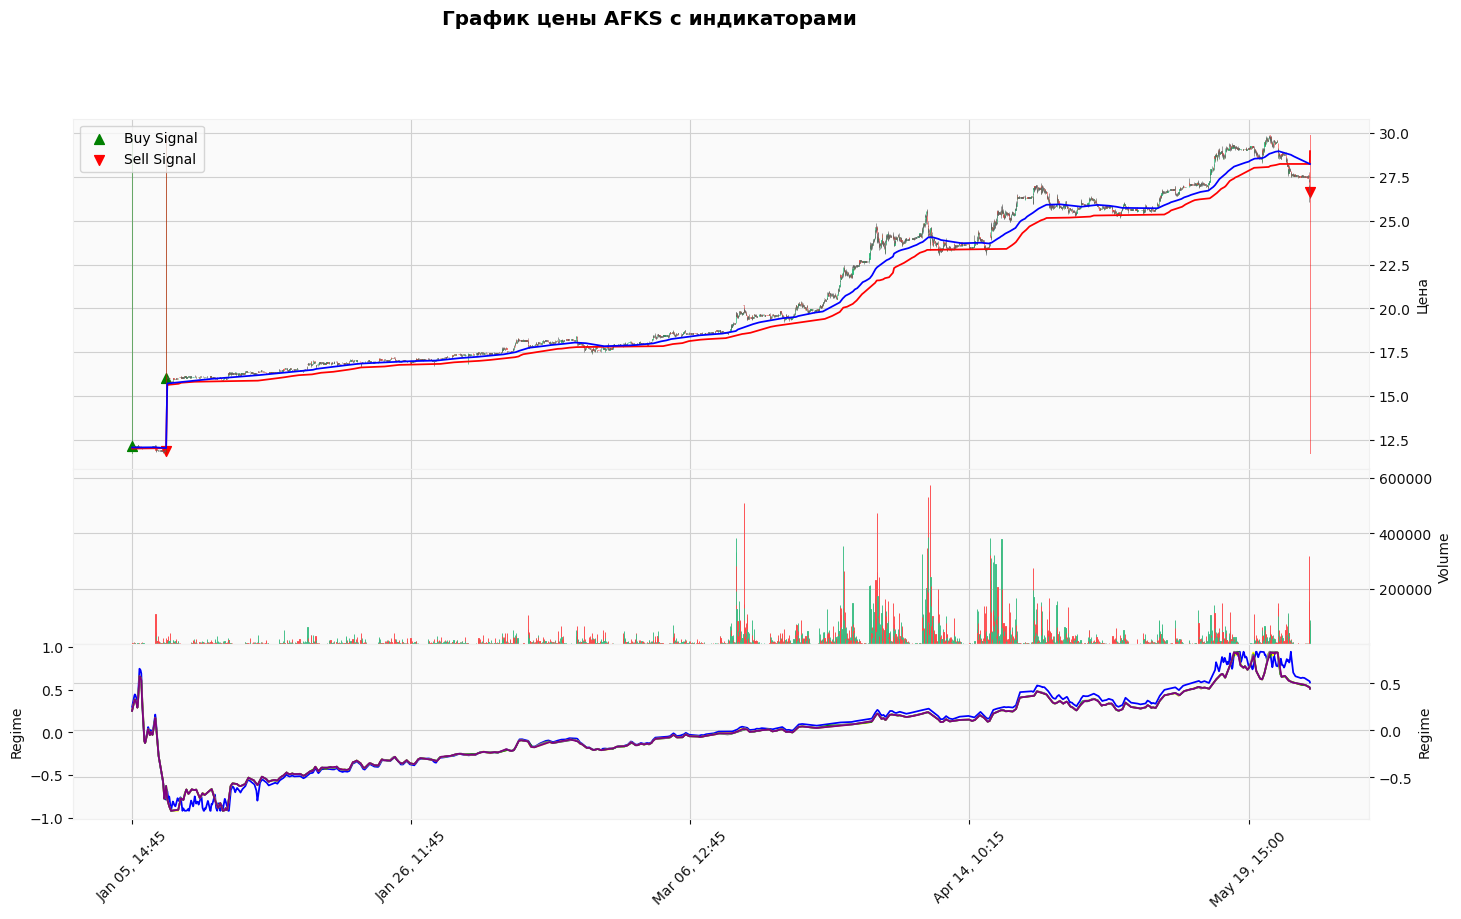

In [403]:
plot_price_with_indicators_mplfinance(df_phase.loc[gh[gh['batch'].isin(test_batches[-6:-4])].index], ticker, regime='P')

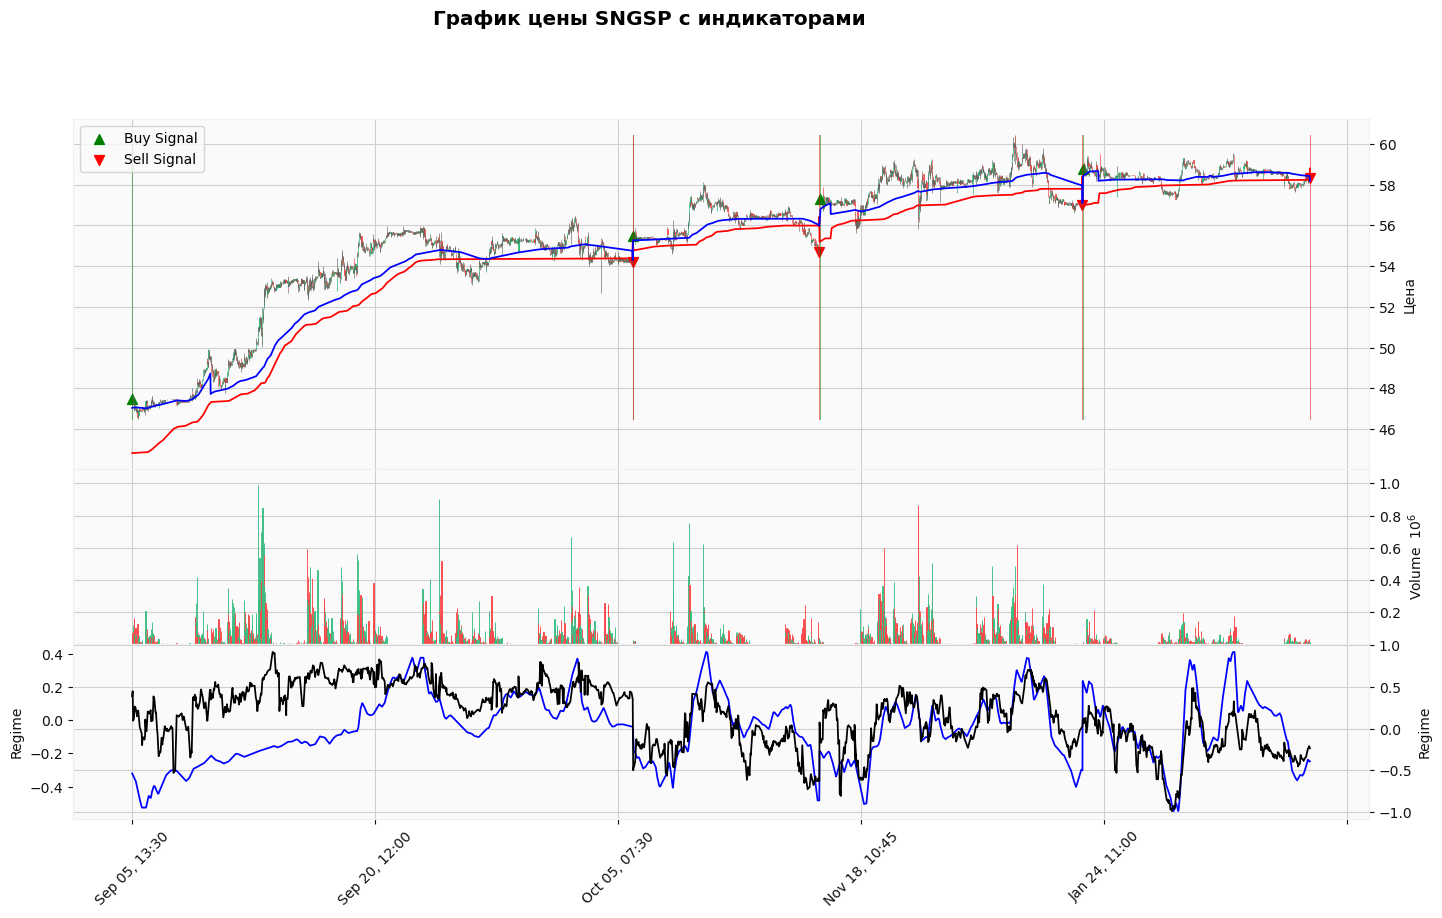

In [264]:
plot_price_with_indicators_mplfinance(df_phase.loc[gh[gh['batch'].isin(test_batches[-4:])].index], ticker, regime='P')

In [215]:
import numpy as np, pandas as pd, joblib, warnings, json
from lightgbm                 import LGBMRegressor
from sklearn.compose          import ColumnTransformer
from sklearn.pipeline         import Pipeline
from sklearn.preprocessing    import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn.model_selection  import KFold
from sklearn.metrics          import (mean_squared_error, r2_score,
                                      make_scorer, get_scorer)
warnings.filterwarnings('ignore')
path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long' #test_files_15_2  data_long
directions = ['minimize', 'minimize', 'minimize', 'maximize', 'minimize']

# helper ───────────────────────────────────────────────────────────
def to_dense(X):
    # LightGBM «любит» плотные матрицы
    return X.toarray() if hasattr(X, 'toarray') else X

def corrcoef(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0, 1]

corr_scorer = make_scorer(corrcoef, greater_is_better=True)

# ──────────────────────────────────────────────────────────────────
# 1. ГРУППОВОЕ РАЗБИЕНИЕ ПО БАТЧАМ
def batch_kfold_indices(batches: np.ndarray, n_splits=3, rnd=42):
    """
    Генерирует пары (train_idx, test_idx), причём один и тот же batch
    никогда не окажется и в train, и в test.
    """
    rng = np.random.default_rng(rnd)
    uniq_batches = pd.unique(batches[~pd.isna(batches)])
    rng.shuffle(uniq_batches)

    kf = KFold(n_splits=n_splits, shuffle=False)
    for train_b, test_b in kf.split(uniq_batches):
        train_mask = np.isin(batches, uniq_batches[train_b])
        test_mask  = np.isin(batches, uniq_batches[test_b])
        yield np.where(train_mask)[0], np.where(test_mask)[0]

# ──────────────────────────────────────────────────────────────────
# 2. ДАННЫЕ + ПРИЗНАКИ
ticker         = 'X5'
phase_json     = json.load(open('phase_ful_tickers_params.txt'))
opt_phase      = phase_json[ticker]['params']

# --- Optuna объекты ------------------------------------------------
db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params_long/{ticker}.db"
db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/out_try/{ticker}.db"

import optuna
study_phase = optuna.load_study(f'feature_hyperparam_search_{ticker}',
                                storage=db_path)
study_model = optuna.load_study(f'feature_hyperparam_search_{ticker}',
                                storage=db_path_model)

best_score, best_num, best_params, best_values, best_norm = \
    find_best_trial_equal_importance(study_phase.trials, directions)
best_score_model, best_num_model, best_params_model, best_values_model, best_norm_model = \
    find_best_trial_equal_importance(study_model.trials, directions)

phase_trial  = study_phase.trials[best_num]
model_trial  = study_model.trials[best_num_model]

feature_params = sample_feature_params(phase_trial.params)
lgb_params     = model_trial.params | dict(random_state=42,
                                           verbosity   =-1)

# --- исходный датасет ----------------------------------------------
file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]
df_raw   = pd.read_parquet(os.path.join(path, file_name))

# --- сигналы / таргет ----------------------------------------------
window   = int(opt_phase['moving_average_length']*9.5)
features = extract_features(df_raw, window=window)
scaled = joblib.load("scaler_global.pkl").transform(features)
labels = joblib.load("kmeans_global.pkl").predict(scaled)
regime_series = pd.Series(labels, index=df_raw.index)
window_size = int(opt_phase['atr_period']*5.5)
smoother = FastRollingMode(window_size=window_size)
smoothed = [smoother.update(x) for x in labels]
smoothed_regime = pd.Series(smoothed, index=df_phase.index)

regime_params = prepare_regime_params(opt_phase)

ats   = AdaptiveTradingSystem(regime_params['base_params'])
df_s  = ats.generate_adaptive_signals(df_raw, regime_series=smoothed_regime)
buy_signals = df_s[df_s['buy_signal']]
sell_signals = df_s[df_s['sell_signal']]
for _, buy in buy_signals.iterrows():
    sell = sell_signals[sell_signals.time > buy.time].head(1)
    if not sell.empty:
        df_s.loc[buy.name, "event_time"] = buy.time
        df_s.loc[buy.name, "event_price"] = buy.close
        df_s.loc[buy.name, "event_sell_time"] = sell.time.values[0]
        df_s.loc[buy.name, "event_sell_price"] = sell.close.values[0]

df_s['pnl'] = ((df_s['event_sell_price'] * (1 - 0.003)) / (df_s['event_price'] * (1 + 0.003)) - 1) * 100
df_s['regime'] = smoothed_regime
df_s  = calculate_target(df_s, threshold=1.9)
df_s  = calculate_smoothed_target(df_s)

# --- признаки -------------------------------------------------------
gh     = calculate_indicators(df_s, feature_params)
gh     = gh[gh['normalized_target'].notna() & gh['batch'].notna()].copy()

x, y, preprocessing = prepare_data(gh, 'normalized_target')
groups = gh['batch'].unique()
groups_values = gh['batch'].values

# ──────────────────────────────────────────────────────────────────
# 3. ПАЙПЛАЙН
num_cols = x.select_dtypes(include=[np.number]).columns
cat_cols = x.select_dtypes(exclude=[np.number]).columns

pipe = Pipeline([
        ('prep', preprocessing),
        ('dens', FunctionTransformer(to_dense)),
        ('mdl' , LGBMRegressor(**lgb_params))
    ])

# ──────────────────────────────────────────────────────────────────
# 4. CROSS-VALIDATION
mse_l, r2_l, corr_l = [], [], []

for train_idx, test_idx in batch_kfold_indices(groups, n_splits=3, rnd=42):
    train_batches = gh['batch'].unique()[train_idx]
    test_batches = gh['batch'].unique()[test_idx]

    train_data_idx = gh[gh['batch'].isin(train_batches)].index
    test_data_idx = gh[gh['batch'].isin(test_batches)].index
    
    pipe.fit(x.loc[train_data_idx], y.loc[train_data_idx])

    yp = pipe.predict(x.loc[test_data_idx])

    mse_l .append(mean_squared_error(y.loc[test_data_idx], yp))
    r2_l  .append(r2_score(y.loc[test_data_idx], yp))
    corr_l.append(corrcoef     (y.loc[test_data_idx], yp))

print('─ CV (3 батч-фолда) ─────────────')
print(f'MSE   : {np.mean(mse_l):.5f} ± {np.std(mse_l):.5f}')
print(f'R²    : {np.mean(r2_l) :.5f} ± {np.std(r2_l) :.5f}')
print(f'Corr  : {np.mean(corr_l):.5f} ± {np.std(corr_l):.5f}')

# ──────────────────────────────────────────────────────────────────
# 5. HOLD-OUT (25 % последних batch’ей)
uniq_batches = np.sort(pd.unique(groups))
hold_batches = uniq_batches[int(len(uniq_batches)*0.65):]

hold_mask    = np.isin(groups_values, hold_batches)

pipe.fit(x.loc[~hold_mask], y.loc[~hold_mask])
y_hold_pred  = pipe.predict(x.loc[hold_mask])

print('\n─ HOLD-OUT (25 % батчей) ───────')
print('MSE  :', mean_squared_error(y.loc[hold_mask], y_hold_pred))
print('R²   :', r2_score         (y.loc[hold_mask], y_hold_pred))
print('Corr :', corrcoef         (y.loc[hold_mask], y_hold_pred))

# ──────────────────────────────────────────────────────────────────
# 6. СОХРАНЯЕМ модель + прогнозы для графика
#joblib.dump(pipe, f'{ticker}_best_pipeline.pkl')

gh['y_pred'] = pipe.predict(x)               # прогноз по всем строкам
df_phase.loc[gh.index, 'predicted_p'] = gh['y_pred']

─ CV (3 батч-фолда) ─────────────
MSE   : 0.11476 ± 0.01129
R²    : 0.25187 ± 0.05578
Corr  : 0.52186 ± 0.04559

─ HOLD-OUT (25 % батчей) ───────
MSE  : 0.12222550108372687
R²   : 0.21773011244057194
Corr : 0.5544054505999598


In [ ]:
class MachineLearningRSI:
    def __init__(self,
                 rsi_length=300,
                 use_smoothing=True,
                 smoothing_length=268,
                 smoothing_type='ALMA',
                 alma_sigma=6,
                 rsi_overbought=70,
                 rsi_oversold=30,
                 use_knn=True,
                 knn_neighbors=7,
                 knn_lookback=500,
                 knn_weight=0.6,
                 feature_count=5,
                 use_filter=True,
                 filter_method='Kalman',
                 filter_strength=0.7,
                 sma_length=20 + 7*24*4*3,
                 ema_length=21 + 7*24*4*3
                 ):

        # Базовые параметры
        self.rsi_length = rsi_length
        self.use_smoothing = use_smoothing
        self.smoothing_length = smoothing_length
        self.smoothing_type = smoothing_type
        self.alma_sigma = alma_sigma

        # Пороговые уровни
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold

        # Параметры KNN
        self.use_knn = use_knn
        self.knn_neighbors = knn_neighbors
        self.knn_lookback = knn_lookback
        self.knn_weight = knn_weight
        self.feature_count = feature_count

        # Фильтрация
        self.use_filter = use_filter
        self.filter_method = filter_method
        self.filter_strength = filter_strength

        self.sma_length = sma_length
        self.ema_length = ema_length

    def calculate_rsi(self, close: pd.Series, length: int) -> pd.Series:
        """Расчет RSI через RMA аналогично PineScript ta.rsi"""
        delta = close.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        avg_loss = loss.ewm(alpha=1/length, min_periods=length, adjust=False).mean()
        rs = avg_gain / avg_loss
        rsi = 100 - (100 / (1 + rs))
        return rsi

    def smooth(self, series: pd.Series) -> pd.Series:
        """Корректный ALMA"""
        if self.smoothing_type == 'SMA':
            return series.rolling(self.smoothing_length).mean()
        elif self.smoothing_type == 'EMA':
            return series.ewm(span=self.smoothing_length, adjust=False).mean()
        elif self.smoothing_type == 'ALMA':
            m = self.smoothing_length
            offset = 0.85
            sigma = self.alma_sigma

            def alma(series):
                window = np.arange(m)
                weights = np.exp(-((window - offset * (m-1))**2) / (2*(sigma**2)))
                weights /= weights.sum()
                return np.convolve(series, weights, mode='valid')

            def alma_causal(series: pd.Series, length: int = 9, offset: float = 0.85, sigma: float = 6) -> pd.Series:
                """
                Казуальная реализация ALMA (Arnaud Legoux Moving Average)
                Использует только прошлые и текущие значения, без lookahead bias.
                """
                if length > len(series):
                    return pd.Series(np.nan, index=series.index)

                # Предвычисление весов ALMA
                window = np.arange(length)
                m = offset * (length - 1)
                s = length / sigma
                weights = np.exp(-((window - m) ** 2) / (2 * s ** 2))
                weights /= weights.sum()

                # Применяем ALMA казуально (rolling + dot product)
                alma_vals = []
                for i in range(length - 1, len(series)):
                    window_data = series.iloc[i - length + 1:i + 1]
                    if window_data.isnull().any():
                        alma_vals.append(np.nan)
                    else:
                        alma_vals.append(np.dot(weights, window_data.values))

                # Паддинг NaN в начало, чтобы сохранить индекс
                alma_series = pd.Series([np.nan] * (length - 1) + alma_vals, index=series.index)

                return alma_series

            alma_series = alma_causal(series.fillna(method='ffill'), m, offset, sigma)#, index=series.index[pad:-pad])
            #alma_series = alma_series.reindex(series.index, method='nearest')
            return alma_series
        else:
            return series

    def feature_extraction(self, close: pd.Series, rsi: pd.Series) -> pd.DataFrame:
        """Извлечение признаков для KNN"""
        features = pd.DataFrame(index=close.index)
        features['rsi'] = self.normalize(rsi, self.knn_lookback)

        if self.feature_count >= 2:
            features['momentum_rsi'] = self.normalize(rsi.diff(3), self.knn_lookback)
        if self.feature_count >= 3:
            features['volatility_rsi'] = self.normalize(rsi.rolling(10).std(), self.knn_lookback)
        if self.feature_count >= 4:
            features['slope_rsi'] = self.normalize(self.get_slope(rsi, 5), self.knn_lookback)
        if self.feature_count >= 5:
            features['momentum_price'] = self.normalize(close.diff(5), self.knn_lookback)

        return features.dropna()

    def normalize(self, series: pd.Series, period: int) -> pd.Series:
        """Мин-макс нормализация"""
        min_val = series.rolling(period).min()
        max_val = series.rolling(period).max()
        norm = (series - min_val) / (max_val - min_val)
        return norm.clip(0, 1)

    def get_slope(self, series: pd.Series, window: int) -> pd.Series:
        """Расчет наклона линейной регрессии"""
        idx = np.arange(window)
        def linreg(x):
            A = np.vstack([idx, np.ones(len(idx))]).T
            m, c = np.linalg.lstsq(A, x, rcond=None)[0]
            return m
        return series.rolling(window).apply(linreg, raw=True)

    def apply_knn(self, features: pd.DataFrame, rsi: pd.Series) -> pd.Series:
        """
        Оптимизированная, но идентичная оригиналу версия KNN.
        Сохраняет точную математику оригинального apply_knn_b с ускорением через BallTree.
        """
        # Сохраняем структуру как в оригинале
        full_index = rsi.index
        common_index = features.index.intersection(rsi.index)
        features = features.loc[common_index]
        rsi = rsi.loc[common_index]

        enhanced_rsi = pd.Series(index=full_index, data=np.nan)
        enhanced_rsi.loc[rsi.index] = rsi

        if len(features) < self.knn_lookback:
            return enhanced_rsi

        feature_array = features.values
        rsi_array = rsi.values

        # Основное изменение: BallTree строится на скользящем окне
        for t in range(self.knn_lookback, len(feature_array)):
            window_start = t - self.knn_lookback
            window_end = t
            X_window = feature_array[window_start:window_end]
            y_window = rsi_array[window_start:window_end]

            # Строим дерево только на текущем окне
            tree = BallTree(X_window, metric='euclidean')
            distances, indices = tree.query(feature_array[t].reshape(1, -1),
                                          k=self.knn_neighbors)

            # Точное воспроизведение оригинальной логики взвешивания
            weights = np.where(distances[0] < 1e-6, 1.0, 1.0 / distances[0])
            prediction = np.average(y_window[indices[0]], weights=weights)

            idx = common_index[t]
            enhanced_rsi.loc[idx] = (1 - self.knn_weight) * rsi.loc[idx] + self.knn_weight * prediction

        return enhanced_rsi

    def kalman_filter(self, series: pd.Series) -> pd.Series:
        """Калман-фильтр с параметрами ближе к PineScript"""
        n = len(series)
        xhat = np.full(n, np.nan)
        P = np.zeros(n)
        R = self.filter_strength * 0.1  # Очень маленький measurement noise
        Q = self.filter_strength * 0.01  # Очень маленький process noise

        first_valid_idx = series.first_valid_index()
        if first_valid_idx is None:
            return pd.Series(xhat, index=series.index)

        first_idx = series.index.get_loc(first_valid_idx)
        xhat[first_idx] = series.iloc[first_idx]
        P[first_idx] = 1.0

        for k in range(first_idx + 1, n):
            if np.isnan(series.iloc[k]):
                xhat[k] = xhat[k - 1]
                P[k] = P[k - 1] + Q
            else:
                xhatminus = xhat[k-1]
                Pminus = P[k-1] + Q
                K = Pminus / (Pminus + R)
                xhat[k] = xhatminus + K * (series.iloc[k] - xhatminus)
                P[k] = (1 - K) * Pminus

        return pd.Series(xhat, index=series.index)

    def filter_series(self, series: pd.Series) -> pd.Series:
        """Применение фильтрации к финальному RSI"""
        if self.filter_method == 'None':
            return series
        elif self.filter_method == 'Kalman':
            return self.kalman_filter(series)
        elif self.filter_method == 'DoubleEMA':
            ema1 = series.ewm(span=int(self.filter_strength * 10)).mean()
            ema2 = ema1.ewm(span=int(self.filter_strength * 5)).mean()
            return ema2
        elif self.filter_method == 'ALMA':
            return self.smooth(series)
        else:
            return series

    def week_level(self, close):
        sma_length = self.sma_length
        ema_length = self.ema_length

        # Вычисление 20-недельной SMA
        SMA_20w = close.rolling(window=sma_length, min_periods=1).mean()

        # Вычисление 21-недельной EMA
        MA_21w = close.ewm(span=ema_length, adjust=False).mean()

        return SMA_20w, MA_21w


    def fit(self, close: pd.Series) -> pd.Series:
        """Основная функция расчёта"""
        rsi = self.calculate_rsi(close, self.rsi_length)
        if self.use_smoothing:
            rsi = self.smooth(rsi)
        if self.use_knn:
            features = self.feature_extraction(close, rsi)

            rsi = self.apply_knn(features, rsi)

        if self.use_filter:
            rsi = self.filter_series(rsi)

        sma, ma = self.week_level(close)

        return rsi.clip(0, 100), sma, ma

In [472]:
отрасль.values()

dict_values(['health', 'consumer', 'financial', 'consumer', 'materials', 'materials', 'consumer', 'consumer', 'energy', 'energy', 'consumer', 'materials', 'financial', 'financial', 'financial', 'materials', 'materials', 'it', 'telecom', 'telecom', 'it', 'it', 'utilities', 'energy', 'it', 'materials', 'real', 'real', 'industrials', 'utilities', 'industrials', 'financial', 'energy', 'consumer', 'health', 'health', 'materials', 'industrials', 'it', 'consumer', 'utilities', 'utilities', 'industrials', 'it', 'materials', 'materials', 'utilities', 'consumer', 'industrials', 'energy', 'consumer', 'other', 'other', 'materials', 'materials', 'other', 'consumer', 'health', 'energy', 'materials', 'materials', 'utilities', 'real', 'materials', 'financial', 'consumer', 'telecom', 'financial', 'utilities', 'utilities', 'utilities', 'utilities', 'utilities', 'utilities', 'utilities', 'utilities', 'utilities', 'industrials', 'materials', 'materials', 'telecom', 'consumer', 'industrials', 'materials', 

In [533]:
отрасль = {}
gl = [i.split('_CANDLE_INTERVAL')[0]  for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long')]
for i in gl:
    отрасль[i.split('_')[0]] = i.split('_')[1]
tickers_to_search = []
for key, item in отрасль.items():
    if item == 'consumer':
        tickers_to_search.append(key)

In [596]:
ticker = 'CNRU'
    
path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long' #test_files_15_2  data_long
with open('phase_ful_tickers_params.txt', 'r') as file:
    phase_df = json.load(file)

file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]#test_files_15_2  data_long
df_phase = pd.read_parquet(os.path.join(path, file_name))

In [597]:
df_phase

,time,open,close,high,low,volume
0,2021-11-05 20:00:00+00:00,1250.6,1240.4,1250.6,1232.2,36048
1,2021-11-05 20:15:00+00:00,1240.4,1213.0,1240.4,1205.2,36467
2,2021-11-05 20:30:00+00:00,1213.0,1213.6,1219.0,1208.6,31569
3,2021-11-05 20:45:00+00:00,1213.6,1220.0,1220.0,1209.0,25760
4,2021-11-05 21:00:00+00:00,1219.2,1222.2,1230.0,1214.2,45053
...,...,...,...,...,...,...
53211,2025-07-15 15:15:00+00:00,562.0,561.0,563.2,560.8,2426
53212,2025-07-15 15:30:00+00:00,560.8,559.4,561.8,558.2,1813
53213,2025-07-15 15:45:00+00:00,560.4,558.0,561.4,557.2,5968
53214,2025-07-15 16:00:00+00:00,558.4,558.2,559.0,558.0,1161


In [961]:
close_vol = {}
volume_vol = {}
for i in tqdm(tickers_to_search):
    ticker = i
    
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long' #test_files_15_2  data_long
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params/{ticker}.db"
    db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/out_try/{ticker}.db"
    study_phase = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path, load_if_exists=True)
    study_model = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path_model, load_if_exists=True)
    
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]#test_files_15_2  data_long
    df_phase = pd.read_parquet(os.path.join(path, file_name))
    close_vol[ticker] = df_phase.iloc[-7000:]['close'].values
    volume_vol[ticker] = df_phase.iloc[-7000:]['volume'].values

  0%|          | 0/18 [00:00<?, ?it/s]

In [1029]:
import os, glob, pandas as pd

ROOT = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long'
TICKERS = [i.split('_')[0] for i in os.listdir(ROOT)]
TAIL    = 10_000                     # берём чуть больше баров
MIN_LIQ = 200                       # сколько баров оставить

def load_one(tick: str) -> pd.DataFrame:
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]
    file = glob.glob(f'{ROOT}\\{file_name}')[0]
    df   = pd.read_parquet(file)\
             .set_index('time')\
             .sort_index()[['open','high','low','close','volume']]
    return df

raw = {t: load_one(t) for t in tqdm(TICKERS)}
raw = {t: d for t, d in raw.items() if d.volume.mean() >= MIN_LIQ}

calendar = pd.Index(sorted(set().union(*(d.index for d in raw.values()))),
                    name='time')
aligned = {t: d.reindex(calendar).ffill(limit=2) for t, d in raw.items()}

100%|██████████| 166/166 [00:03<00:00, 50.87it/s]


In [180]:
import os, glob, pandas as pd, numpy as np
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
import hdbscan
from sklearn.metrics import silhouette_score

ROOT = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long'
TICKERS = [i.split('_')[0] for i in os.listdir(ROOT)]#tickers_to_search          # список ваших тикеров
BAR_LIMIT = 7_000                    # сколько последних баров берём
MIN_LIQ = 200   # мин. средний объём за бар

class FeatureCalc:
    """урезанная версия вашего FeatureCalculatorForRegression"""
    def __init__(self, df: pd.DataFrame):
        self.df = df.copy()

    def run(self) -> pd.DataFrame:
        out = pd.DataFrame(index=self.df.index)

        # ---- log-доходности и волатильность ---------------------------------
        logp = np.log(self.df.close).replace([-np.inf, np.inf], np.nan)
        out['ret_1']   = logp.diff()
        out['ret_10']  = logp.diff(10)
        out['vol_20']  = out.ret_1.rolling(20).std()

        # ---- MACD нормированный ---------------------------------------------
        ema12 = self.df.close.ewm(span=12, adjust=False).mean()
        ema26 = self.df.close.ewm(span=26, adjust=False).mean()
        macd  = (ema12 - ema26) / (ema26 + 1e-9)
        out['macd'] = macd

        # ---- RSI ------------------------------------------------------------
        delta = self.df.close.diff()
        gain  = delta.clip(lower=0)
        loss  = (-delta).clip(lower=0)
        rs    = gain.rolling(14).mean() / (loss.rolling(14).mean() + 1e-9)
        out['rsi'] = 100 - 100 / (1 + rs)

        # ---- Price–MA distance ----------------------------------------------
        ma200 = self.df.close.ewm(span=200, adjust=False).mean()
        out['madist'] = (self.df.close / ma200 - 1)

        # ---- OBV нормированный ----------------------------------------------
        direction = np.sign(self.df.close.diff().fillna(0))
        obv = (self.df.volume * direction).cumsum()
        out['obv_norm'] = obv / (obv.rolling(200).std() + 1e-9)

        return out.astype(np.float32)

def calc_features_for_one(args):
    tick, df = args
    fc = FeatureCalc(df.iloc[-TAIL:])      # считаем только хвост
    return tick, fc.run()

def load_one(ticker: str) -> pd.DataFrame:
    """Читаем parquet → индекс datetime, сортируем."""
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\data_long') if ticker == i.split('_')[0]][0]
    file = glob.glob(f'{ROOT}\\{file_name}')[0]
    df   = pd.read_parquet(file)
    df   = (df
            .set_index('time')       # или 'date', как в файле
            .sort_index())
    return df[['close', 'volume']]

# 1. читаем
raw = {t: load_one(t) for t in tqdm(TICKERS)}

# 2а. фильтруем по ликвидности сразу, чтобы не тянуть «пустышки»
raw = {t: df for t, df in raw.items()
       if df['volume'].mean() >= MIN_LIQ}

# 2b. общий календарь
calendar = pd.Index(sorted(
    set().union(*(df.index for df in raw.values()))
), name='time')

# 3. выравниваем (ffill за 1-2 бара, дальше NaN)
aligned = {t: (df.reindex(calendar)
               .ffill(limit=2))         # не тянем сквозь большие дырки
           for t, df in raw.items()}

# 4. берём «хвост» календаря
calendar_tail = calendar[-BAR_LIMIT:]

close_dict  = {t: df.loc[calendar_tail, 'close']  for t, df in aligned.items()}
vol_dict = {t: df.loc[calendar_tail, 'volume'] for t, df in aligned.items()}

  0%|          | 0/166 [00:00<?, ?it/s]

In [190]:
def _intra_inter_score(corr: pd.DataFrame, lbl: np.ndarray) -> float:
    s = pd.Series(lbl, index=corr.index)
    intra, inter = [], []
    for g in s.unique():
        m = corr.loc[s == g, s == g]
        if len(m) > 1:
            intra.extend(m.values[np.triu_indices_from(m, 1)])
    for g1 in s.unique():
        for g2 in s.unique():
            if g1 >= g2:
                continue
            inter.append(corr.loc[s == g1, s == g2].values.mean())
    return (np.nanmean(intra) if intra else np.nan) - (np.nanmean(inter) if inter else np.nan)


def cluster_by_correlation_dict(
    close_dict: dict[str, pd.Series],
    lookback: int = 500,
    min_members: int = 3,
    k_range: range = range(3, 15),
) -> dict[str, str]:
    # 1) dict → DataFrame   (колонки = тикеры)
    close_df = pd.concat(close_dict, axis=1).astype(float)

    # 2) лог-доходности
    ret = np.log(close_df.iloc[-lookback:]).diff().iloc[1:]
    if ret.shape[1] < 2:
        raise ValueError("Нужно ≥2 тикеров для кластеризации.")

    # 3) усаженная ковариация → корреляция
    #    X: n_samples × n_features  ⇒  T × N  (T≈499, N=число тикеров)
    X   = ret.fillna(0.).values          # ← БЕЗ .T  !!
    cov = LedoitWolf().fit(X).covariance_
    d   = np.sqrt(np.diag(cov))
    corr = pd.DataFrame(cov / d[:, None] / d[None, :],
                        index=ret.columns, columns=ret.columns)

    # 4) расстояния
    dist = np.sqrt(2 * (1 - corr.clip(-1, 1)))
    dist = (dist + dist.T) / 2
    np.fill_diagonal(dist.values, 0.0)

    # 5) linkage
    Z = linkage(squareform(dist.values, checks=False), method="average")

    # 6) выбор k
    best_lbl, best_score = None, -np.inf
    for k in k_range:
        lbl = fcluster(Z, t=k, criterion="maxclust")
        score = _intra_inter_score(corr, lbl)
        if score > best_score:
            best_score, best_lbl = score, lbl

    ser = pd.Series(best_lbl, index=ret.columns)

    # 7) mapping
    out = {}
    for g, members in ser.groupby(ser):
        key = f"clust_{g}" if len(members) >= min_members else "_noise"
        out.update({t: key for t in members.index})

    return out

In [202]:
def strip_market_mode(ret: pd.DataFrame, n_pc: int = 1) -> pd.DataFrame:
    """
    Убирает n_pc главных компонент из доходностей.
    Пропуски заполняются 0 только на время PCA, затем восстанавливаются.
    """
    X_filled = ret.fillna(0.).values        # T × N
    pca   = PCA(n_components=n_pc, svd_solver='full').fit(X_filled)
    proj  = pca.transform(X_filled) @ pca.components_
    resid = X_filled - proj                 # очищенные доходности

    clean = pd.DataFrame(resid, index=ret.index, columns=ret.columns)
    clean[ret.isna()] = np.nan              # возвращаем прежние NaN
    return clean
def _score(corr, lbl):
    s = pd.Series(lbl, index=corr.index)
    intra, inter = [], []
    for g in s.unique():
        m = corr.loc[s == g, s == g]
        if len(m) > 1:
            intra.extend(m.values[np.triu_indices_from(m, 1)])
    for g1 in s.unique():
        for g2 in s.unique():
            if g1 >= g2:
                continue
            inter.append(corr.loc[s == g1, s == g2].values.mean())
    return np.nanmean(intra) - np.nanmean(inter)


def cluster_by_corr(
    close_dict: dict[str, pd.Series],
    lookback: int = 500,
    min_members: int = 3,
    target_k: int | None = None,
    max_cluster_share: float | None = 0.40,
    remove_market_mode: bool = True,
    k_range: range = range(3, 25),
) -> dict[str, str]:
    # 1) dict → DataFrame
    close = pd.concat(close_dict, axis=1).astype(float)

    # 2) лог-доходности
    ret = np.log(close.iloc[-lookback:]).diff().iloc[1:]

    # 3) убираем market-mode
    if remove_market_mode:
        ret = strip_market_mode(ret, n_pc=1)

    # 4) корреляция Ledoit-Wolf
    X = ret.fillna(0.).values            # T × N
    cov = LedoitWolf().fit(X).covariance_
    d = np.sqrt(np.diag(cov))
    corr = pd.DataFrame(cov / d[:, None] / d[None, :],
                        index=ret.columns, columns=ret.columns)

    # 5) расстояния Mantegna
    dist = np.sqrt(2 * (1 - corr.clip(-1, 1)))
    dist = (dist + dist.T) / 2
    np.fill_diagonal(dist.values, 0.0)

    Z = linkage(squareform(dist, checks=False), method='average')

    # 6) перебор k
    best_lbl, best_score = None, -np.inf
    for k in k_range:
        if target_k is not None and k != target_k:
            continue
        lbl = fcluster(Z, t=k, criterion='maxclust')
        if max_cluster_share is not None:
            if np.bincount(lbl)[1:].max() / len(lbl) > max_cluster_share:
                continue
        scr = _score(corr, lbl)
        if scr > best_score:
            best_score, best_lbl = scr, lbl

    if best_lbl is None:                         # всё отфильтровали по share
        best_lbl = fcluster(Z, t=max(k_range), criterion='maxclust')

    ser = pd.Series(best_lbl, index=ret.columns)

    # 7) mapping
    out = {}
    for g, mem in ser.groupby(ser):
        key = f'clust_{g}' if len(mem) >= min_members else '_noise'
        out.update({t: key for t in mem.index})

    return out

In [203]:
import scipy
import numpy as np, pandas as pd, scipy
from sklearn.covariance import LedoitWolf
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
ticker2sector = cluster_by_corr(
        close_dict,
        lookback          = 700,     # возьмите побольше истории
        target_k          = 8,       # хочу ~8 кластеров
        max_cluster_share = 0.25,    # ни один >25 %
        remove_market_mode= True,
)

In [204]:
from collections import Counter
print(Counter(ticker2sector.values()))

Counter({'clust_17': 69, '_noise': 17, 'clust_16': 11, 'clust_7': 8, 'clust_13': 6, 'clust_15': 5, 'clust_8': 4, 'clust_14': 4, 'clust_21': 4, 'clust_4': 3, 'clust_11': 3, 'clust_12': 3, 'clust_18': 3, 'clust_20': 3})


In [975]:
from collections.abc import Mapping, Sequence
from typing import Optional, Literal

def update_sector_indices_old(
    close_price: Mapping[str, list | np.ndarray | pd.Series],
    volume: Mapping[str, list | np.ndarray | pd.Series],
    ticker2sector: Mapping[str, str],
    *,
    # --------- состояние от предыдущего вызова ------------------
    prev_level: Optional[pd.Series] = None,
    prev_close: Optional[Mapping[str, float]] = None,
    prev_volume: Optional[Mapping[str, float]] = None,
    # --------- параметры расчёта --------------------------------
    base: float = 1_000.,
    weight_mode: str = "vwap", # "vwap" | "equal" | "inv_vol"
    smooth_alpha: float | None = .20, # EWMA доходностей
    winsor: float | None = 0.07, # квантиль (0.05 → 5/95)
    winsor_window: int = 100, # сколько прошлых баров
    ewma_lambda: float | None = .9, # сглаживание объёмов
    iv_window: int = 96, # lookback для inv_vol
    min_members: int = 2,
    plot: bool = True
    ) -> tuple[pd.DataFrame, pd.Series, dict]:
    """
    Возвращает:
    level_df – DataFrame (новые строки индексов)
    last_level – pd.Series (уровень после последнего бара)
    last_state – dict { 'close': ..., 'volume': ... } для следующего вызова
    """
    # ---------- 0. dict -> DataFrame -----------------------------
    close_df  = pd.DataFrame(close_price, copy=False)
    volume_df = pd.DataFrame(volume,      copy=False)
    if close_df.empty:
        raise ValueError('close_price пуст')
    
    # ---------- 1. вставляем stub-строку T-1 ---------------------
    if prev_close is not None:
        stub_close  = pd.Series(prev_close).reindex(close_df.columns)
        stub_volume = pd.Series(prev_volume).reindex(volume_df.columns)
        close_df   = pd.concat([stub_close.to_frame().T, close_df])
        volume_df  = pd.concat([stub_volume.to_frame().T, volume_df])
    
    # ---------- 2. лог-доходности -------------------------------
    log_close = np.log(close_df)
    ret_df    = log_close.diff()      # NaN в stub
    ret_df    = ret_df.iloc[1:]       # убираем stub-строку
    
    # ---------- 3. causal winsorize ------------------------------
    if winsor is not None:
        q_low  = ret_df.rolling(winsor_window, min_periods=1).quantile(winsor).shift(1)
        q_high = ret_df.rolling(winsor_window, min_periods=1).quantile(1-winsor).shift(1)
        ret_df = ret_df.clip(lower=q_low, upper=q_high, axis=0)
    
    # ---------- 4. живые секторы ---------------------------------
    sectors = {}
    for t in close_df.columns:
        sec = ticker2sector.get(t)
        if sec is None:
            raise KeyError(f'Нет сектора для {t}')
        sectors.setdefault(sec, []).append(t)
    sectors = {s: m for s, m in sectors.items() if len(m) >= min_members}
    if not sectors:
        raise RuntimeError('Нет секторов после фильтрации')
    
    # ---------- 5. веса ------------------------------------------
    if weight_mode == 'inv_vol':
        ivw = 1 / ret_df.rolling(iv_window, min_periods=10).std().shift(1)
        ivw.replace([np.inf, 0], np.nan, inplace=True)
    
    weights = {}
    for s, m in sectors.items():
        if weight_mode == 'equal':
            w = pd.DataFrame(1/len(m), index=ret_df.index, columns=m)
        elif weight_mode == 'vwap':
            v_raw = volume_df.shift(1)[m]              # объём прошлого бара
            if ewma_lambda:
                v_raw = v_raw.ewm(alpha=1-ewma_lambda, adjust=False).mean()
            w = v_raw.div(v_raw.sum(axis=1), axis=0)
        elif weight_mode == 'inv_vol':
            v_raw = ivw[m]
            w = v_raw.div(v_raw.sum(axis=1), axis=0)
        else:
            raise ValueError('weight_mode = equal | vwap | inv_vol')
        weights[s] = w.fillna(0.)
    
    # ---------- 6. секторные доходности --------------------------
    r_sec = pd.DataFrame(index=ret_df.index, columns=sectors, dtype=float)
    for s, m in sectors.items():
        r = (weights[s] * ret_df[m]).sum(axis=1)
        if smooth_alpha:
            r = r.ewm(alpha=smooth_alpha, adjust=False).mean()
        r_sec[s] = r
    
    # ---------- 7. кумуляция (chain-link) -------------------------
    start_level = (pd.Series(base, index=r_sec.columns)
                   if prev_level is None
                   else prev_level.reindex(r_sec.columns, fill_value=base))
    
    level_df = (r_sec.cumsum().apply(np.exp) * start_level).astype(float)
    
    # ---------- 8. подготовка состояния --------------------------
    last_level  = level_df.iloc[-1]
    last_state  = {'close': close_df.iloc[-1].to_dict(),
                   'volume': volume_df.iloc[-1].to_dict()}
    
    # ---------- 9. рисунок ---------------------------------------
    if plot:
        ax = level_df.plot(figsize=(12, 6), lw=1.2)
        ax.set(title=f'Отраслевые индексы (base={base}, weight={weight_mode})',
               xlabel='Бар', ylabel='Уровень')
        plt.tight_layout(); plt.show()
    
    return level_df, last_level, last_state
from collections.abc import Mapping, Sequence
from typing import Optional, Literal

# --------------------------------------------------------------
#  Индекс по первому главному компоненту («PC-1 сектор/factor»)
# --------------------------------------------------------------
def update_sector_indices(
    close_price:   Mapping[str, Sequence],
    volume:        Mapping[str, Sequence],
    *,
    ticker2sector: Mapping[str, str],

    # ------------------ НОВОЕ --------------------------------------
    state: Optional[dict] = None,
    # ---------------------------------------------------------------

    weight_mode: Literal[
        "equal", "vwap", "inv_vol",
        "median",
        "trim_mean"
    ] = "median",
    trim_q: float = 0.2,
    level_smooth_alpha: float = .12,
    base: float = 1_000.,
    winsor: float | None = .07,
    winsor_window: int = 100,
    iv_window: int = 96,
    min_members: int = 2,
    plot: bool = True,
):
    """
    Строит (или продолжает) отраслевые индексы.

    Если передан `state`, то функция считает новые бары как
    продолжение предыдущего расчёта.
    """

    # -------- 0. разбираем state / старые значения -----------------
    prev_level  = None
    prev_close  = None
    prev_volume = None
    if state is not None:
        prev_level  = state.get("level")
        prev_close  = state.get("close")
        prev_volume = state.get("volume")

    # -------- 1. dict → DataFrame ---------------------------------
    close_df  = pd.DataFrame(close_price, copy=False)
    volume_df = pd.DataFrame(volume,      copy=False)
    if not close_df.index.equals(volume_df.index):
        raise ValueError('Индексы close и volume не совпадают')
        
    if close_df.empty:
        raise ValueError("close_price пуст")

    # -------- 2. вставляем фиктивную строку T-1 --------------------
    if prev_close is not None:
        close_df  = pd.concat(
            [pd.DataFrame(prev_close,  index=[-1]), close_df], sort=False
        )
        volume_df = pd.concat(
            [pd.DataFrame(prev_volume, index=[-1]), volume_df], sort=False
        )

    # -------- 3. лог-доходности -----------------------------------
    log_close = np.log(close_df)
    ret_df    = log_close.diff().iloc[1:]

    # -------- 4. winsorisation ------------------------------------
    if winsor is not None:
        q_l = ret_df.rolling(winsor_window, 1).quantile(winsor).shift(1)
        q_h = ret_df.rolling(winsor_window, 1).quantile(1 - winsor).shift(1)
        ret_df = ret_df.clip(lower=q_l, upper=q_h)

    # -------- 5. формируем группы ---------------------------------
    sectors: dict[str, list[str]] = {}
    for t in close_df.columns:
        s = ticker2sector.get(t)
        if s is None:
            raise KeyError(f"Нет сектора для {t}")
        sectors.setdefault(s, []).append(t)
    sectors = {s: m for s, m in sectors.items() if len(m) >= min_members}
    if not sectors:
        raise RuntimeError("Нет секторов после фильтрации")

    # -------- 6. доходность сектора -------------------------------
    r_sec = pd.DataFrame(index=ret_df.index, columns=sectors, dtype=float)

    for s, members in sectors.items():

        if weight_mode == "median":
            r_sec[s] = ret_df[members].median(axis=1, skipna=True)

        elif weight_mode == "trim_mean":
            rs = ret_df[members]
            r_sec[s] = rs.apply(
                lambda row: row.sort_values().iloc[
                    int(trim_q * len(row)): int((1 - trim_q) * len(row))
                ].mean(),
                axis=1
            )

        elif weight_mode == "equal":
            r_sec[s] = ret_df[members].mean(axis=1)

        elif weight_mode == "vwap":
            #vw = volume_df.shift(1)[members]
            #w  = vw.div(vw.sum(axis=1), axis=0).fillna(0.)
            #r_sec[s] = (w * ret_df[members]).sum(axis=1)
            vw = volume_df.shift(1)[members]
            w  = vw.div(vw.sum(axis=1), axis=0)
            r_sec[s] = (w * ret_df[members]).sum(axis=1).where(w.sum(axis=1) > 0)

        elif weight_mode == "inv_vol":
            ivw = 1 / ret_df[members].rolling(iv_window, 10).std().shift(1)
            w   = ivw.div(ivw.sum(axis=1), axis=0).fillna(0.)
            r_sec[s] = (w * ret_df[members]).sum(axis=1)

        else:
            raise ValueError("bad weight_mode")

    # -------- 7. кумуляция ----------------------------------------
    start = (
        pd.Series(base, index=r_sec.columns)
        if prev_level is None
        else prev_level.reindex(r_sec.columns, fill_value=base)
    )
    level_df = np.exp(r_sec.cumsum()).mul(start, axis=1)

    # -------- 8. сглаживаем уровень -------------------------------
    if level_smooth_alpha:
        level_df = level_df.ewm(alpha=level_smooth_alpha, adjust=False).mean()

    # -------- 9. запоминаем состояние -----------------------------
    last_level = level_df.iloc[-1]
    new_state = {
        "level":  last_level,                    # ← понадобится в следующий раз
        "close":  close_df.iloc[-1].to_dict(),
        "volume": volume_df.iloc[-1].to_dict(),
    }

    # -------- 10. plot --------------------------------------------
    if plot:
        ax = level_df.plot(figsize=(12, 5), lw=1.2)
        ax.set(title=f"Sector index (base={base}, mode={weight_mode})",
               xlabel="Bar", ylabel="Level")
        plt.tight_layout(); plt.show()

    # возвращаем сам исторический DataFrame и новое состояние
    return level_df, new_state



In [1014]:
close_df = pd.concat(close_vol, axis=1)
log_ret  = np.log(close_df).diff().iloc[1:]            # T×N
ret_win  = log_ret.iloc[-5_000:]                      # окно для кластеризации

corr = ret_win.corr(min_periods=200)

In [1016]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance   import squareform

# корреляцию → дистанцию в [0, 1]
dist = np.sqrt(0.5 * (1 - corr))          # формула Мейерса

# linkage ожидает condensed-matrix, переводим:
Z = linkage(squareform(dist, checks=False), method='average')

# cut-threshold: 0.7 = средняя внутрикластерная корреляция ≈ 0.5
labels = fcluster(Z, t=0.7, criterion='distance')
cluster_of = dict(zip(corr.index, labels.astype(int)))

In [1023]:
ticker2sector_base = отрасль              # можно читать из JSON/CSV

MIN_INNER_CORR = 0.8          # порог «годится ли тикер к базовому сектору»

groups: dict[str, list[str]] = {}

for t in corr.index:
    base   = ticker2sector_base.get(t)        # может быть None
    dyn_id = f'clust_{cluster_of[t]}'

    if base is None:
        # нет отрасли → оставляем в динамическом кластере
        groups.setdefault(dyn_id, []).append(t)
        continue

    # средняя корреляция тикера с бумагами своего базового сектора
    peers = [m for m in corr.columns
             if ticker2sector_base.get(m) == base and m != t]
    ok = False
    if peers:
        ok = corr.loc[t, peers].mean() >= MIN_INNER_CORR

    target_group = base if ok else dyn_id
    groups.setdefault(target_group, []).append(t)

In [1028]:
print([len(i) for i in groups.values()])

[135, 2, 3, 3]


In [1025]:
def intra_corr(tickers):
    if len(tickers) < 2:
        return np.nan
    return corr.loc[tickers, tickers].where(
        ~np.eye(len(tickers), dtype=bool)
    ).stack().mean()

summary = (
    pd.Series({s: intra_corr(members) for s, members in groups.items()})
      .sort_values(ascending=False)
)
print(summary.head(20))

clust_4    0.120734
clust_3    0.080420
clust_2    0.039665
clust_1    0.027768
dtype: float64


In [976]:
'''state_level = None #state_level
state_close = None #state_close

level_part1, state_level1, state_close1 = update_sector_indices_old(
    close_price=close_vol,
    volume=volume_vol,
    ticker2sector=отрасль,
    prev_level=state_level,
    prev_close=state_close,
    base=1_000,              # будет использован только в самом начале
    smooth_alpha=.10
)'''

'state_level = None #state_level\nstate_close = None #state_close\n\nlevel_part1, state_level1, state_close1 = update_sector_indices_old(\n    close_price=close_vol,\n    volume=volume_vol,\n    ticker2sector=отрасль,\n    prev_level=state_level,\n    prev_close=state_close,\n    base=1_000,              # будет использован только в самом начале\n    smooth_alpha=.10\n)'

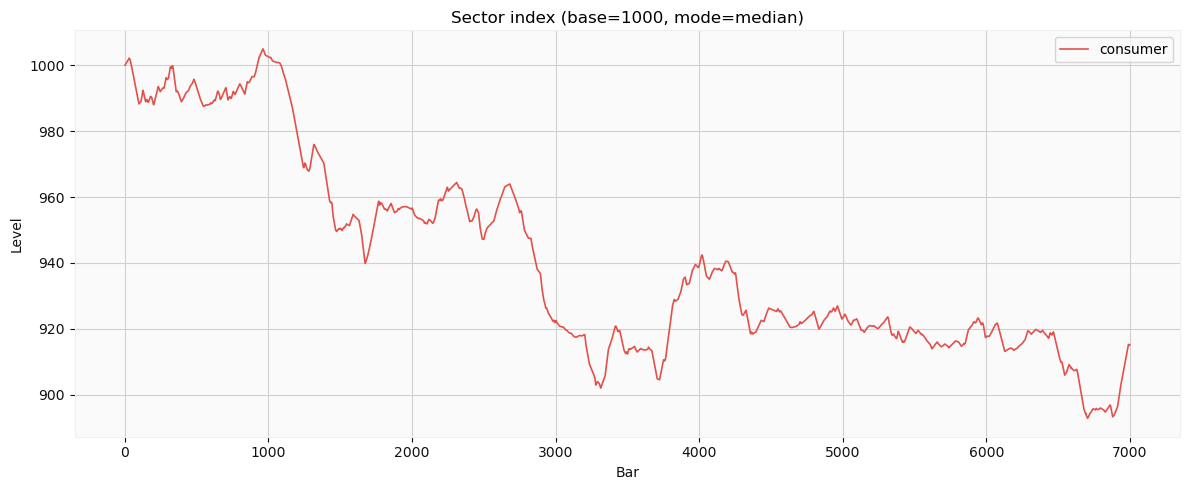

In [977]:
close_8000 = {ticker: array[:-2000] for ticker, array in close_vol.items()}
close_50 = {ticker: array[-2000:] for ticker, array in close_vol.items()}
volume_8000 = {ticker: array[:-2000] for ticker, array in volume_vol.items()}
volume_50 = {ticker: array[-2000:] for ticker, array in volume_vol.items()}
state = None
if state!=None:
    level_part, state = update_sector_indices(
        close_price=close_vol,
        volume=volume_vol,
        ticker2sector=отрасль,
        state = state,
        base=1_000,              # будет использован только в самом начале
        weight_mode   = 'median',      # попробуйте и 'trim_mean'
        trim_q        = 0.15,          # 15 % хвостов режем
        level_smooth_alpha = 0.13,      # гладкость уровня
    )
else:
    level_part, state = update_sector_indices(
        close_price=close_vol,
        volume=volume_vol,
        ticker2sector=отрасль,
        base=1_000,              # будет использован только в самом начале
        weight_mode   = 'median',      # попробуйте и 'trim_mean'
        trim_q        = 0.15,          # 15 % хвостов режем
        level_smooth_alpha = 0.08,      # гладкость уровня
    )

In [979]:
level_part.iloc[:-2000].reset_index(drop=False)['consumer'].corr(hist_level_df.reset_index(drop=False)['consumer'])

1.0

In [980]:
for i in close_vol.keys():
    print(i, level_part['consumer'].corr(pd.Series(close_vol[i])))

ABRD 0.6871627172088949
AFLT 0.862745233668854
APTK 0.8724451641901826
AQUA 0.9075953378568457
BELU 0.9002051646397297
GCHE 0.8820593364441657
HNFG 0.8727329312921075
KLVZ 0.8608931021320458
KROT 0.7578657060585401
LENT 0.4617858207939285
MGNT 0.951311378790406
MVID 0.9573354910643321
OKEY 0.93773165837227
ORUP 0.7876363595920127
RAGR 0.8898847696392426
SVAV 0.36305699656934654
VSEH 0.9268548146083324
X5 0.3695878330090397


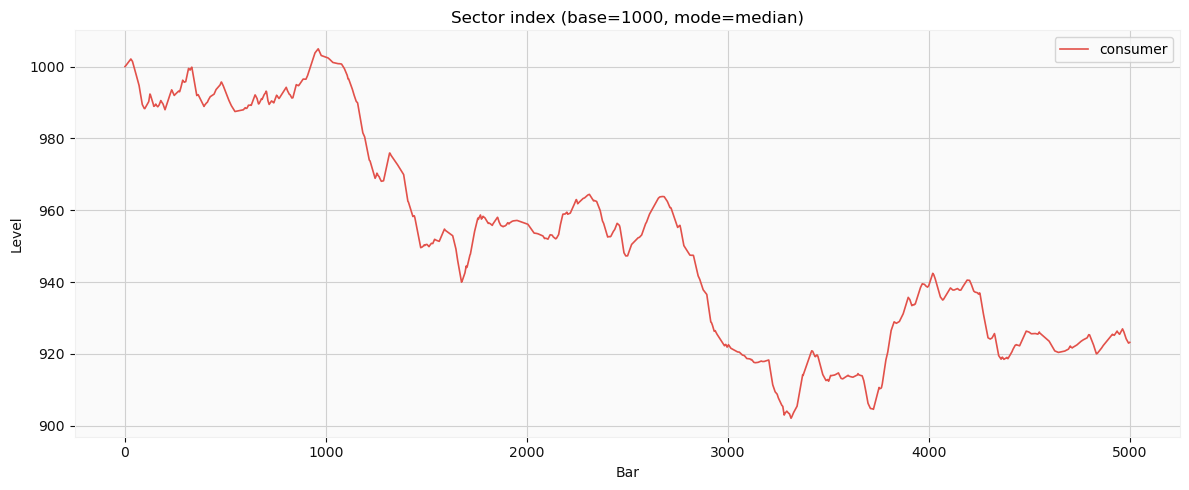

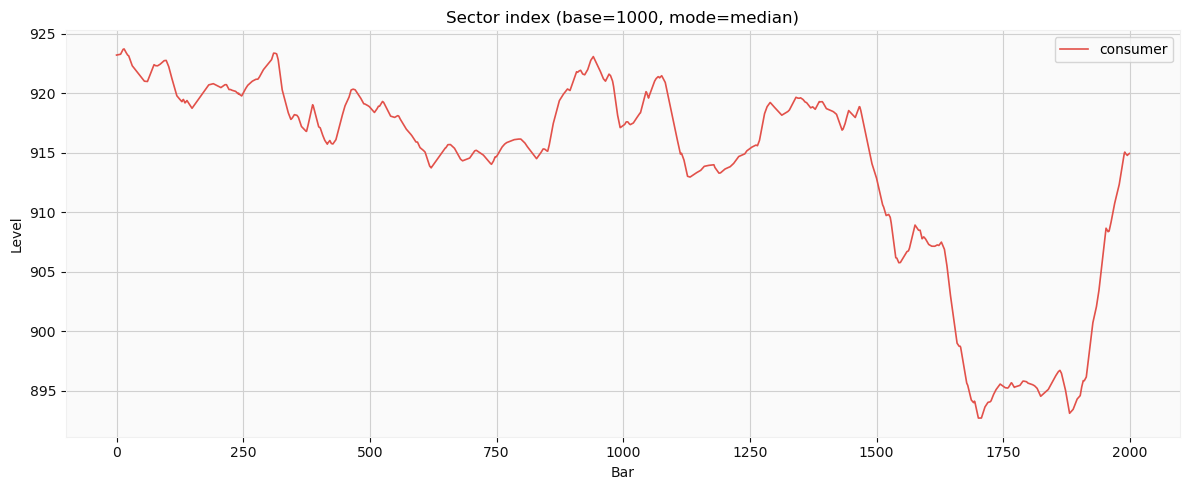

In [978]:
# первый прогон на исторических 7000 барах
hist_level_df, state = update_sector_indices(
    close_price   = close_8000,   # бары 0…6999
    volume        = volume_8000,
    ticker2sector = отрасль,
    weight_mode   = "median",
    base          = 1_000,
    state         = None,
    plot          = True,
    trim_q        = 0.15,          # 15 % хвостов режем
    level_smooth_alpha = 0.08, 
)

# имитируем «пришёл новый бар 7000»
level_7000, state = update_sector_indices(
    close_price   = close_50,     # только один новейший бар!
    volume        = volume_50,
    ticker2sector = отрасль,
    weight_mode   = "median",
    base          = 1_000,
    state         = state,          # ← передаём, что было
    plot          = True,
    trim_q        = 0.15,          # 15 % хвостов режем
    level_smooth_alpha = 0.08, 
)

In [768]:
state['level']

consumer    923.48976
Name: 6999, dtype: float64

  0%|          | 0/18 [00:00<?, ?it/s]

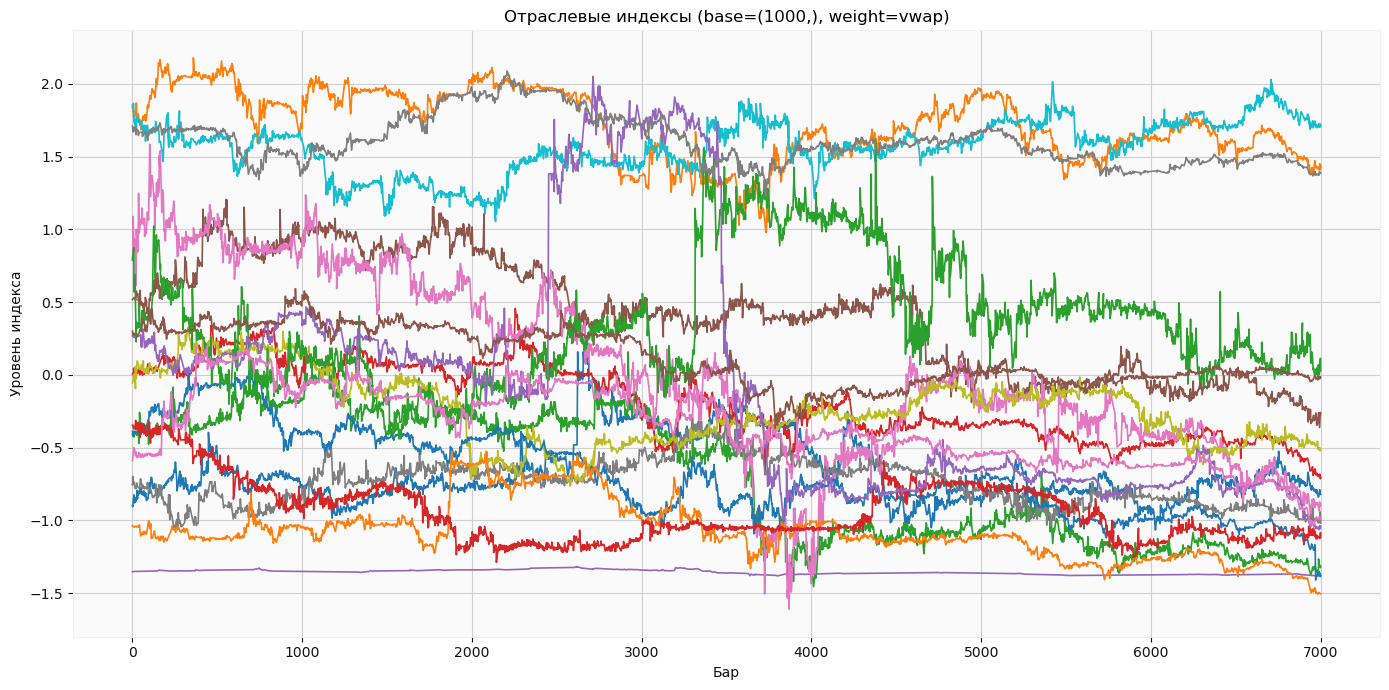

In [709]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
count = {}
fig, ax = plt.subplots(figsize=(14, 7))
for i in tqdm(tickers_to_search):
    ticker = i
    
    path = r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2' #test_files_15_2  data_long
    with open('phase_ful_tickers_params.txt', 'r') as file:
        phase_df = json.load(file)
    db_path_model = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/model_out_params/{ticker}.db"
    db_path = f"sqlite:///C:/Users/aleksandrovva1/Desktop/data science/0-trade/t/out_try/{ticker}.db"
    study_phase = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path, load_if_exists=True)
    study_model = optuna.create_study(study_name=f'feature_hyperparam_search_{ticker}', directions=['minimize', 'minimize', 'minimize', 'maximize', 'minimize'], storage=db_path_model, load_if_exists=True)
    
    file_name = [i for i in os.listdir(r'C:\Users\aleksandrovva1\Desktop\data science\0-trade\t\test_files_15_2') if ticker == i.split('_')[0]][0]#test_files_15_2  data_long
    df_phase = pd.read_parquet(os.path.join(path, file_name))
    scaler = StandardScaler()
    cols = ['close','open','low']

    df_phase[cols]= scaler.fit_transform(df_phase[cols])
    #df_phase = pd.DataFrame(df_phase, columns=cols)
    
    df_phase['close'].iloc[-7000:].reset_index(drop=True).plot(ax=ax, lw=1.2)
    


ax.set_title(f"Отраслевые индексы (base={base}, weight={weight_mode})")
ax.set_xlabel("Бар")
ax.set_ylabel("Уровень индекса")
plt.tight_layout()
plt.show()